# **Non Homogeneous Hidden Markov Model**

In [1]:
# Importar librerías necesarias
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Habilitar conversión entre pandas y R
pandas2ri.activate()

In [2]:
from rpy2.robjects.packages import importr

# Cargar el paquete base de R
base = importr('base')

In [3]:
# Verificar conexión con R e intentar cargar un paquete
utils = importr('utils')  # Librería para gestionar paquetes en R

try:
    depmixS4 = importr('depmixS4')  # Intentar cargar depmixS4
    print("El paquete 'depmixS4' se cargó correctamente.")
except:
    print("El paquete 'depmixS4' no está instalado. Procediendo a instalar...")
    utils.install_packages('depmixS4')
    depmixS4 = importr('depmixS4')
    print("El paquete 'depmixS4' se instaló y cargó correctamente.")

El paquete 'depmixS4' se cargó correctamente.


## Library Loading and Configuration

In [4]:
import os
# os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

## Data loading and preparation:

In [5]:
covid_data = pd.read_excel('/Users/constanzaneiraurrutia/Desktop/ESCRITORIO/MAGÍSTER DATA SCIENCE/PUBLICACIÓN TESIS/ANÁLISIS DE DATOS/covid_data.xlsx')

In [6]:
covid_data.columns

Index(['IM_interno', 'IM_externo', 'inc_pc_comuna', 'TasaCasosAcumulados',
       'Personas_hogar_promedio', 'inmigrantes', 'total_hog_hacinados',
       'indic_precariedad_vivienda', 'Comuna', 'fecha', 'dias', 'por_educ_sup',
       'porc_postgrado', 'IPS_2020', 'Prioridad_2020', 'CODIGO', 'year',
       'month', 'paso', 'paso_etiqueta', 'Fecha inicio cuarentena',
       'Fecha término cuarentena', 'Casos_Diarios_Brutos',
       'Casos_Diarios_Brutos_MM7'],
      dtype='object')

In [7]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [8]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days'],
      dtype='object')

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.

In [9]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

## Exploratory Data Analysis (EDA):

### Gross Daily Cases with 7-day moving average:

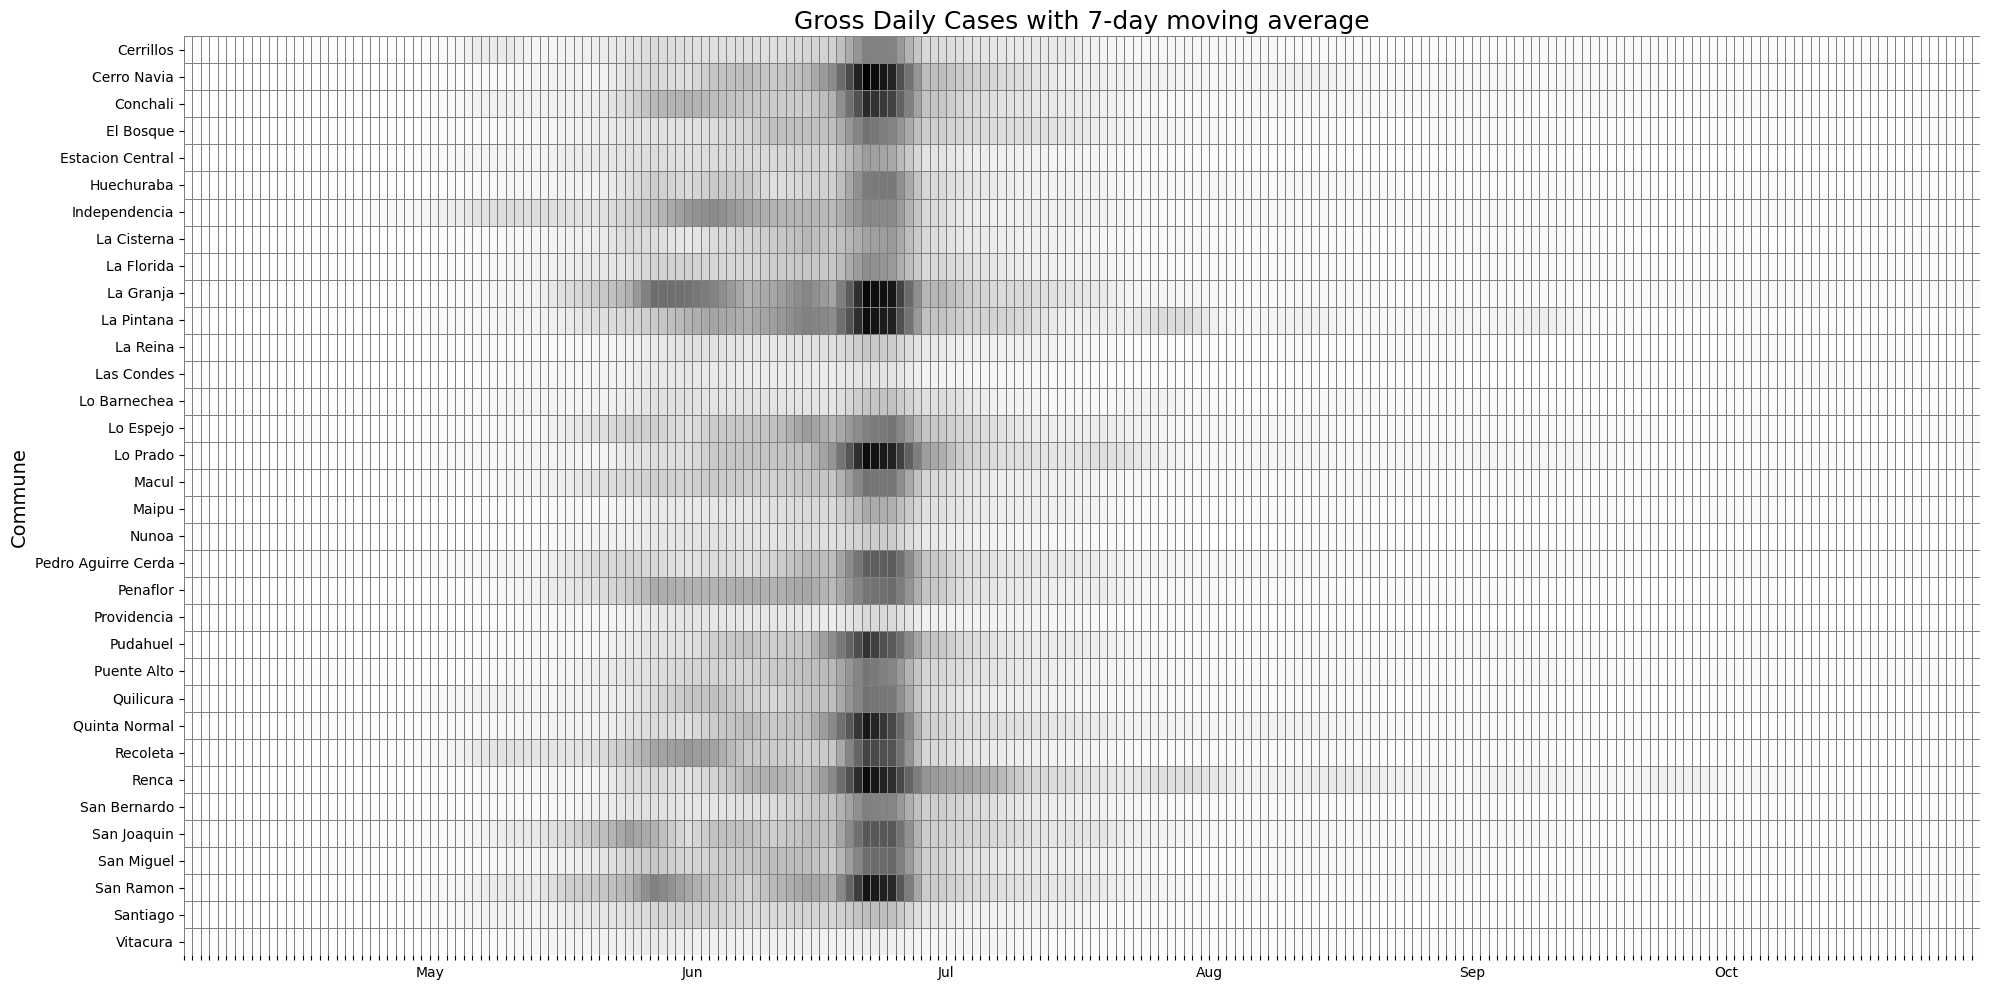

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Convertir 'Days' a datetime si no lo es
if not pd.api.types.is_datetime64_any_dtype(covid_data['Days']):
    reference_date = covid_data['Date'].min()
    covid_data['Days'] = reference_date + pd.to_timedelta(covid_data['Days'], unit='D')

# Paso 2: Crear la tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Gross_Daily_Cases_Mobile_Average_7_Days')

# Paso 3: Filtrar fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Paso 4: Crear gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys',
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Mostrar etiquetas solo para primeros días del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

plt.title('Gross Daily Cases with 7-day moving average', fontsize=18)
plt.tight_layout()
plt.show()


### Internal Mobility Index of each commune over time:

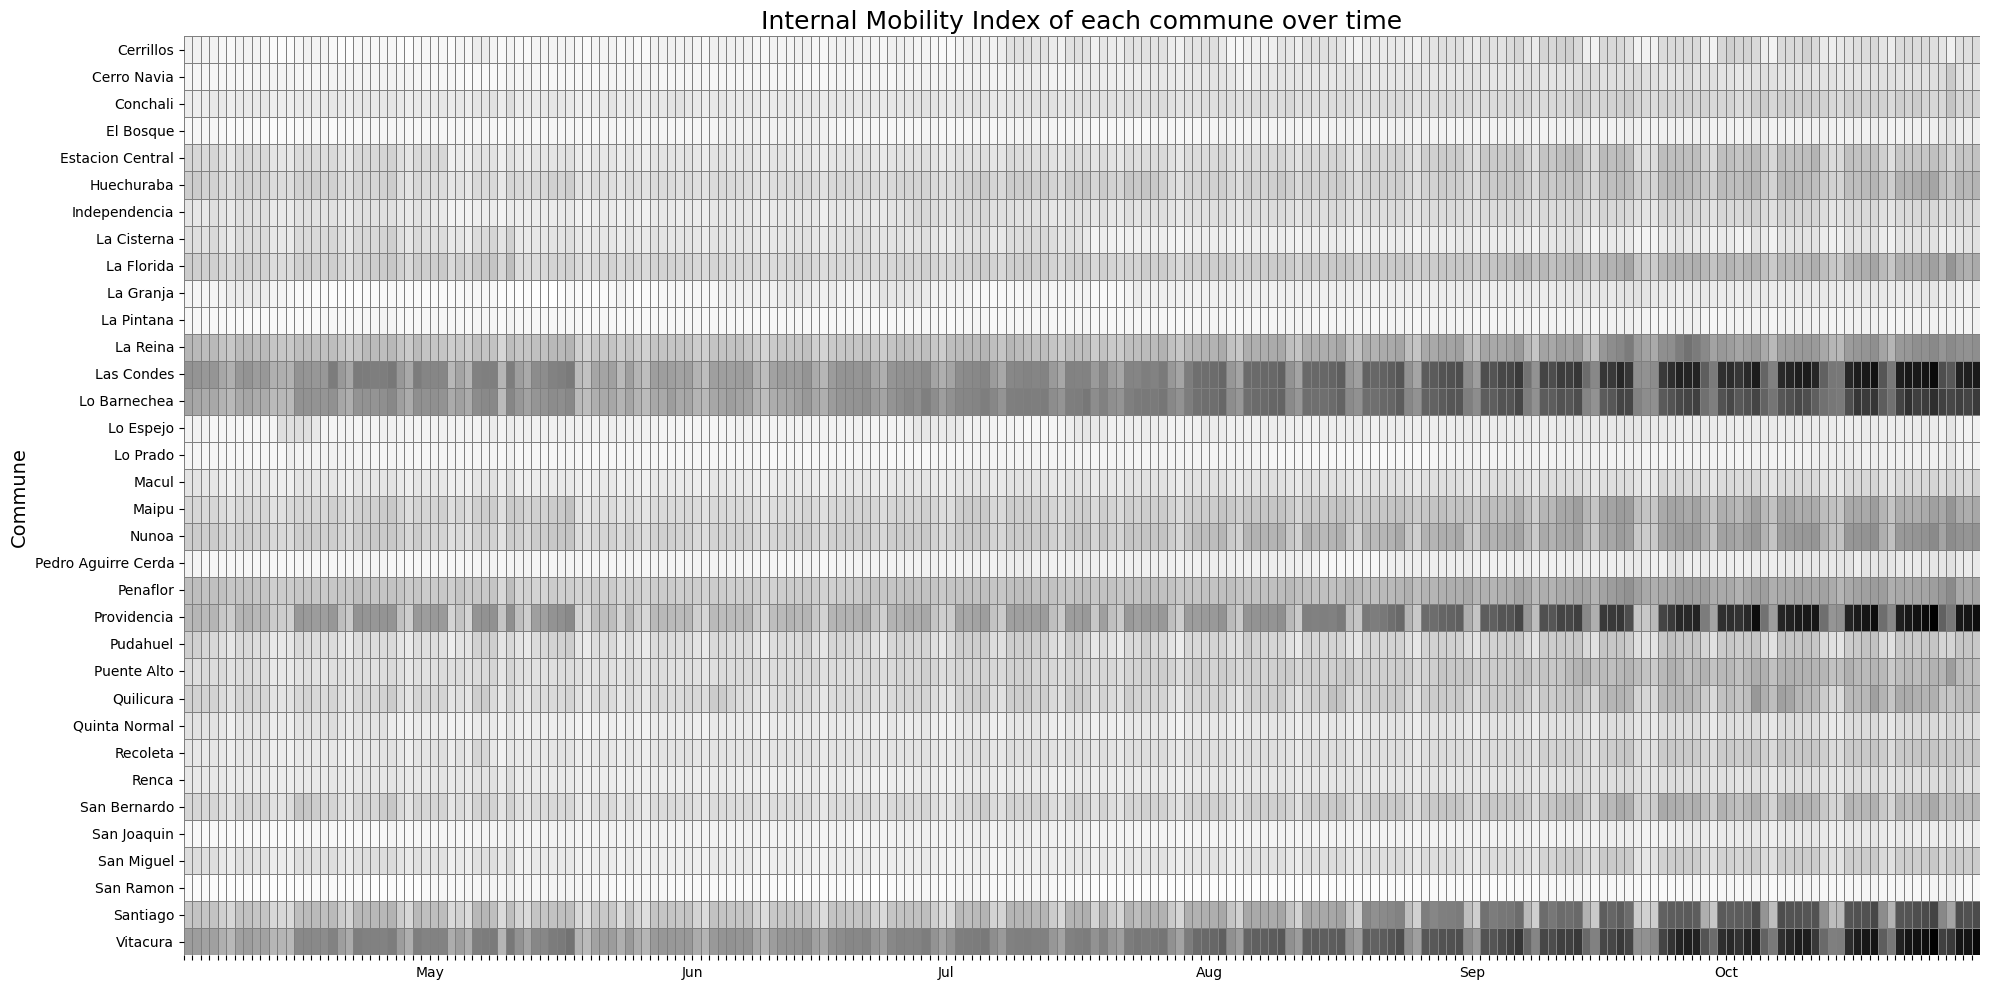

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas para mostrar
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad interna
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Filtrar las columnas por fechas en el rango deseado
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys',
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Configurar etiquetas del eje x (solo mostrar el nombre del mes en el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()


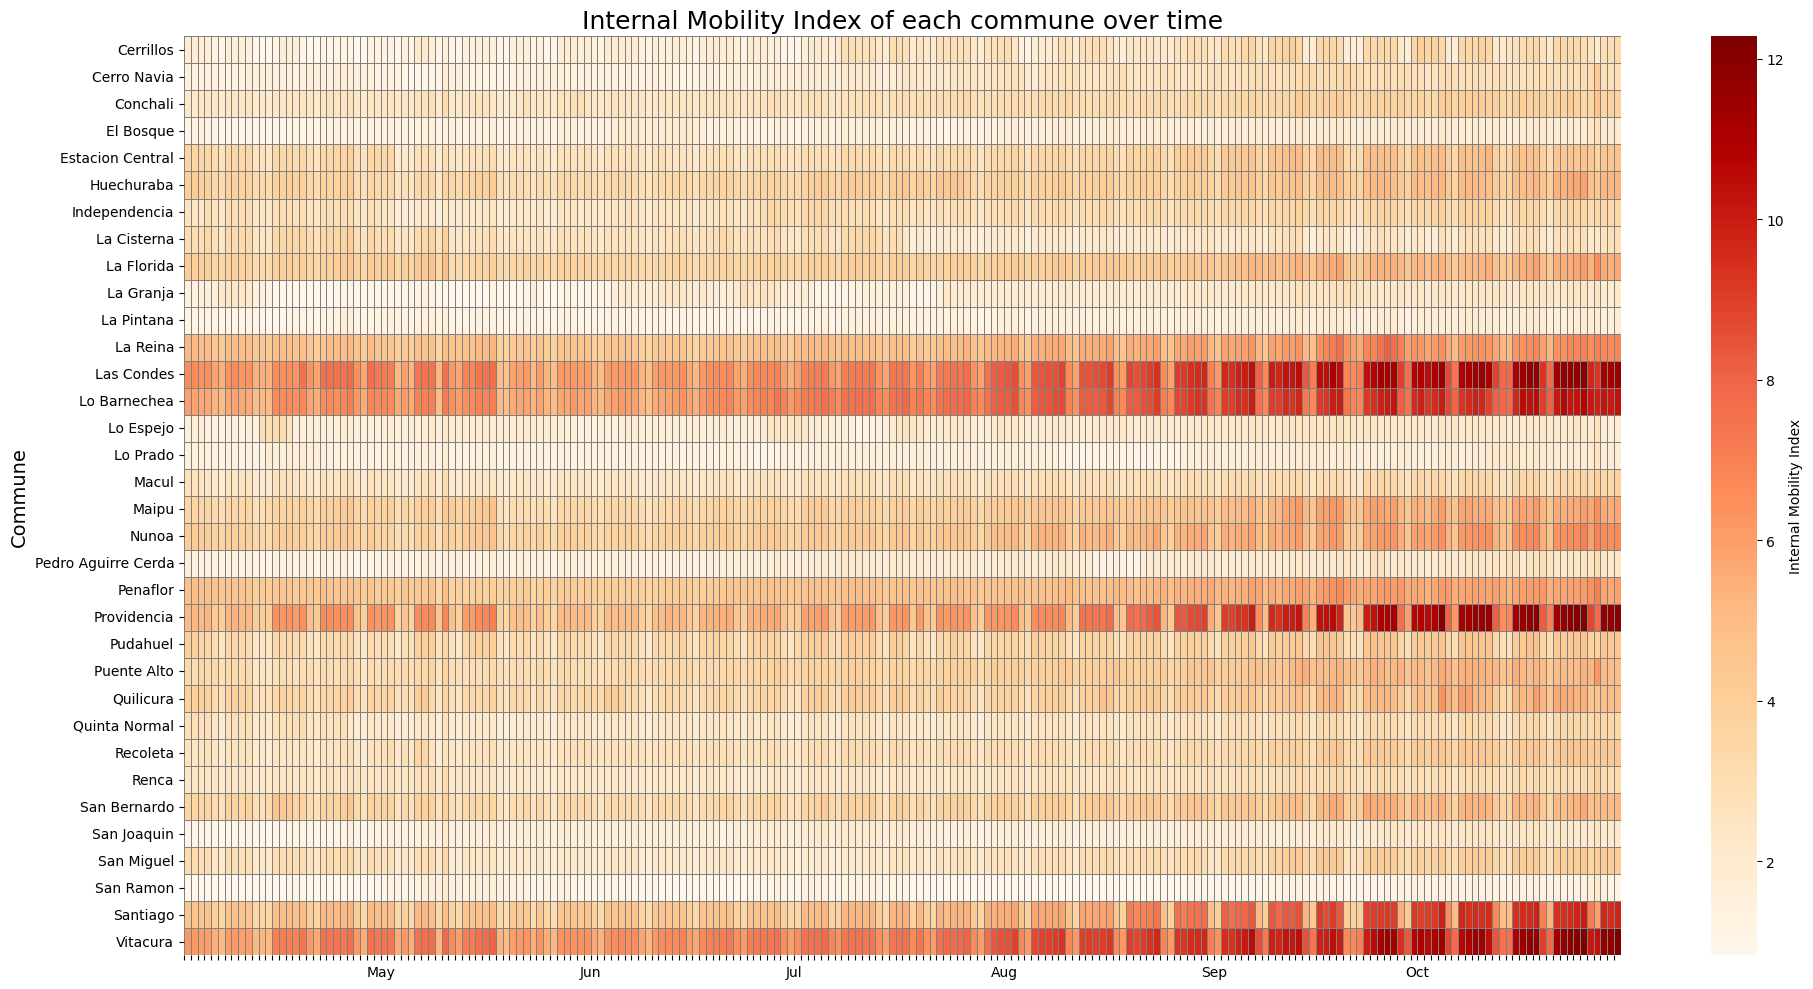

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Filtrar por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Valores mínimos y máximos personalizados para mejorar contraste
vmin = covid_pivot.quantile(0.05).min()  # mínimo más robusto
vmax = covid_pivot.quantile(0.95).max()  # máximo más robusto

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='OrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Internal Mobility Index'},
    vmin=vmin,  # limitar escala inferior
    vmax=vmax,  # limitar escala superior
    ax=ax
)

# Etiquetas
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

plt.tight_layout()
plt.show()


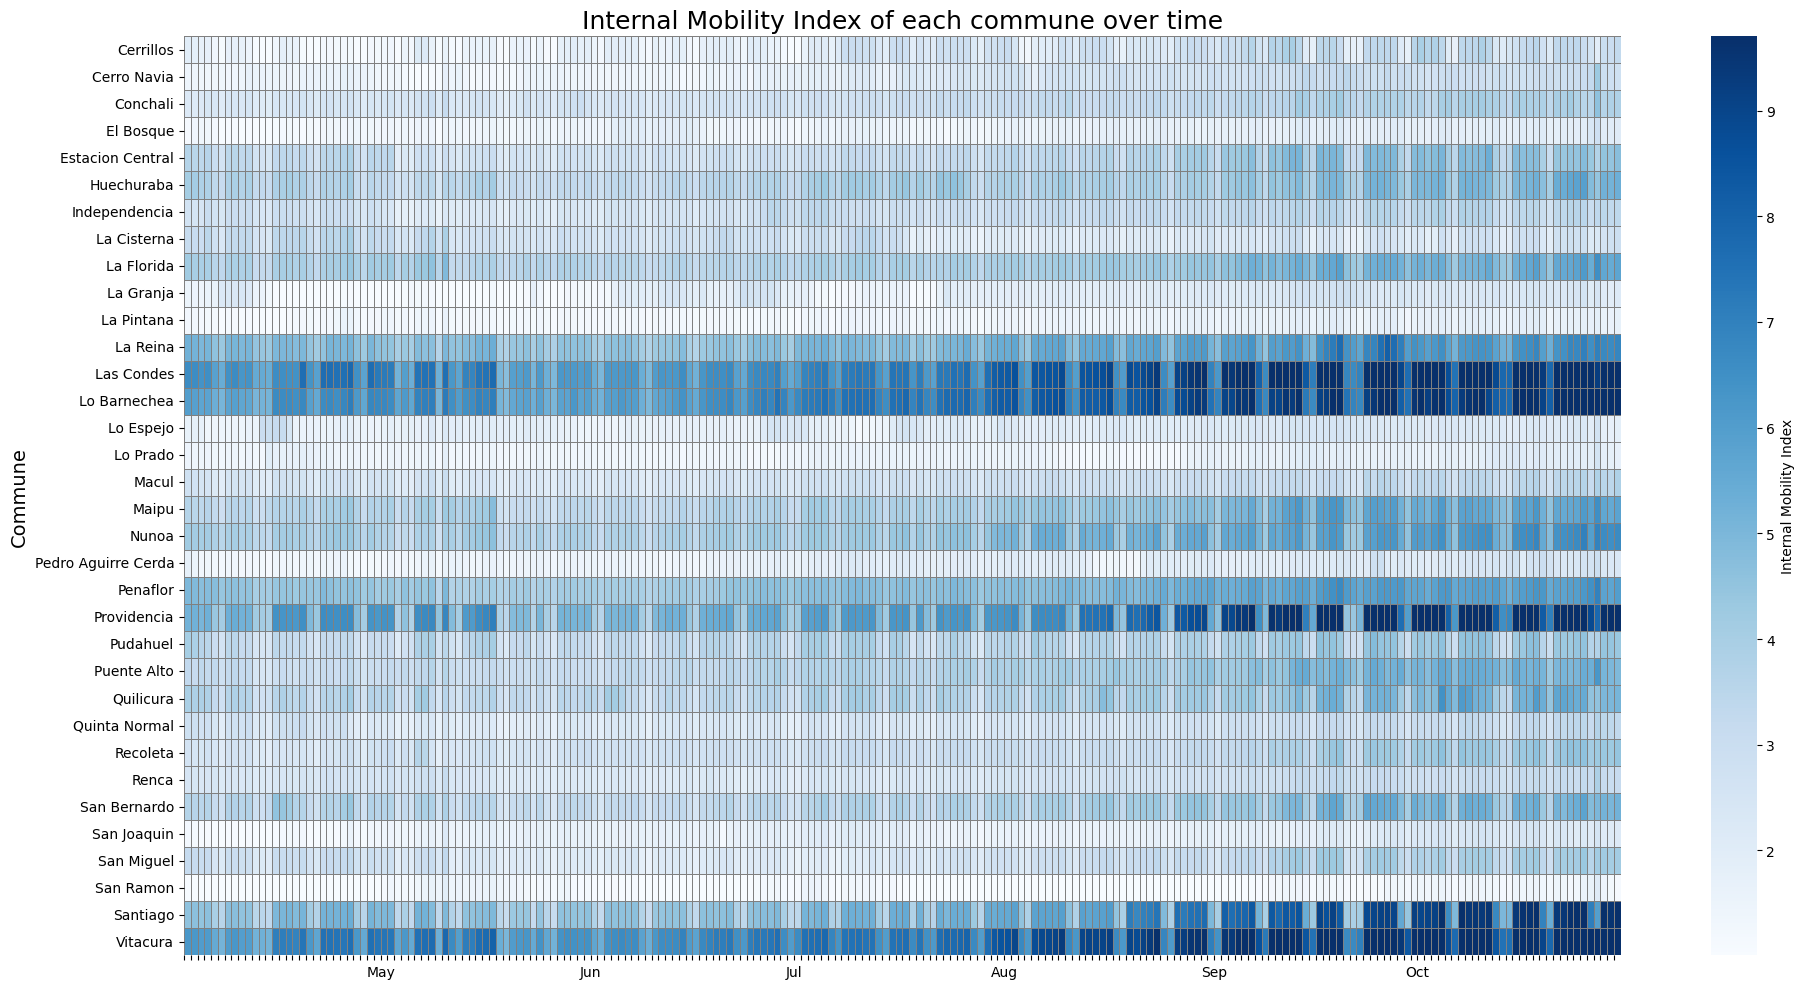

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Filtrar fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Blues',  # 💙 paleta azul
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Internal Mobility Index'},
    robust=True,  # 🔍 mejora el contraste sin outliers extremos
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x (solo nombre del mes en el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


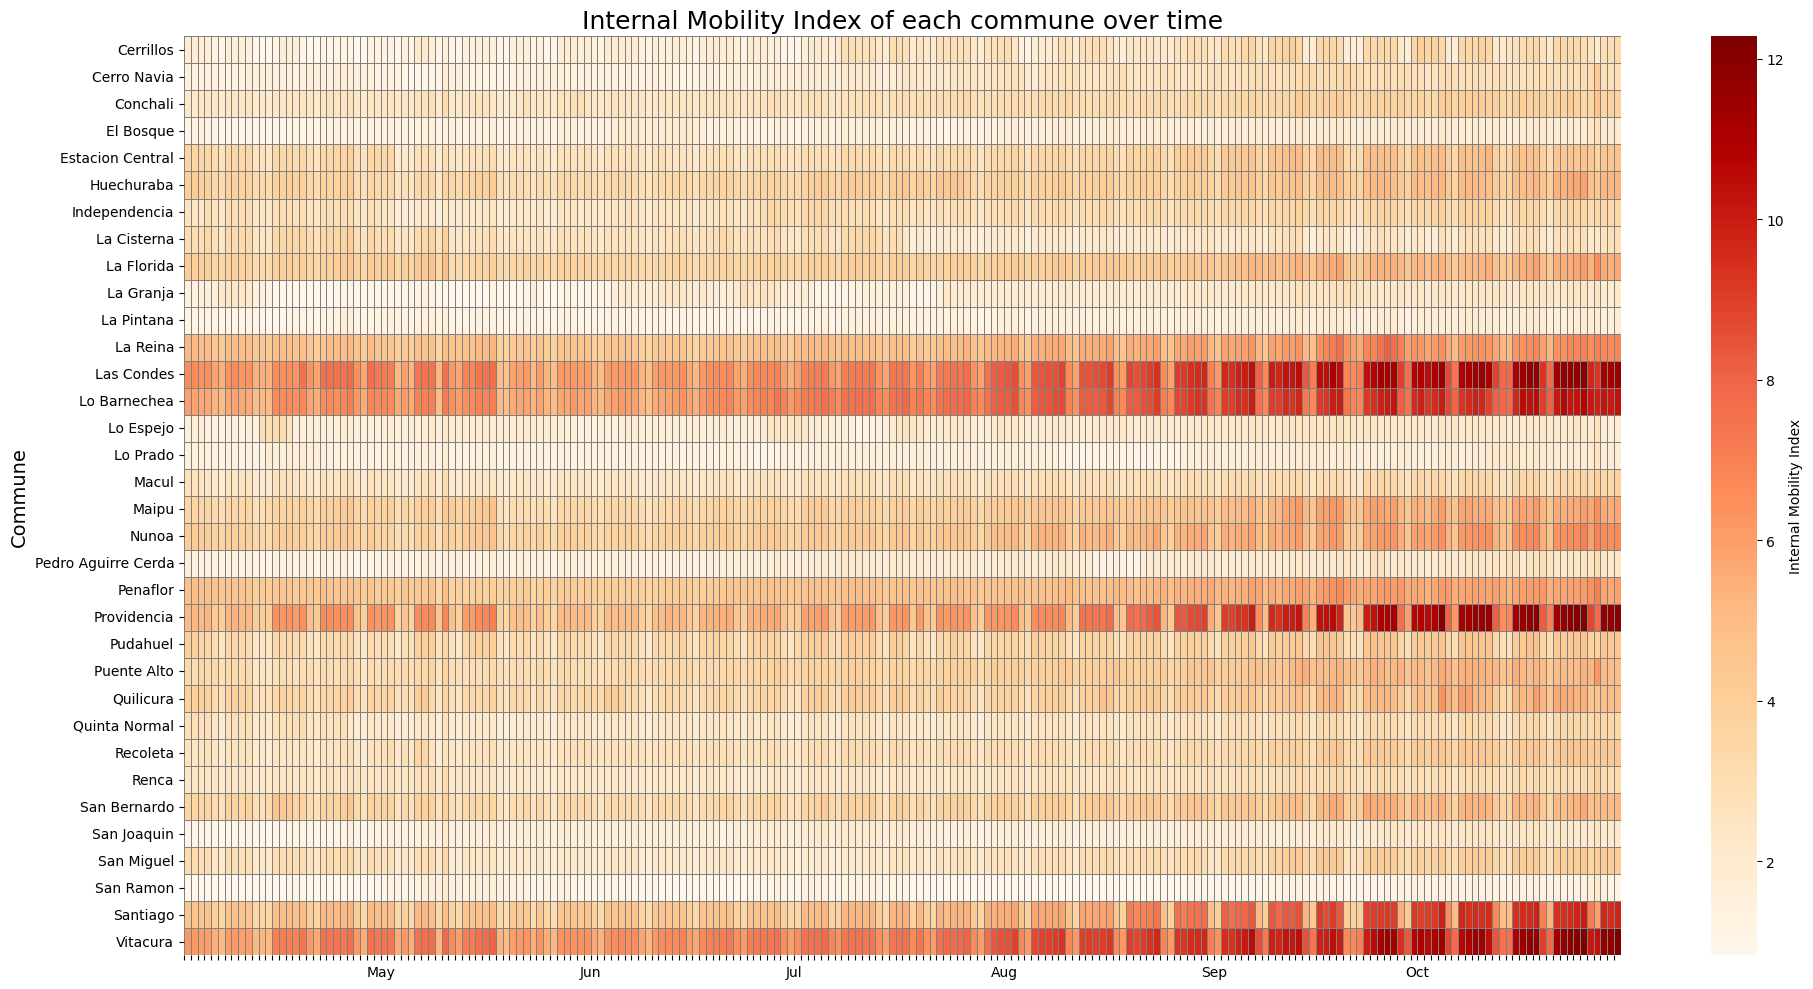

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear tabla pivot
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Filtrar por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Valores mínimos y máximos personalizados para mejorar contraste
vmin = covid_pivot.quantile(0.05).min()  # mínimo más robusto
vmax = covid_pivot.quantile(0.95).max()  # máximo más robusto

# Crear el gráfico
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='OrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Internal Mobility Index'},
    vmin=vmin,  # limitar escala inferior
    vmax=vmax,  # limitar escala superior
    ax=ax
)

# Etiquetas
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('Internal Mobility Index of each commune over time', fontsize=18)

plt.tight_layout()
plt.show()



### External Mobility Index of each commune over time:

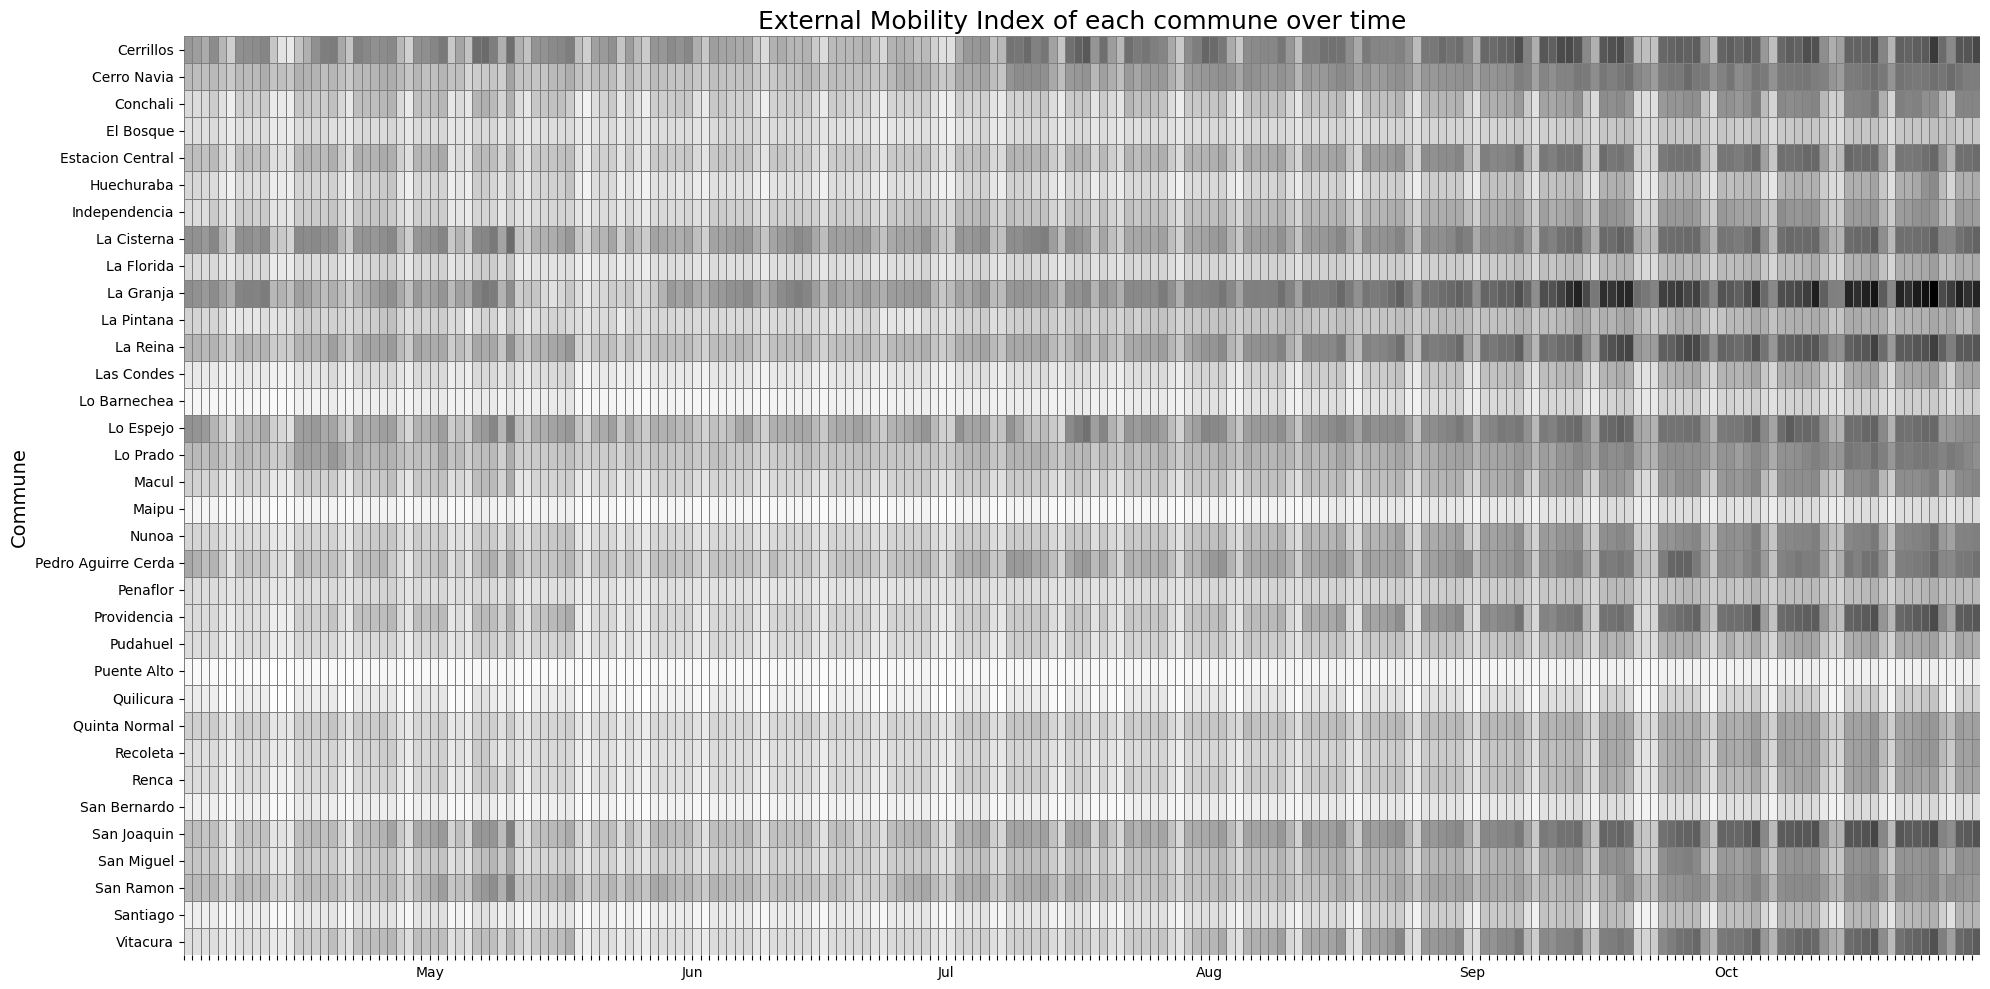

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad externa
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')

# Filtrar columnas por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys',
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: solo mostrar el nombre del mes si es el primer día del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('External Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()


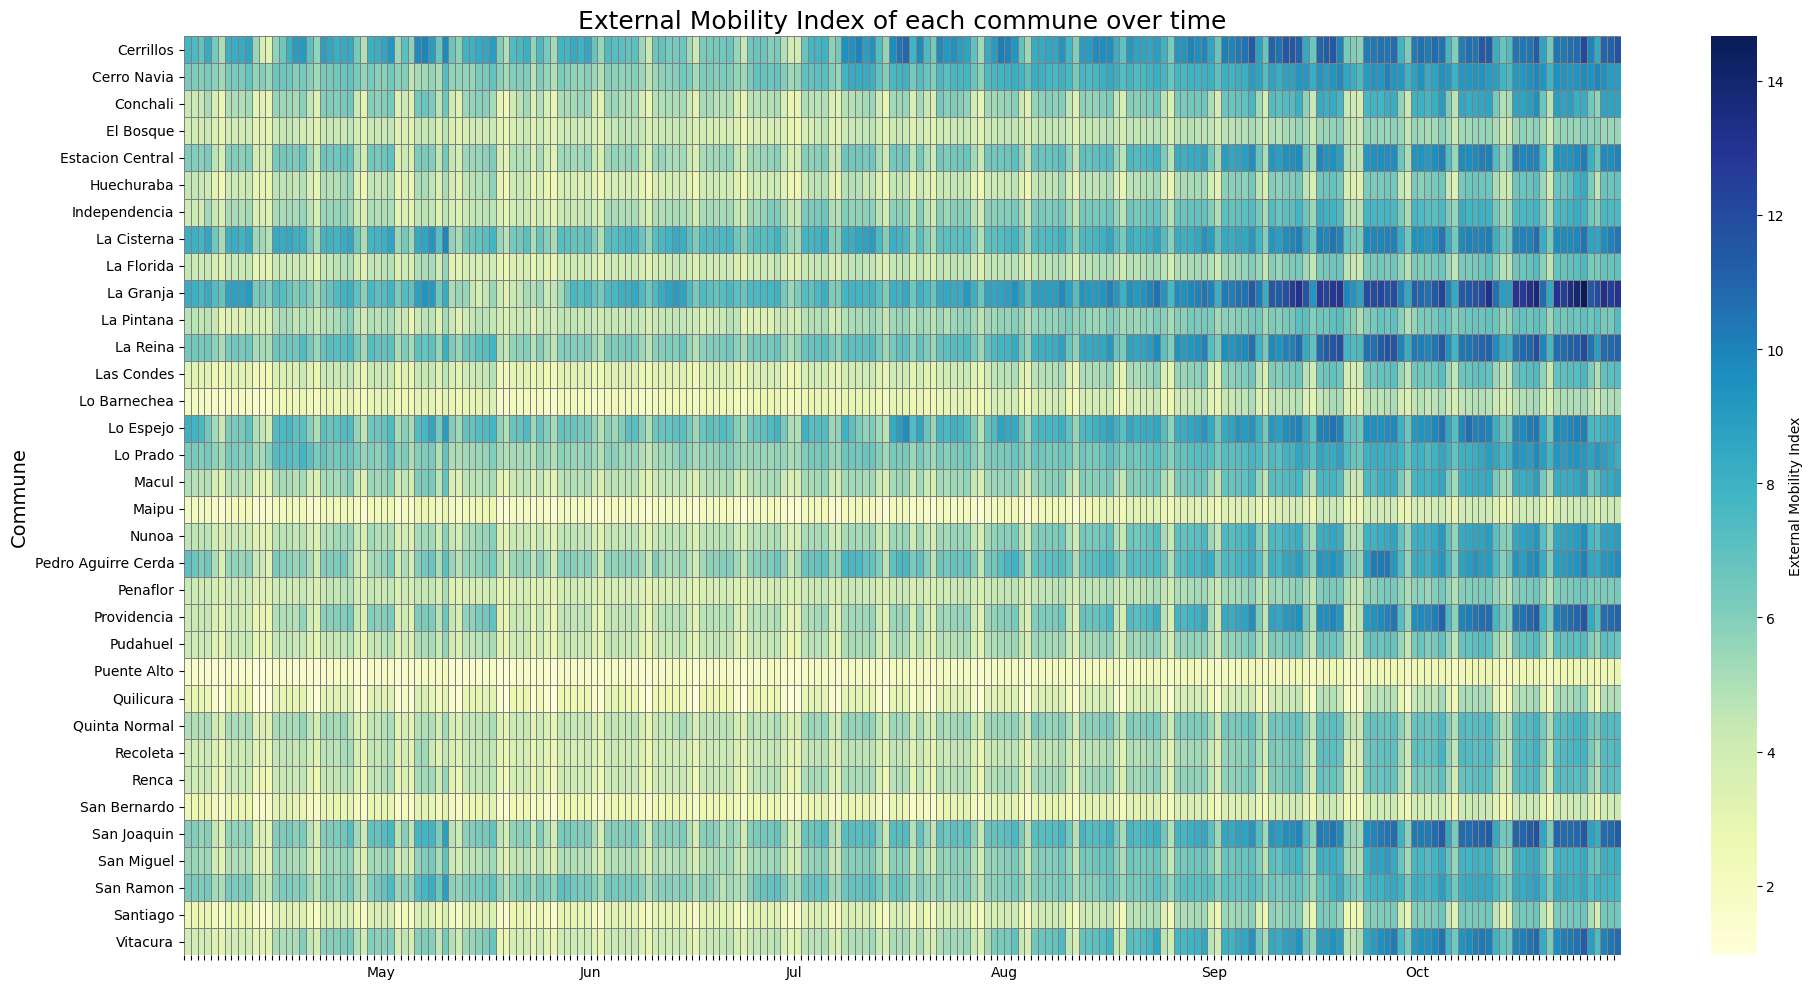

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad externa
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')

# Filtrar columnas por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el heatmap con paleta tipo Nature (azules y verdes suaves)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='YlGnBu',  # Nature-style colormap (Yellow-Green-Blue)
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'External Mobility Index'},
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: solo mostrar el nombre del mes si es el primer día del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('External Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()



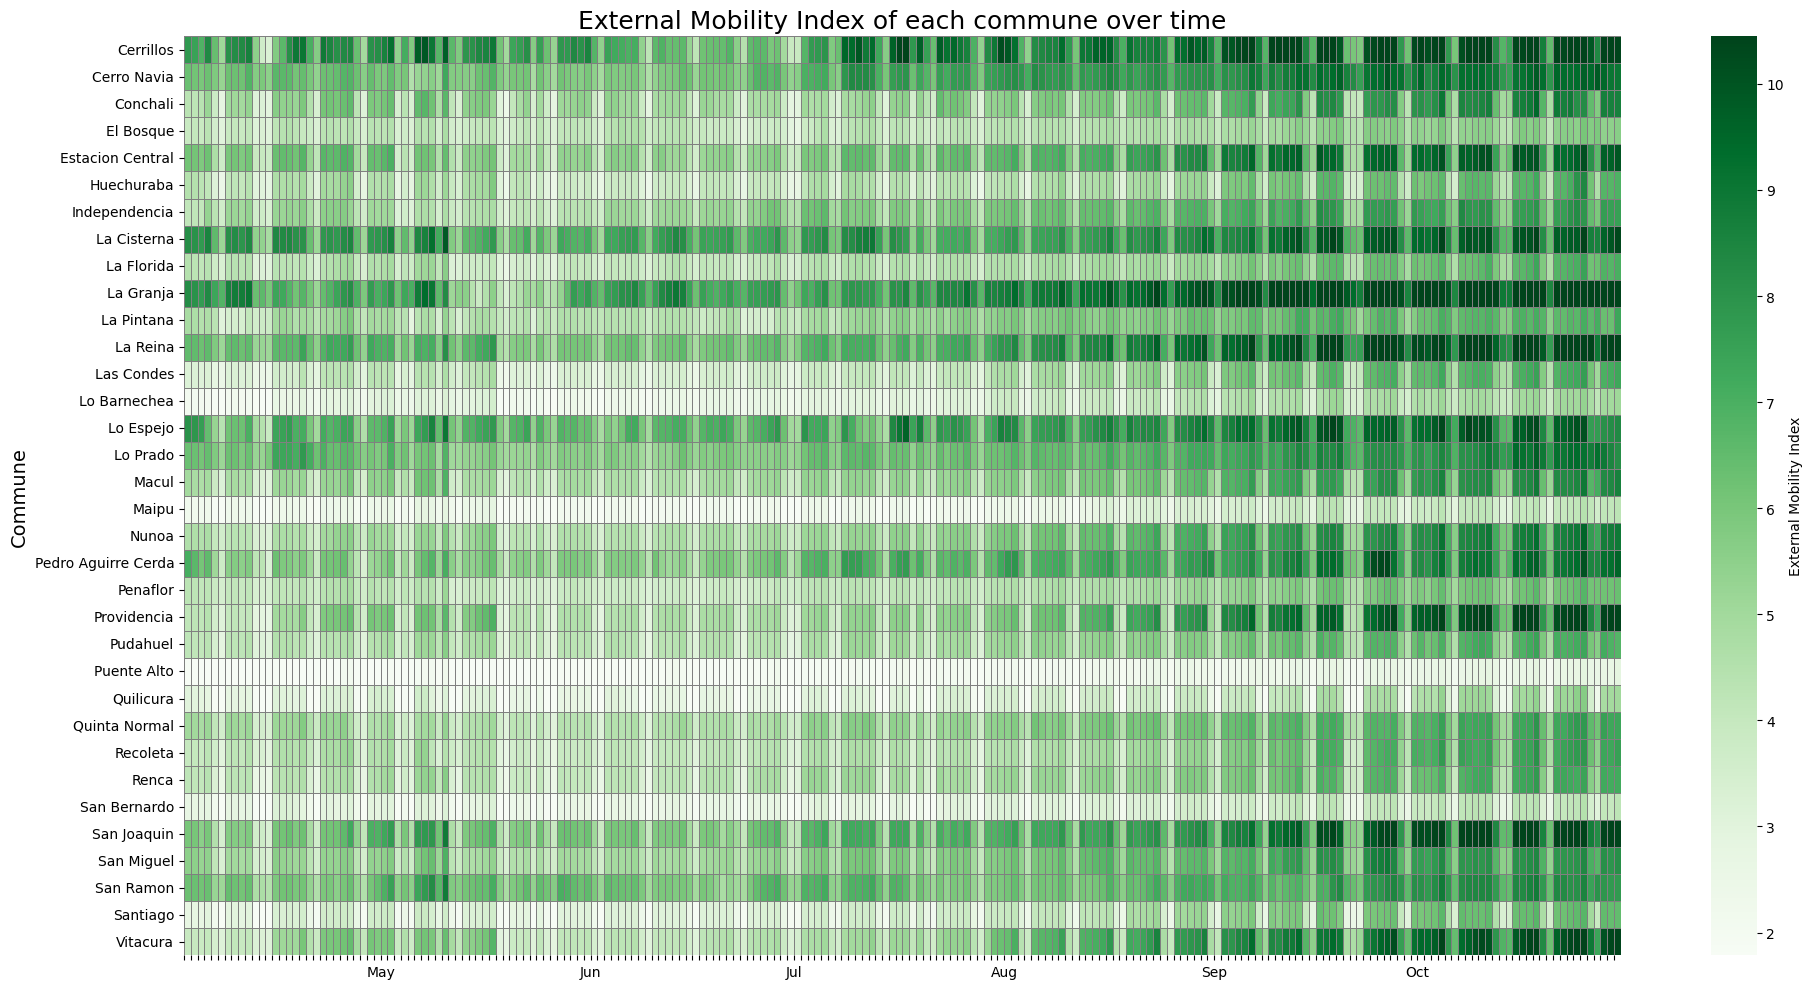

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot con el índice de movilidad externa
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')

# Filtrar columnas por rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greens',  # 💚 Paleta verde clara a intensa
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'External Mobility Index'},
    robust=True,  # Mejora el contraste
    ax=ax
)

# Etiquetas de ejes
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x (solo el nombre del mes si es el primer día)
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Título
plt.title('External Mobility Index of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


### Step by Step Plan:

In [18]:
covid_data['Step_Label'].unique()

array(['Sin Medida', 'Cuarentena', 'Transición', 'Preparación',
       'Apertura'], dtype=object)

In [19]:
# Rearrange the Step by Step_Label
remap_step = {'Sin Medida': 'Unrestricted', 'Cuarentena': 'Quarantine', 'Transición':'Transition', 'Preparación':'Preparation','Apertura':'Opening'}
covid_data['Step_Label'] = covid_data['Step_Label'].map(remap_step)

### *REVISAR ETIQUETADO DE LOS PASO A PASO, PARECE QUE ESTÁN MAL*

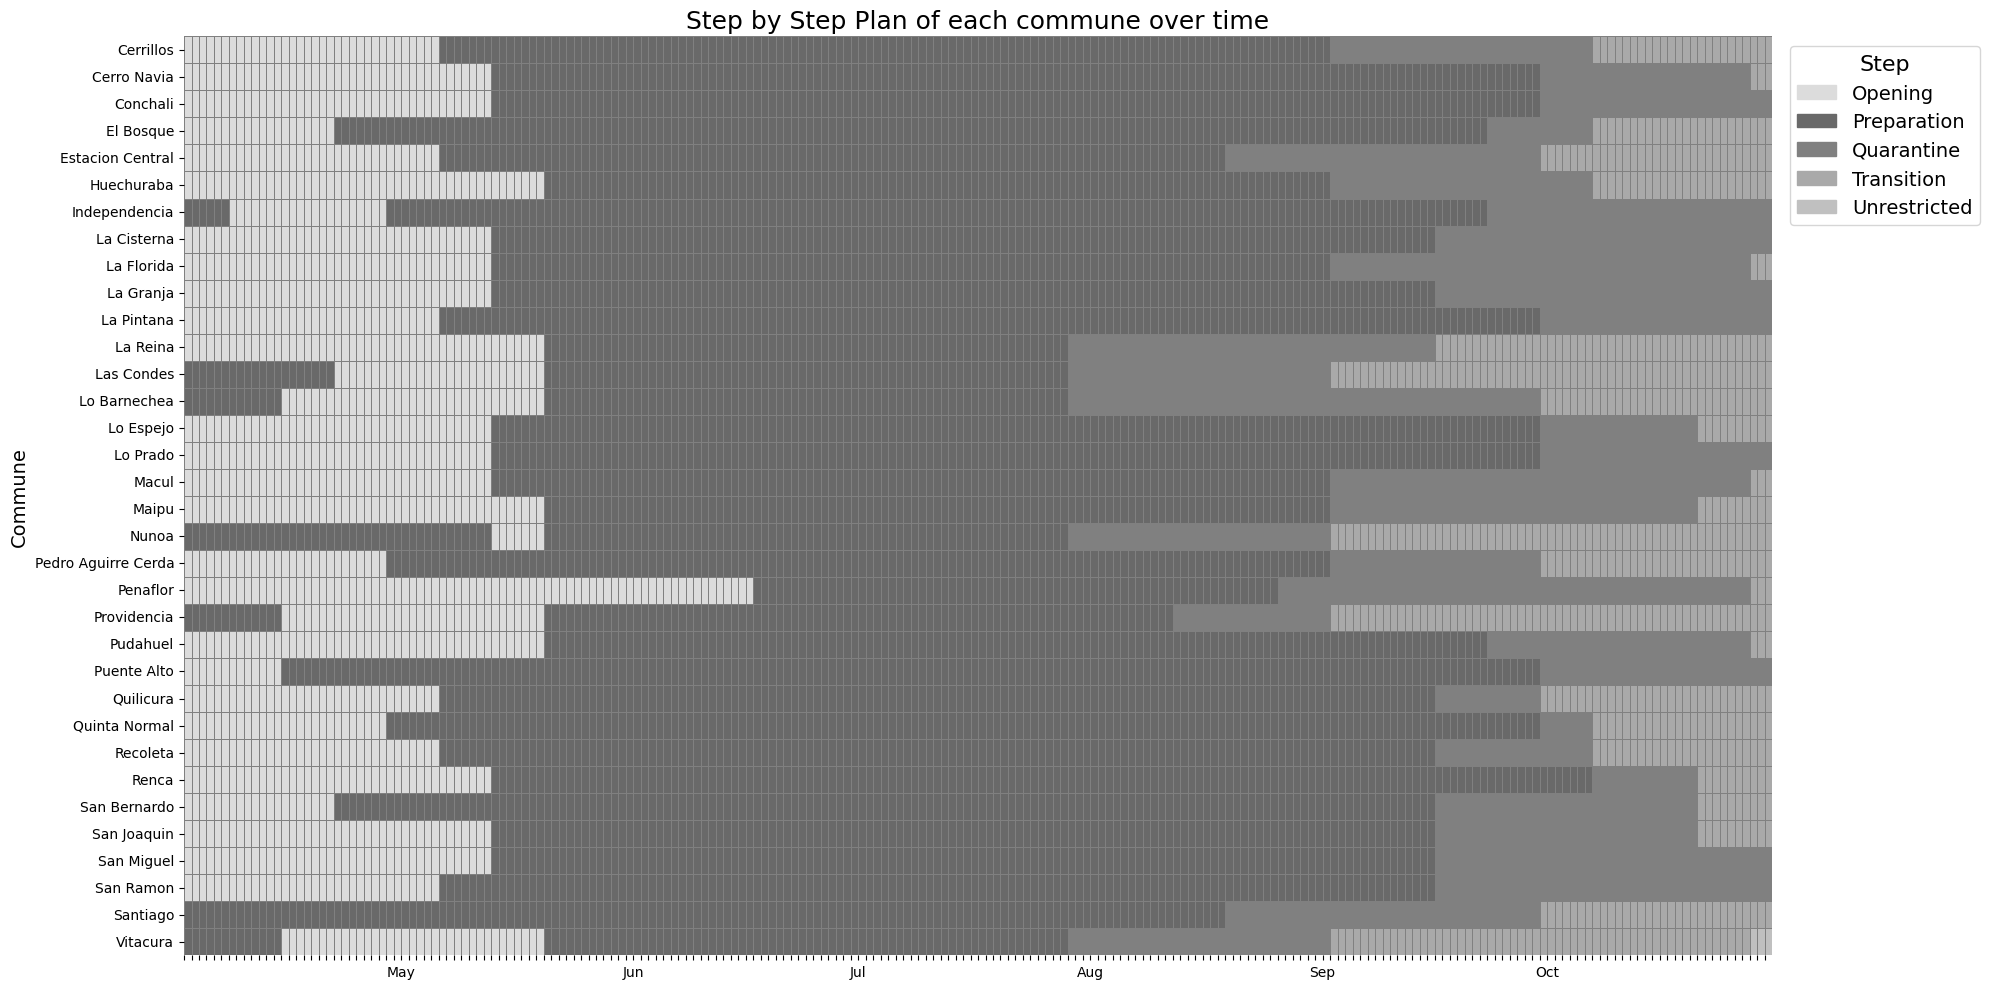

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Definir el rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot de los pasos
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Step')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Colores personalizados (tonos de gris para las fases del plan Paso a Paso)
custom_colors = ['#DCDCDC', '#696969', '#808080', '#A9A9A9', '#C0C0C0']
cmap = sns.color_palette(custom_colors, as_cmap=True)

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

# Etiquetas del eje
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: mostrar solo nombre del mes si es el primer día
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear la leyenda personalizada
# Asegúrate de que 'Step_Label' exista y tenga correspondencia con los colores
if 'Step_Label' in covid_data.columns:
    unique_labels = covid_data['Step_Label'].dropna().unique()
    unique_labels.sort()  # Opcional: para orden alfabético o lógico

    legend_handles = [
        mpatches.Patch(color=color, label=label)
        for color, label in zip(custom_colors, unique_labels)
    ]

    plt.legend(
        handles=legend_handles,
        title="Step",
        bbox_to_anchor=(1.005, 1),
        loc='upper left',
        fontsize=14,
        title_fontsize=16
    )

# Título del gráfico
plt.title('Step by Step Plan of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


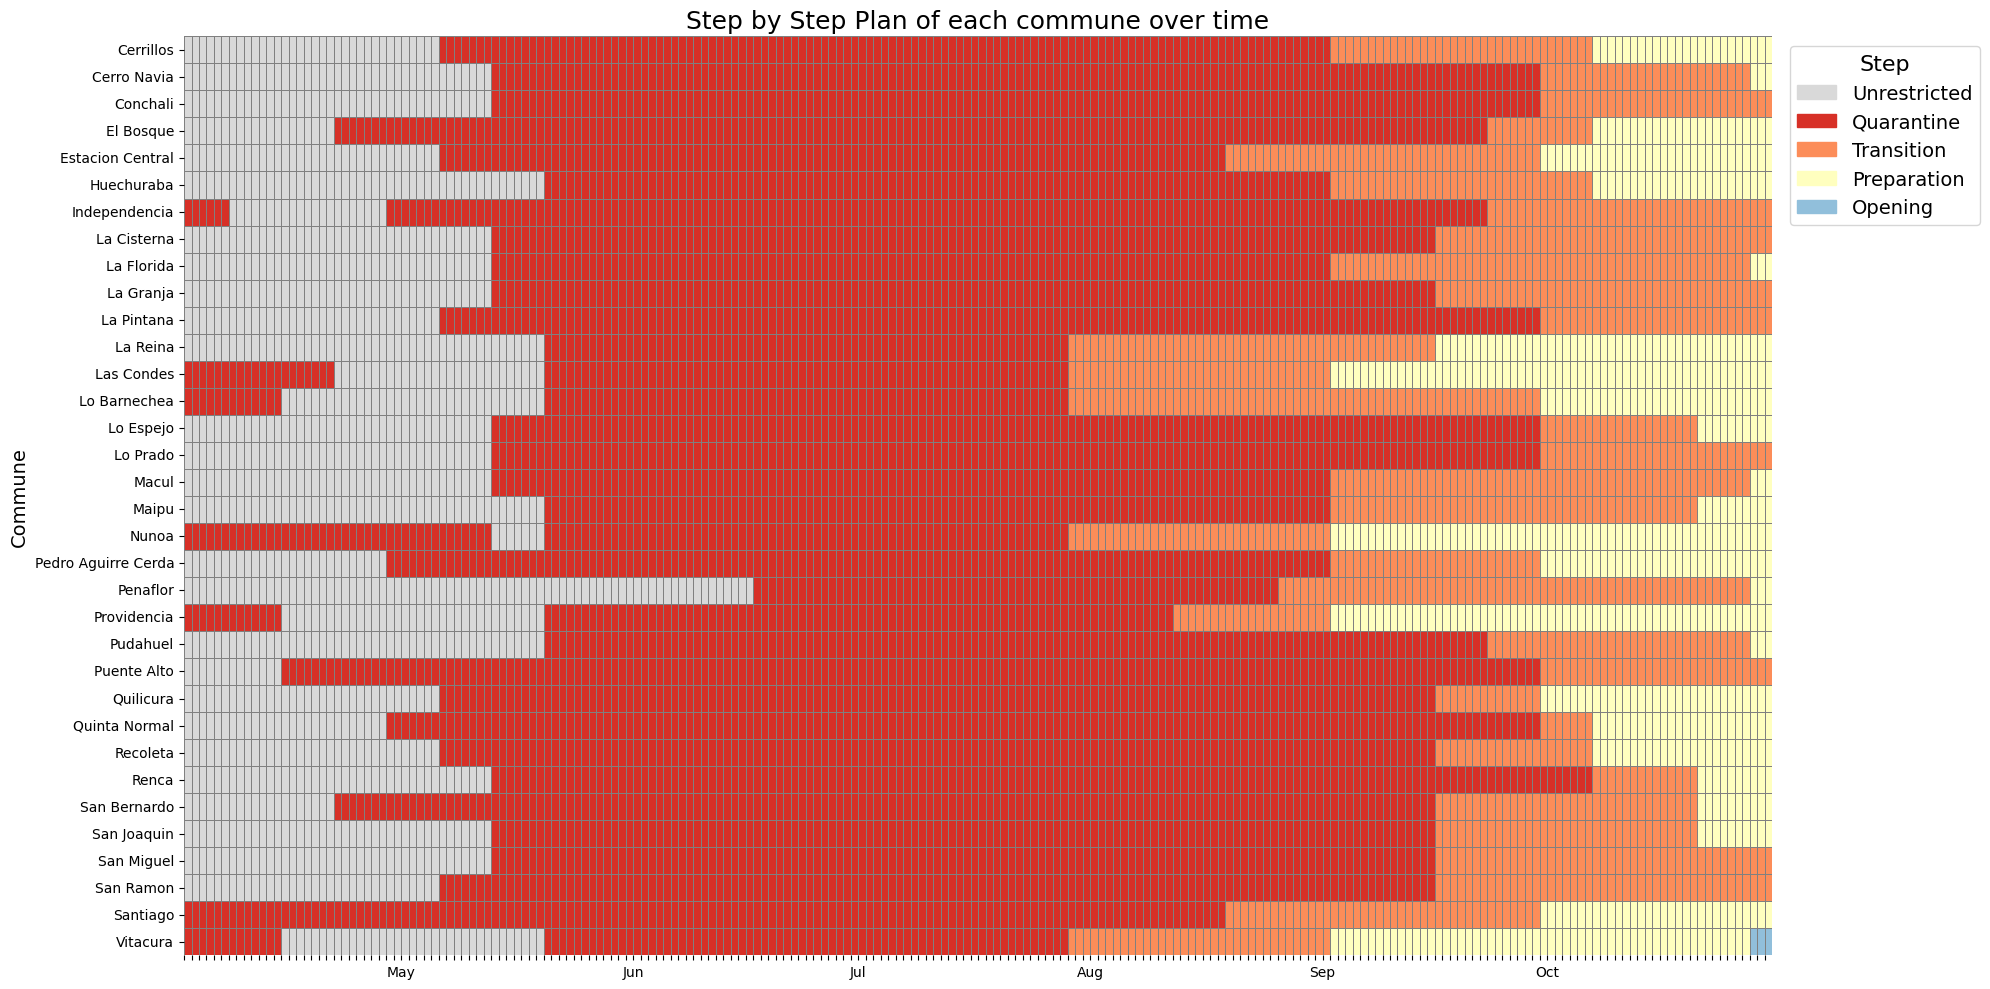

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Definir el rango de fechas
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Crear la tabla pivot de los pasos
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Step')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in covid_pivot.columns if min_date <= col <= max_date]
covid_pivot = covid_pivot[filtered_columns]

# Nueva paleta con amarillo para Preparación y azul para Apertura
step_colors = ['#d9d9d9', '#d73027', '#fc8d59', '#ffffbf', '#91bfdb']
step_labels = ['Unrestricted', 'Quarantine', 'Transition', 'Preparation', 'Opening']

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap=sns.color_palette(step_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    ax=ax
)

# Etiquetas del eje
ax.set_xlabel(None)
ax.set_ylabel("Commune", fontsize=14)

# Etiquetas del eje x: mostrar solo nombre del mes si es el primer día
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(step_colors, step_labels)
]

plt.legend(
    handles=legend_handles,
    title="Step",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Step by Step Plan of each commune over time', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

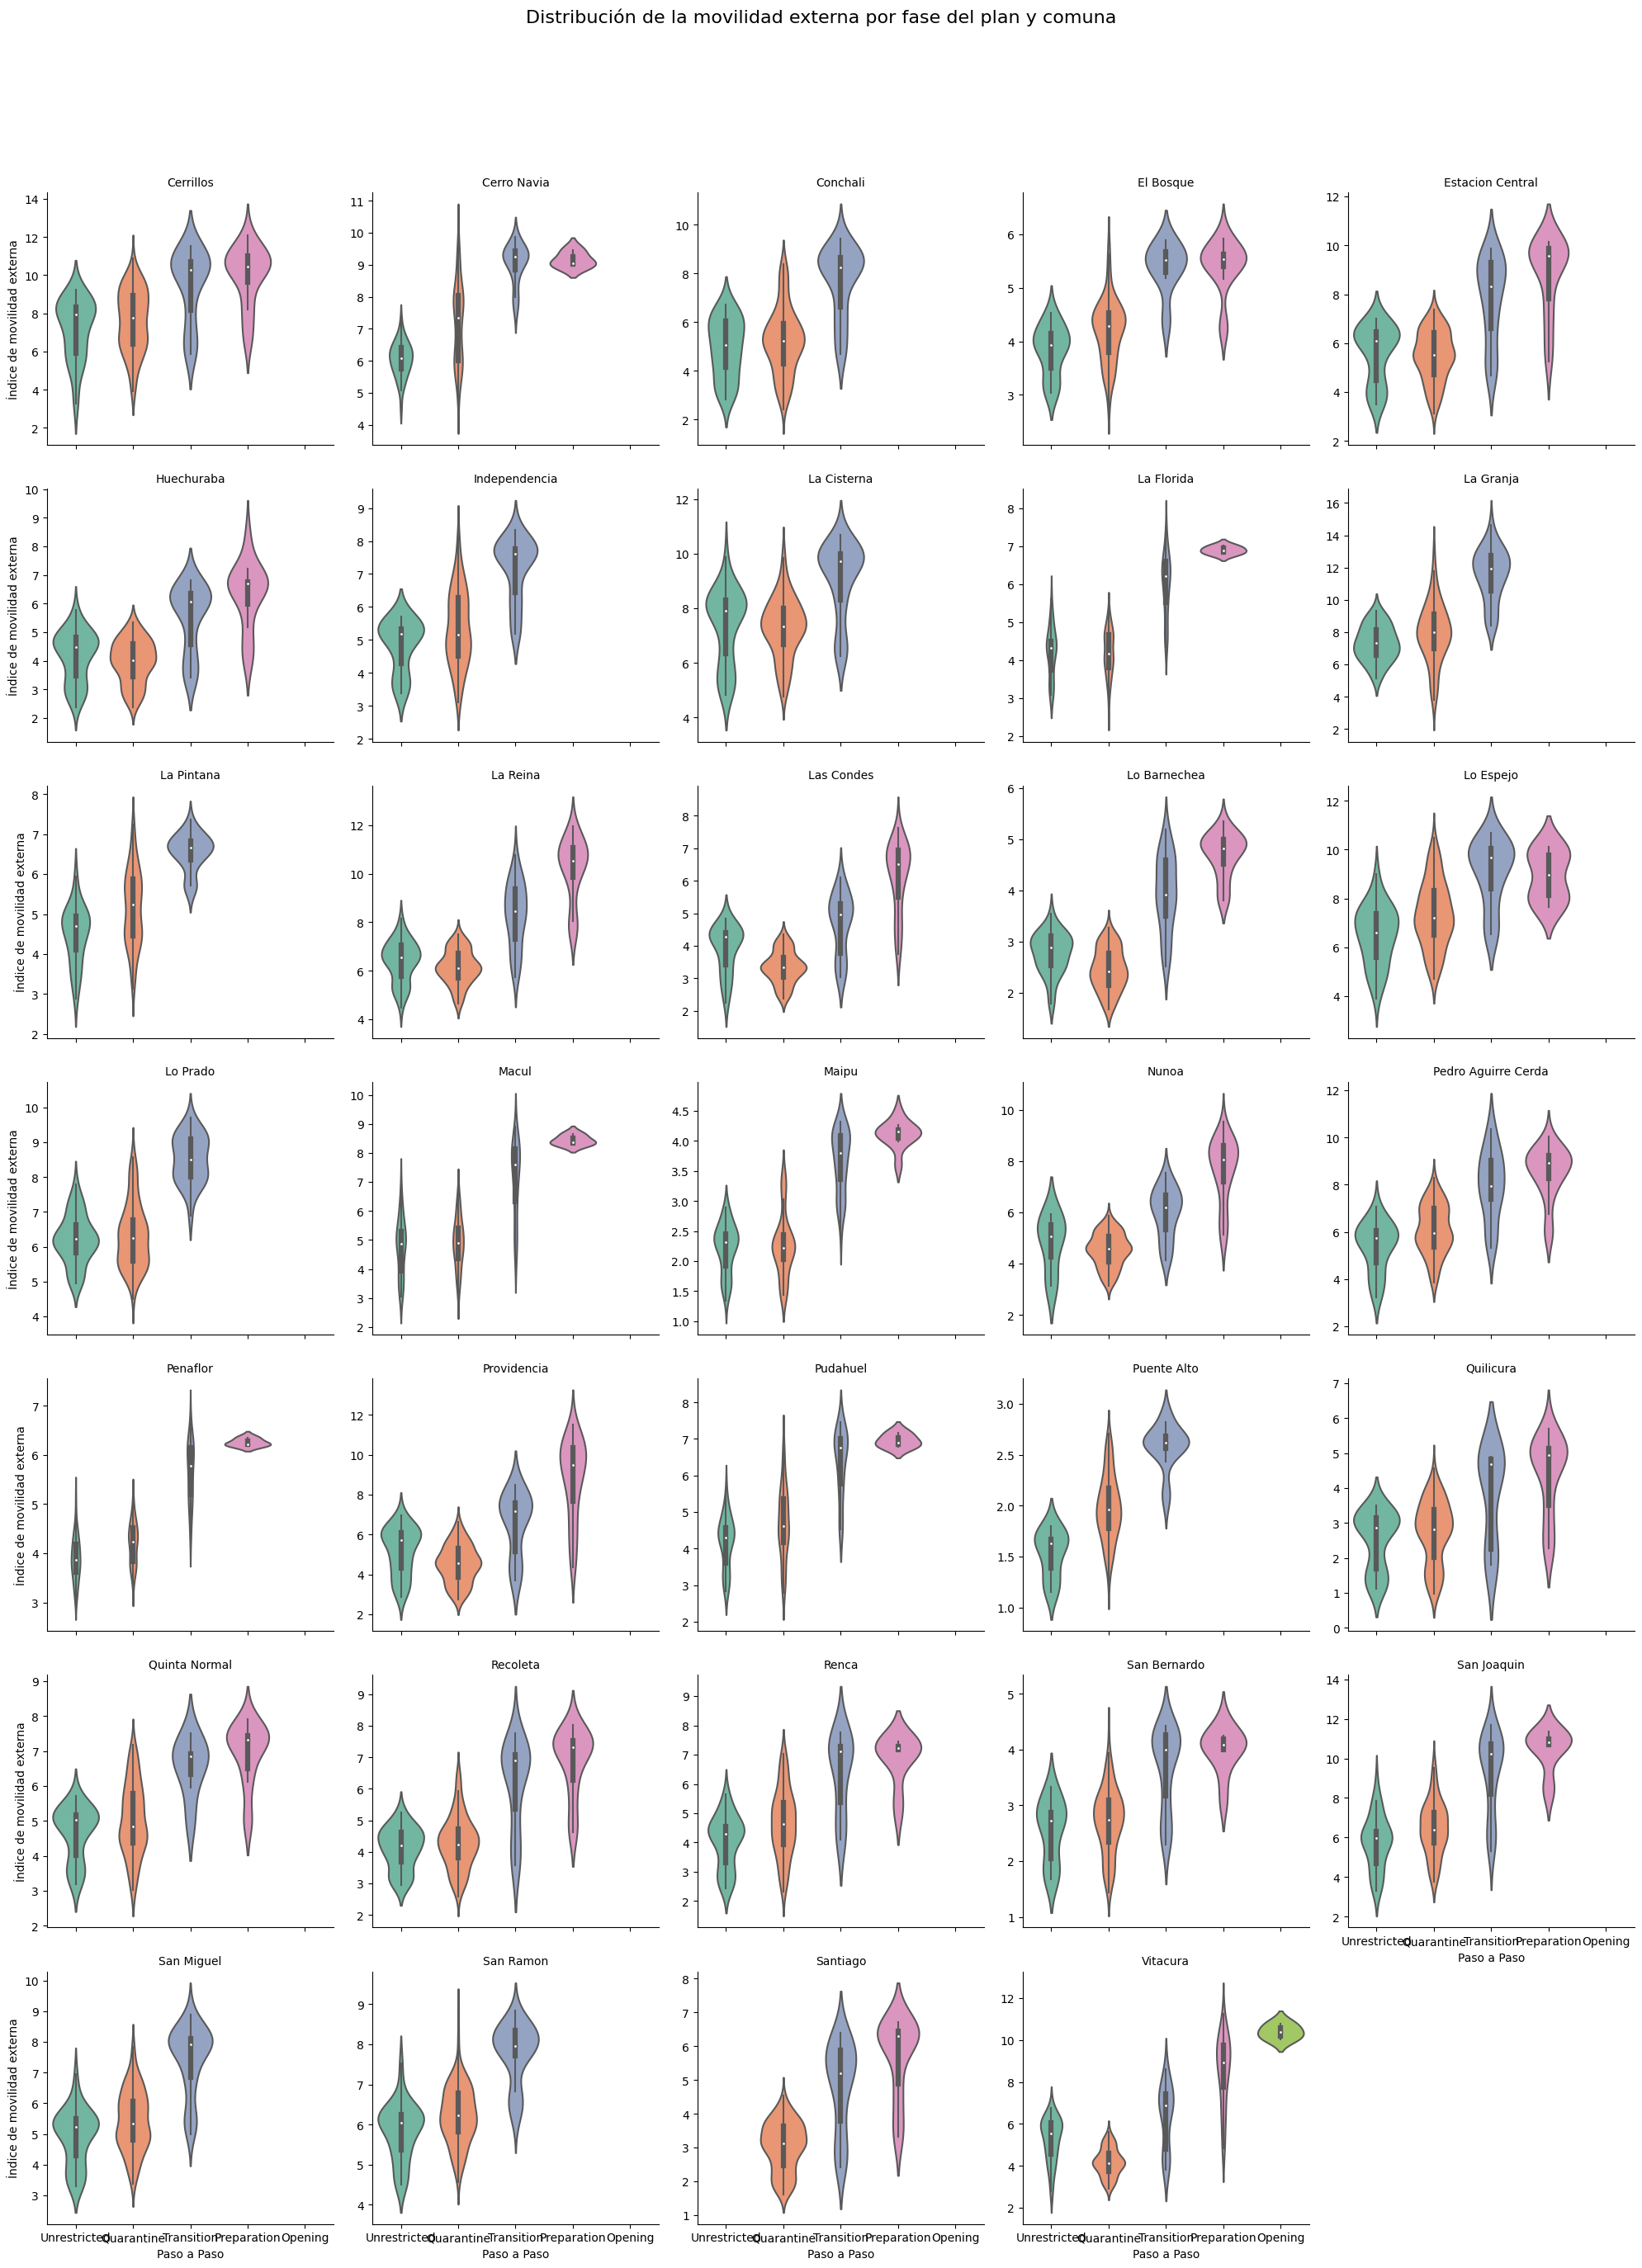

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos para fechas del plan
mask = (covid_data['Days'] >= '2020-03-31') & (covid_data['Days'] <= '2020-10-30')
filtered = covid_data.loc[mask].copy()

# Asegurar tipo string para Step_Label si no está
filtered['Step_Label'] = filtered['Step_Label'].astype(str)

# Gráfico violinplot facetado por comuna
g = sns.catplot(
    data=filtered,
    x='Step_Label', y='External_Mobility_Index',
    col='Commune', col_wrap=5,  # Puedes ajustar a 4 o 6 columnas
    kind='violin',
    palette='Set2',  # O personaliza los colores como en Nature
    sharey=False, height=4, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Paso a Paso", "Índice de movilidad externa")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribución de la movilidad externa por fase del plan y comuna", fontsize=16)

plt.show()


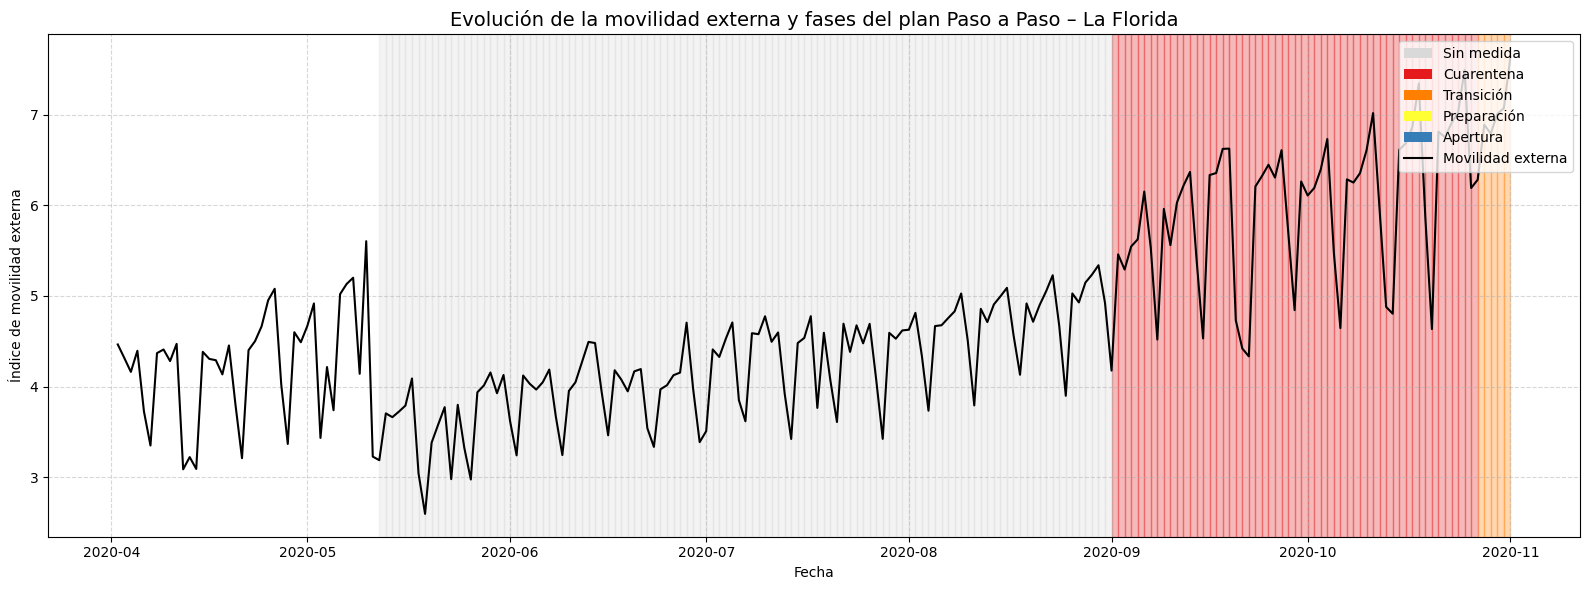

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrar una comuna (ejemplo: 'La Florida')
comuna = 'La Florida'
df_comuna = covid_data[covid_data['Commune'] == comuna].copy()
df_comuna = df_comuna.sort_values('Days')

# Asegurar tipos
df_comuna['Days'] = pd.to_datetime(df_comuna['Days'])

# Mapeo de pasos a colores
step_colors = {
    1: '#d9d9d9',  # Sin medida - gris
    2: '#e41a1c',  # Cuarentena - rojo
    3: '#ff7f00',  # Transición - naranjo
    4: '#ffff33',  # Preparación - amarillo
    5: '#377eb8'   # Apertura - azul
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(16, 6))

# Fase como fondo por tramos
for i in range(1, len(df_comuna)):
    step = df_comuna['Step'].iloc[i]
    date_start = df_comuna['Days'].iloc[i - 1]
    date_end = df_comuna['Days'].iloc[i]
    ax.axvspan(date_start, date_end, color=step_colors.get(step, '#ffffff'), alpha=0.3)

# Línea de movilidad
ax.plot(df_comuna['Days'], df_comuna['External_Mobility_Index'], color='black', label='Movilidad externa')

# Estética
ax.set_title(f"Evolución de la movilidad externa y fases del plan Paso a Paso – {comuna}", fontsize=14)
ax.set_xlabel("Fecha")
ax.set_ylabel("Índice de movilidad externa")
ax.grid(True, linestyle='--', alpha=0.5)

# Leyenda personalizada
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(facecolor=color, label=label)
                   for color, label in zip(step_colors.values(),
                                           ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura'])]
legend_elements.append(plt.Line2D([0], [0], color='black', label='Movilidad externa'))
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


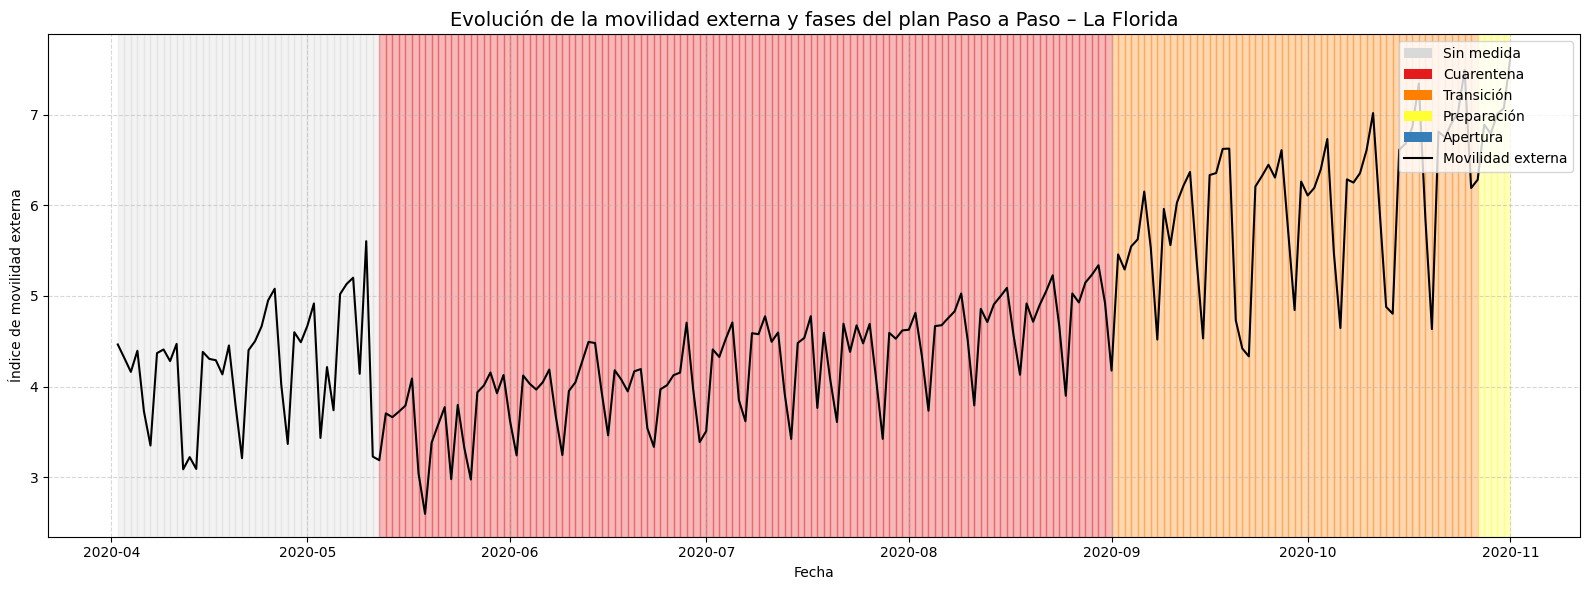

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

# Filtrar una comuna (ejemplo: 'La Florida')
comuna = 'La Florida'
df_comuna = covid_data[covid_data['Commune'] == comuna].copy()
df_comuna = df_comuna.sort_values('Days')

# Asegurar tipos
df_comuna['Days'] = pd.to_datetime(df_comuna['Days'])

# Mapeo correcto de pasos a colores (según codificación real)
step_colors = {
    0: '#d9d9d9',  # Sin medida - gris claro
    1: '#e41a1c',  # Cuarentena - rojo
    2: '#ff7f00',  # Transición - naranjo
    3: '#ffff33',  # Preparación - amarillo
    4: '#377eb8'   # Apertura - azul
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(16, 6))

# Fase como fondo por tramos
for i in range(1, len(df_comuna)):
    step = df_comuna['Step'].iloc[i]
    date_start = df_comuna['Days'].iloc[i - 1]
    date_end = df_comuna['Days'].iloc[i]
    ax.axvspan(date_start, date_end, color=step_colors.get(step, '#ffffff'), alpha=0.3)

# Línea de movilidad
ax.plot(df_comuna['Days'], df_comuna['External_Mobility_Index'], color='black', label='Movilidad externa')

# Estética
ax.set_title(f"Evolución de la movilidad externa y fases del plan Paso a Paso – {comuna}", fontsize=14)
ax.set_xlabel("Fecha")
ax.set_ylabel("Índice de movilidad externa")
ax.grid(True, linestyle='--', alpha=0.5)

# Leyenda personalizada
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='black', label='Movilidad externa'))

ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()


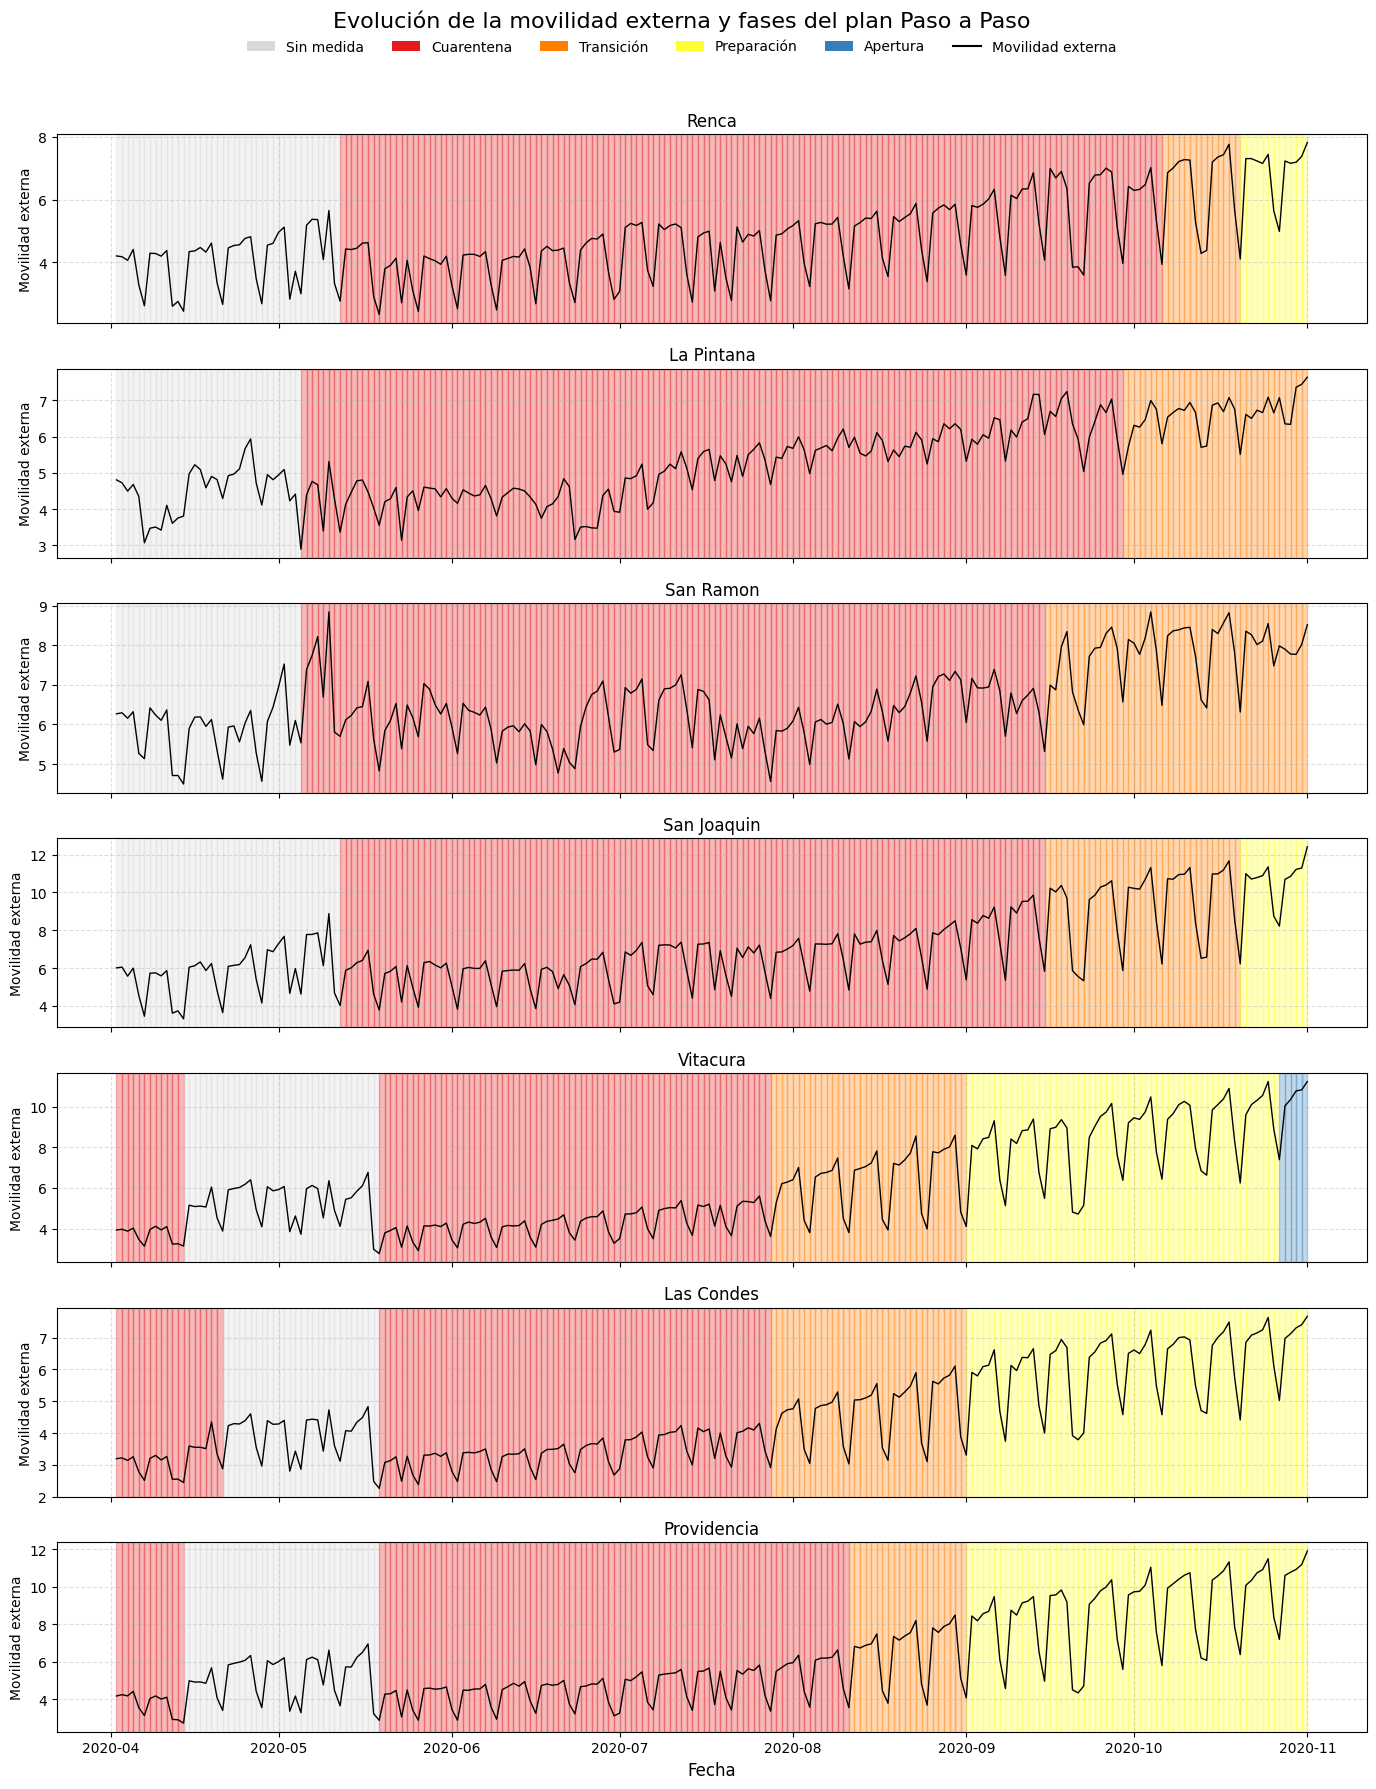

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Comunas a graficar
comunas_seleccionadas = ['Renca', 'La Pintana', 'San Ramon', 'San Joaquin', 'Vitacura', 'Las Condes', 'Providencia']

# Diccionario de colores (según codificación de los pasos)
step_colors = {
    0: '#d9d9d9',  # Sin medida - gris claro
    1: '#e41a1c',  # Cuarentena - rojo
    2: '#ff7f00',  # Transición - naranjo
    3: '#ffff33',  # Preparación - amarillo
    4: '#377eb8'   # Apertura - azul
}

# Crear figura con subplots
n = len(comunas_seleccionadas)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 2.5 * n), sharex=True)

for i, comuna in enumerate(comunas_seleccionadas):
    ax = axes[i]
    
    df_comuna = covid_data[covid_data['Commune'] == comuna].copy()
    df_comuna = df_comuna.sort_values('Days')
    df_comuna['Days'] = pd.to_datetime(df_comuna['Days'])

    # Dibujar fases como fondo
    for j in range(1, len(df_comuna)):
        paso = df_comuna['Step'].iloc[j]
        inicio = df_comuna['Days'].iloc[j - 1]
        fin = df_comuna['Days'].iloc[j]
        ax.axvspan(inicio, fin, color=step_colors.get(paso, '#ffffff'), alpha=0.3)

    # Línea de movilidad externa
    ax.plot(df_comuna['Days'], df_comuna['External_Mobility_Index'], color='black', lw=1)

    ax.set_title(comuna, fontsize=12)
    ax.set_ylabel('Movilidad externa', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

# Etiquetas del eje x solo en el último gráfico
axes[-1].set_xlabel('Fecha', fontsize=12)

# Leyenda personalizada (solo una vez)
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='black', label='Movilidad externa'))

fig.legend(handles=legend_elements, loc='upper center', ncol=6, frameon=False, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Evolución de la movilidad externa y fases del plan Paso a Paso", fontsize=16, y=1.02)
plt.show()


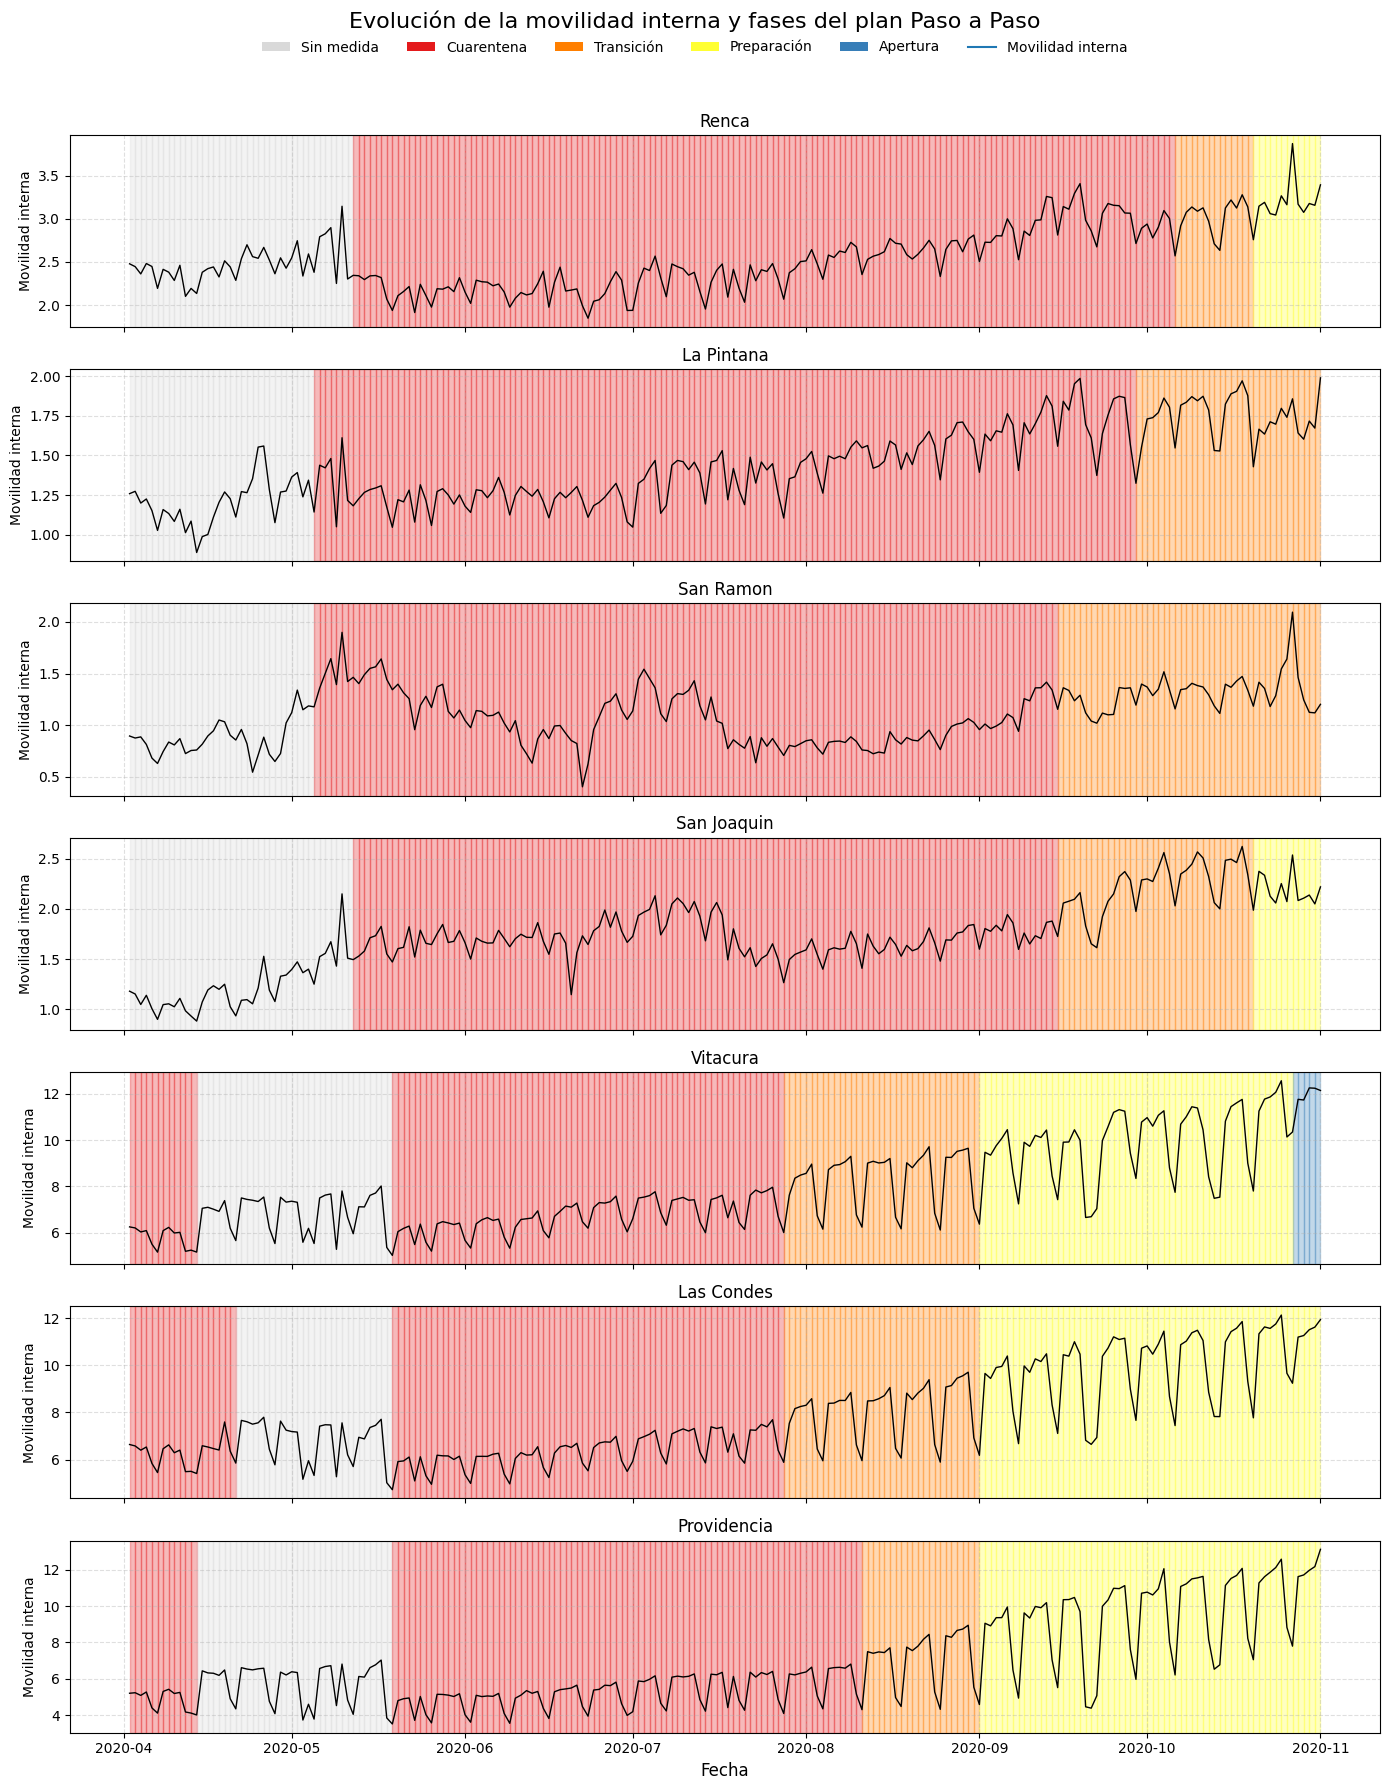

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Comunas seleccionadas
comunas_seleccionadas = ['Renca', 'La Pintana', 'San Ramon', 'San Joaquin', 'Vitacura', 'Las Condes', 'Providencia']

# Colores para las fases del plan Paso a Paso
step_colors = {
    0: '#d9d9d9',  # Sin medida - gris claro
    1: '#e41a1c',  # Cuarentena - rojo
    2: '#ff7f00',  # Transición - naranjo
    3: '#ffff33',  # Preparación - amarillo
    4: '#377eb8'   # Apertura - azul
}

# Crear figura y ejes
n = len(comunas_seleccionadas)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 2.5 * n), sharex=True)

# Loop por comuna
for i, comuna in enumerate(comunas_seleccionadas):
    ax = axes[i]

    df_comuna = covid_data[covid_data['Commune'] == comuna].copy()
    df_comuna = df_comuna.sort_values('Days')
    df_comuna['Days'] = pd.to_datetime(df_comuna['Days'])

    # Fases como fondo
    for j in range(1, len(df_comuna)):
        paso = df_comuna['Step'].iloc[j]
        inicio = df_comuna['Days'].iloc[j - 1]
        fin = df_comuna['Days'].iloc[j]
        ax.axvspan(inicio, fin, color=step_colors.get(paso, '#ffffff'), alpha=0.3)

    # Línea de movilidad interna (azul oscuro)
    ax.plot(df_comuna['Days'], df_comuna['Internal_Mobility_Index'], color='black', lw=1)

    ax.set_title(comuna, fontsize=12)
    ax.set_ylabel('Movilidad interna', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

# Etiqueta x solo en el último subplot
axes[-1].set_xlabel('Fecha', fontsize=12)

# Leyenda común
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='#1f78b4', label='Movilidad interna'))

fig.legend(handles=legend_elements, loc='upper center', ncol=6, frameon=False, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Evolución de la movilidad interna y fases del plan Paso a Paso", fontsize=16, y=1.02)
plt.show()


#### Comportamiento de casos por comunas según Plan Paso a Paso

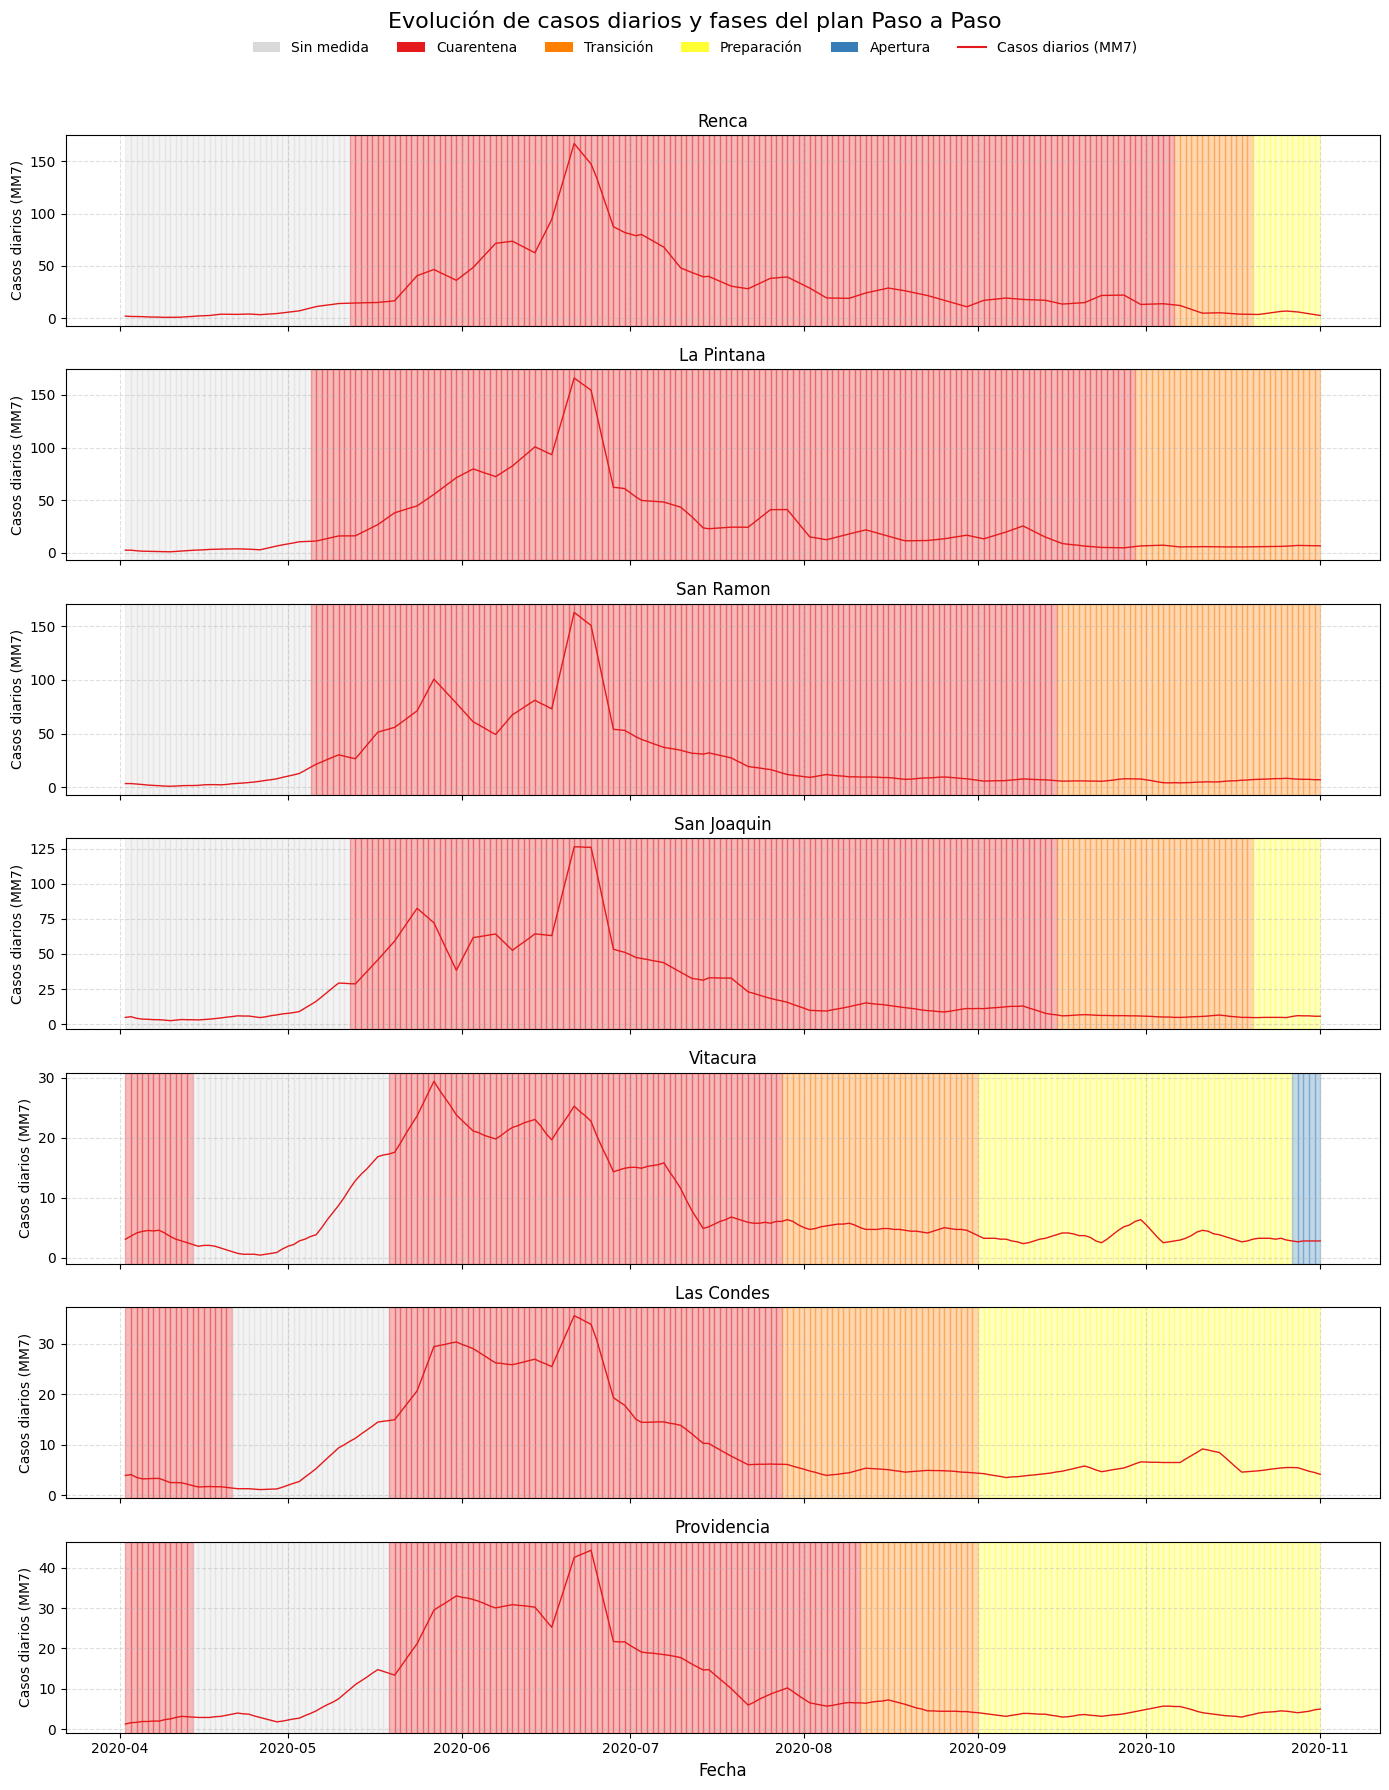

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Comunas seleccionadas
comunas_seleccionadas = ['Renca', 'La Pintana', 'San Ramon', 'San Joaquin', 'Vitacura', 'Las Condes', 'Providencia']

# Colores para las fases del plan Paso a Paso
step_colors = {
    0: '#d9d9d9',  # Sin medida - gris claro
    1: '#e41a1c',  # Cuarentena - rojo
    2: '#ff7f00',  # Transición - naranjo
    3: '#ffff33',  # Preparación - amarillo
    4: '#377eb8'   # Apertura - azul
}

# Crear figura y ejes
n = len(comunas_seleccionadas)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 2.5 * n), sharex=True)

# Loop por comuna
for i, comuna in enumerate(comunas_seleccionadas):
    ax = axes[i]

    df_comuna = covid_data[covid_data['Commune'] == comuna].copy()
    df_comuna = df_comuna.sort_values('Days')
    df_comuna['Days'] = pd.to_datetime(df_comuna['Days'])

    # Fases como fondo
    for j in range(1, len(df_comuna)):
        paso = df_comuna['Step'].iloc[j]
        inicio = df_comuna['Days'].iloc[j - 1]
        fin = df_comuna['Days'].iloc[j]
        ax.axvspan(inicio, fin, color=step_colors.get(paso, '#ffffff'), alpha=0.3)

    # Línea de casos diarios suavizados
    ax.plot(df_comuna['Days'], df_comuna['Gross_Daily_Cases_Mobile_Average_7_Days'], color='#e41a1c', lw=1)

    ax.set_title(comuna, fontsize=12)
    ax.set_ylabel('Casos diarios (MM7)', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

# Etiqueta x solo en el último subplot
axes[-1].set_xlabel('Fecha', fontsize=12)

# Leyenda común
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='#e41a1c', label='Casos diarios (MM7)'))

fig.legend(handles=legend_elements, loc='upper center', ncol=6, frameon=False, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Evolución de casos diarios y fases del plan Paso a Paso", fontsize=16, y=1.02)
plt.show()


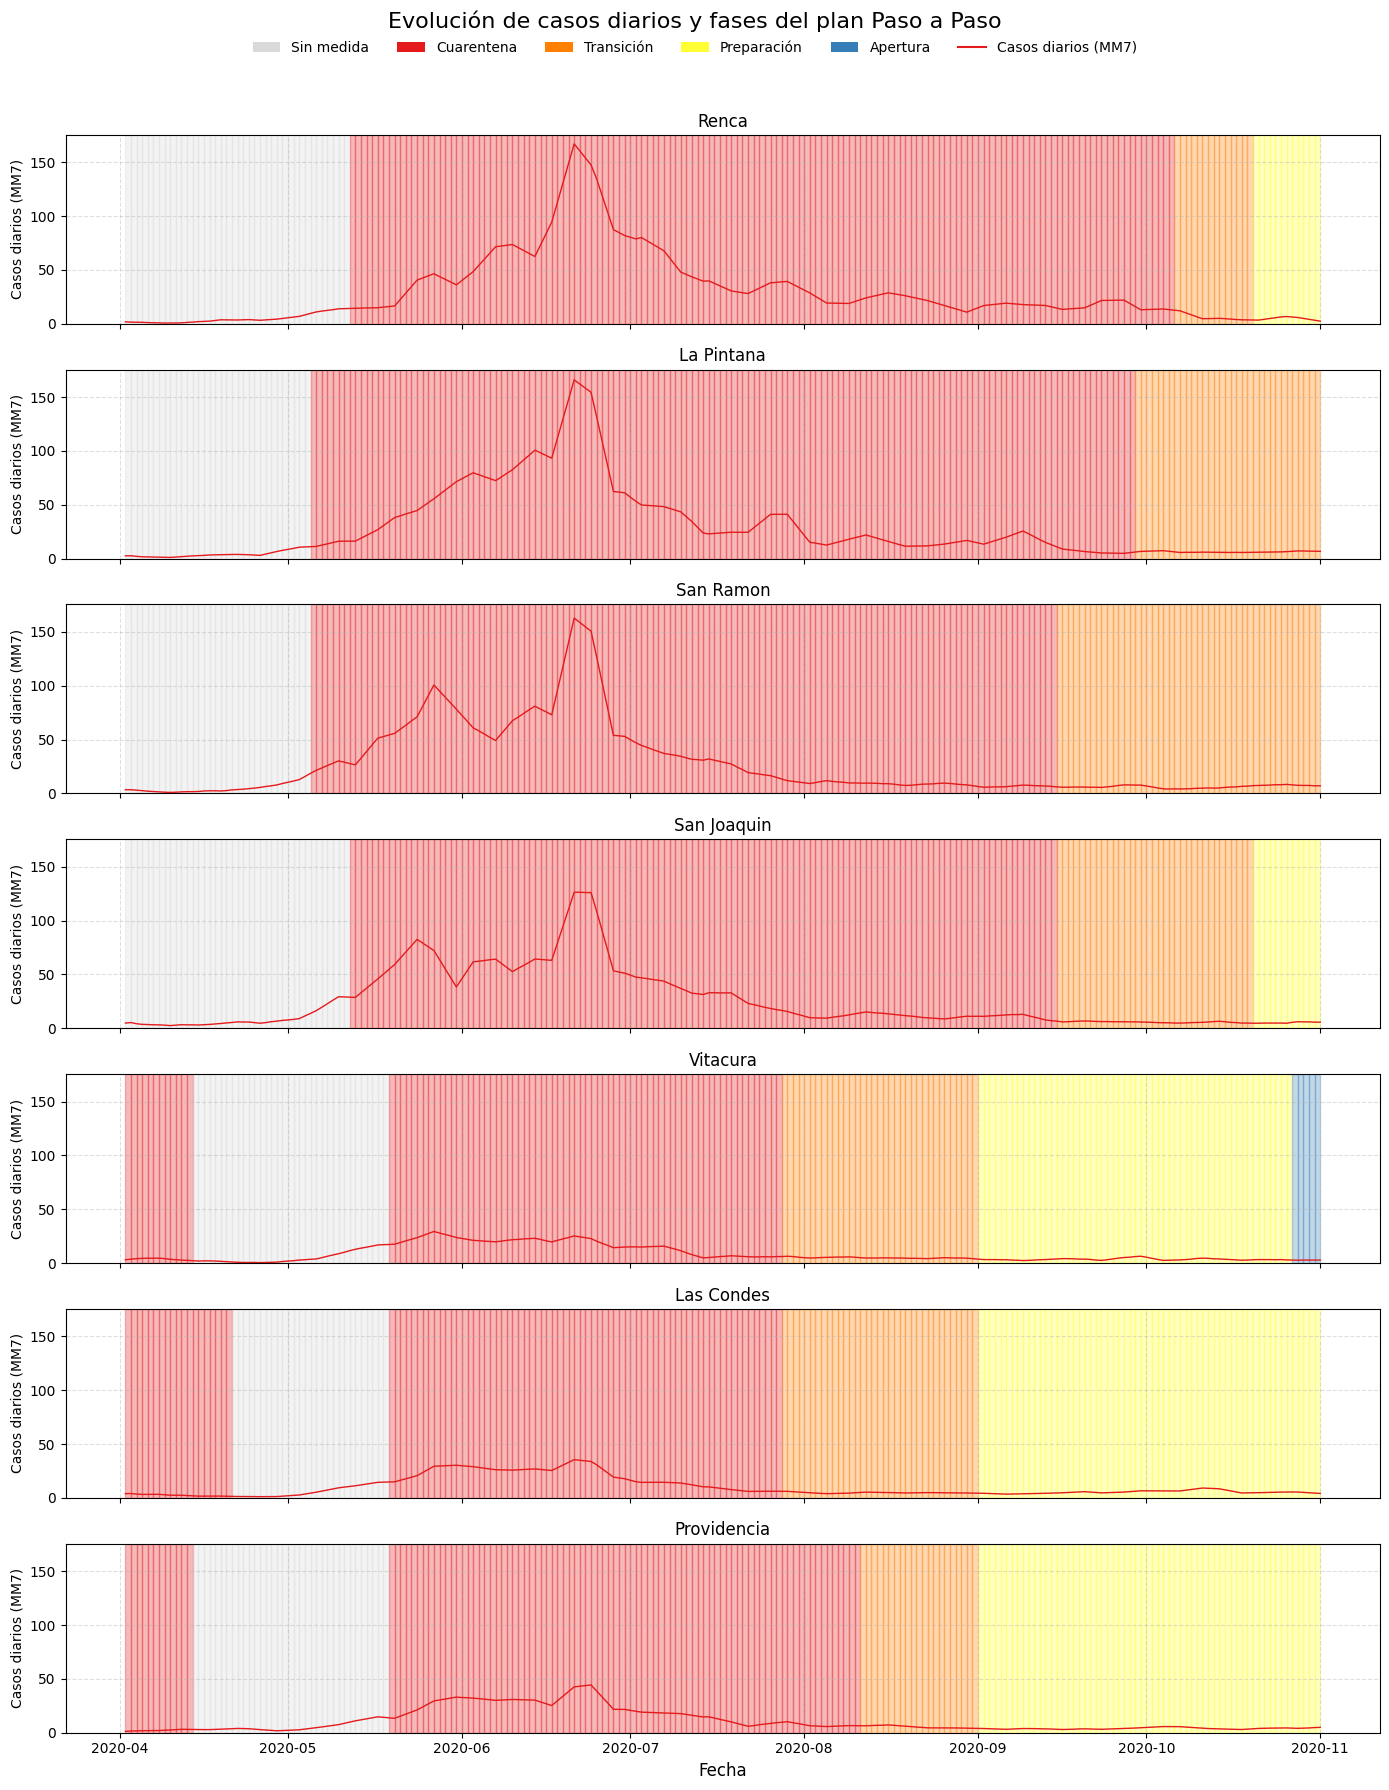

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Comunas seleccionadas
comunas_seleccionadas = ['Renca', 'La Pintana', 'San Ramon', 'San Joaquin', 'Vitacura', 'Las Condes', 'Providencia']

# Colores Paso a Paso
step_colors = {
    0: '#d9d9d9',  # Sin medida
    1: '#e41a1c',  # Cuarentena
    2: '#ff7f00',  # Transición
    3: '#ffff33',  # Preparación
    4: '#377eb8'   # Apertura
}

# Calcular el máximo de casos en todas las comunas seleccionadas
max_casos = covid_data[covid_data['Commune'].isin(comunas_seleccionadas)]['Gross_Daily_Cases_Mobile_Average_7_Days'].max()

# Crear figura
n = len(comunas_seleccionadas)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, 2.5 * n), sharex=True)

# Loop por comuna
for i, comuna in enumerate(comunas_seleccionadas):
    ax = axes[i]
    df = covid_data[covid_data['Commune'] == comuna].copy().sort_values('Days')
    df['Days'] = pd.to_datetime(df['Days'])

    for j in range(1, len(df)):
        paso = df['Step'].iloc[j]
        inicio = df['Days'].iloc[j - 1]
        fin = df['Days'].iloc[j]
        ax.axvspan(inicio, fin, color=step_colors.get(paso, '#ffffff'), alpha=0.3)

    ax.plot(df['Days'], df['Gross_Daily_Cases_Mobile_Average_7_Days'], color='#e41a1c', lw=1)
    ax.set_title(comuna, fontsize=12)
    ax.set_ylabel('Casos diarios (MM7)', fontsize=10)
    ax.set_ylim(0, max_casos * 1.05)  # Eje Y común
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel("Fecha", fontsize=12)

# Leyenda
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='#e41a1c', label='Casos diarios (MM7)'))

fig.legend(handles=legend_elements, loc='upper center', ncol=6, frameon=False, fontsize=10, bbox_to_anchor=(0.5, 1.01))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Evolución de casos diarios y fases del plan Paso a Paso", fontsize=16, y=1.02)
plt.show()


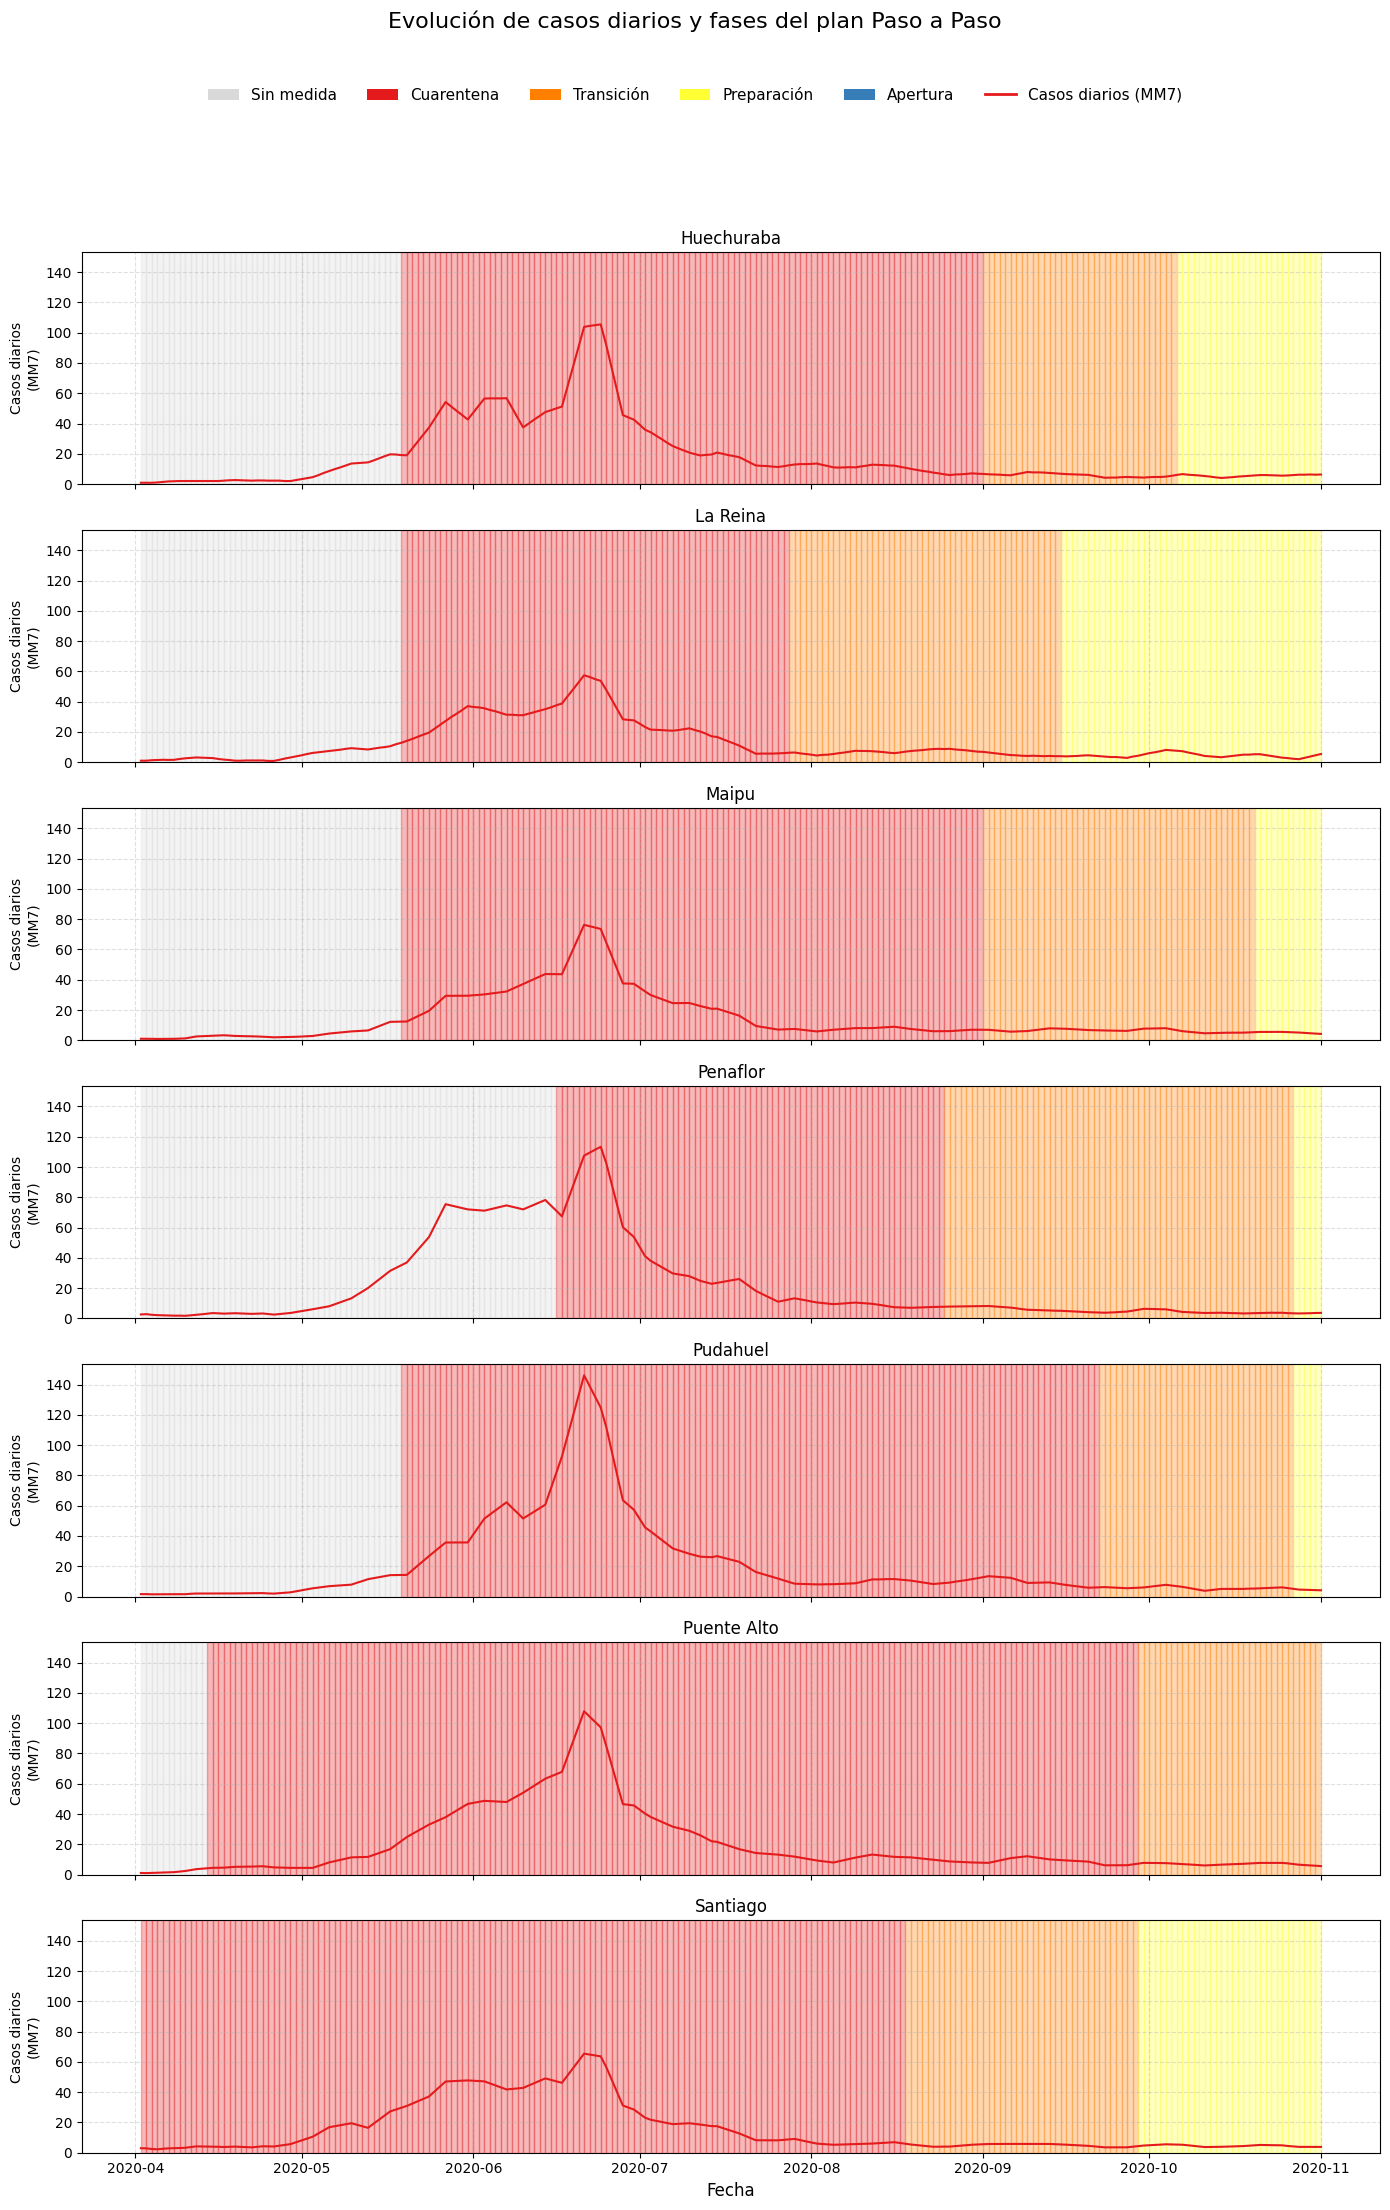

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Comunas seleccionadas (sin tildes)
comunas = ['Huechuraba', 'La Reina', 'Maipu', 'Penaflor', 'Pudahuel', 'Puente Alto', 'Santiago']

# Colores para los pasos corregidos (según tu última aclaración)
step_colors = {
    0: '#d9d9d9',  # Sin medida (gris)
    1: '#e41a1c',  # Cuarentena (rojo)
    2: '#ff7f00',  # Transición (naranjo)
    3: '#ffff33',  # Preparación (amarillo)
    4: '#377eb8'   # Apertura inicial (azul)
}

# Calcular el máximo global de casos para normalizar el eje y
max_val = covid_data[covid_data['Commune'].isin(comunas)]['Gross_Daily_Cases_Mobile_Average_7_Days'].max()

# Crear figura con subplots
fig, axes = plt.subplots(nrows=len(comunas), ncols=1, figsize=(14, 3 * len(comunas)), sharex=True)

# Graficar cada comuna
for i, comuna in enumerate(comunas):
    ax = axes[i]
    df = covid_data[covid_data['Commune'] == comuna].copy().sort_values('Days')
    df['Days'] = pd.to_datetime(df['Days'])

    # Colorear fondo según paso
    for j in range(1, len(df)):
        paso = df['Step'].iloc[j]
        start = df['Days'].iloc[j - 1]
        end = df['Days'].iloc[j]
        ax.axvspan(start, end, color=step_colors.get(paso, '#ffffff'), alpha=0.3)

    # Línea de casos diarios (media móvil 7 días)
    ax.plot(df['Days'], df['Gross_Daily_Cases_Mobile_Average_7_Days'], color='#e41a1c', lw=1.5)

    ax.set_title(comuna, fontsize=12)
    ax.set_ylim(0, max_val * 1.05)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel('Casos diarios\n(MM7)', fontsize=10)

axes[-1].set_xlabel("Fecha", fontsize=12)

# Leyenda personalizada
legend_labels = ['Sin medida', 'Cuarentena', 'Transición', 'Preparación', 'Apertura']
legend_elements = [mpatches.Patch(facecolor=step_colors[i], label=label) for i, label in enumerate(legend_labels)]
legend_elements.append(plt.Line2D([0], [0], color='#e41a1c', lw=2, label='Casos diarios (MM7)'))

fig.legend(handles=legend_elements, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02), fontsize=11, frameon=False)

plt.suptitle("Evolución de casos diarios y fases del plan Paso a Paso", fontsize=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Definition of HMM model formulas:

Create `ntimes` from clean data

In [30]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


### Convert to R format:

In [31]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

The transition probabilities between states depend on the covariates ‘IM_internal’, ‘IM_external’ and the commune

In [32]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

### Creation of the HMM model:

In [33]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


## Model adjustment:

In [34]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)


converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



## Extract sequence of states (Viterbi) and join with data:

In [35]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

### Merged with the original data:

In [36]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638054e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...                Priority_2020   Code  Year  \
0            

In [37]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)


## Visualizations:

### Viterbi Sequence:

In [38]:
viterbi_merged.head()

state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638054e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...   Code  Year  Month Step    Step_Label  \
0                   3.145581  ...  13102  2020      3    0  Unrestricted   
1                   3.145581  ...  13102  2020      4    0  Unrestricted   
2                   3.145581  ...  13102  2020      4    0  Unrestricted   
3                   3.145581  ...  13102  2020      4    0  Unrestricted   
4                   3.145581  ...  13102  2020      4    0  Unrestricted   

  Quarantine_Start_Date  Quarantine_End_Date  Gross_Daily_Cases  \
0            2020-05-05           2020-08-31           2.248303   
1            2020-05-05           2020-08-31           2.248303   
2            2020-05-05           2020-08-31           0.000000   
3            2020-05-05           2020-08-31           0.000000   
4            2020-05-05           2020-08-31           0.000000   

   Gross_Daily_Cases_Mobile_Average_7_Days Reordened_state  
0                                 2.248303               1  
1                                 2.248303               1  
2                                 1.498868               1  
3                                 1.124151               1  
4                                 0.899321               1  

[5 rows x 30 columns]

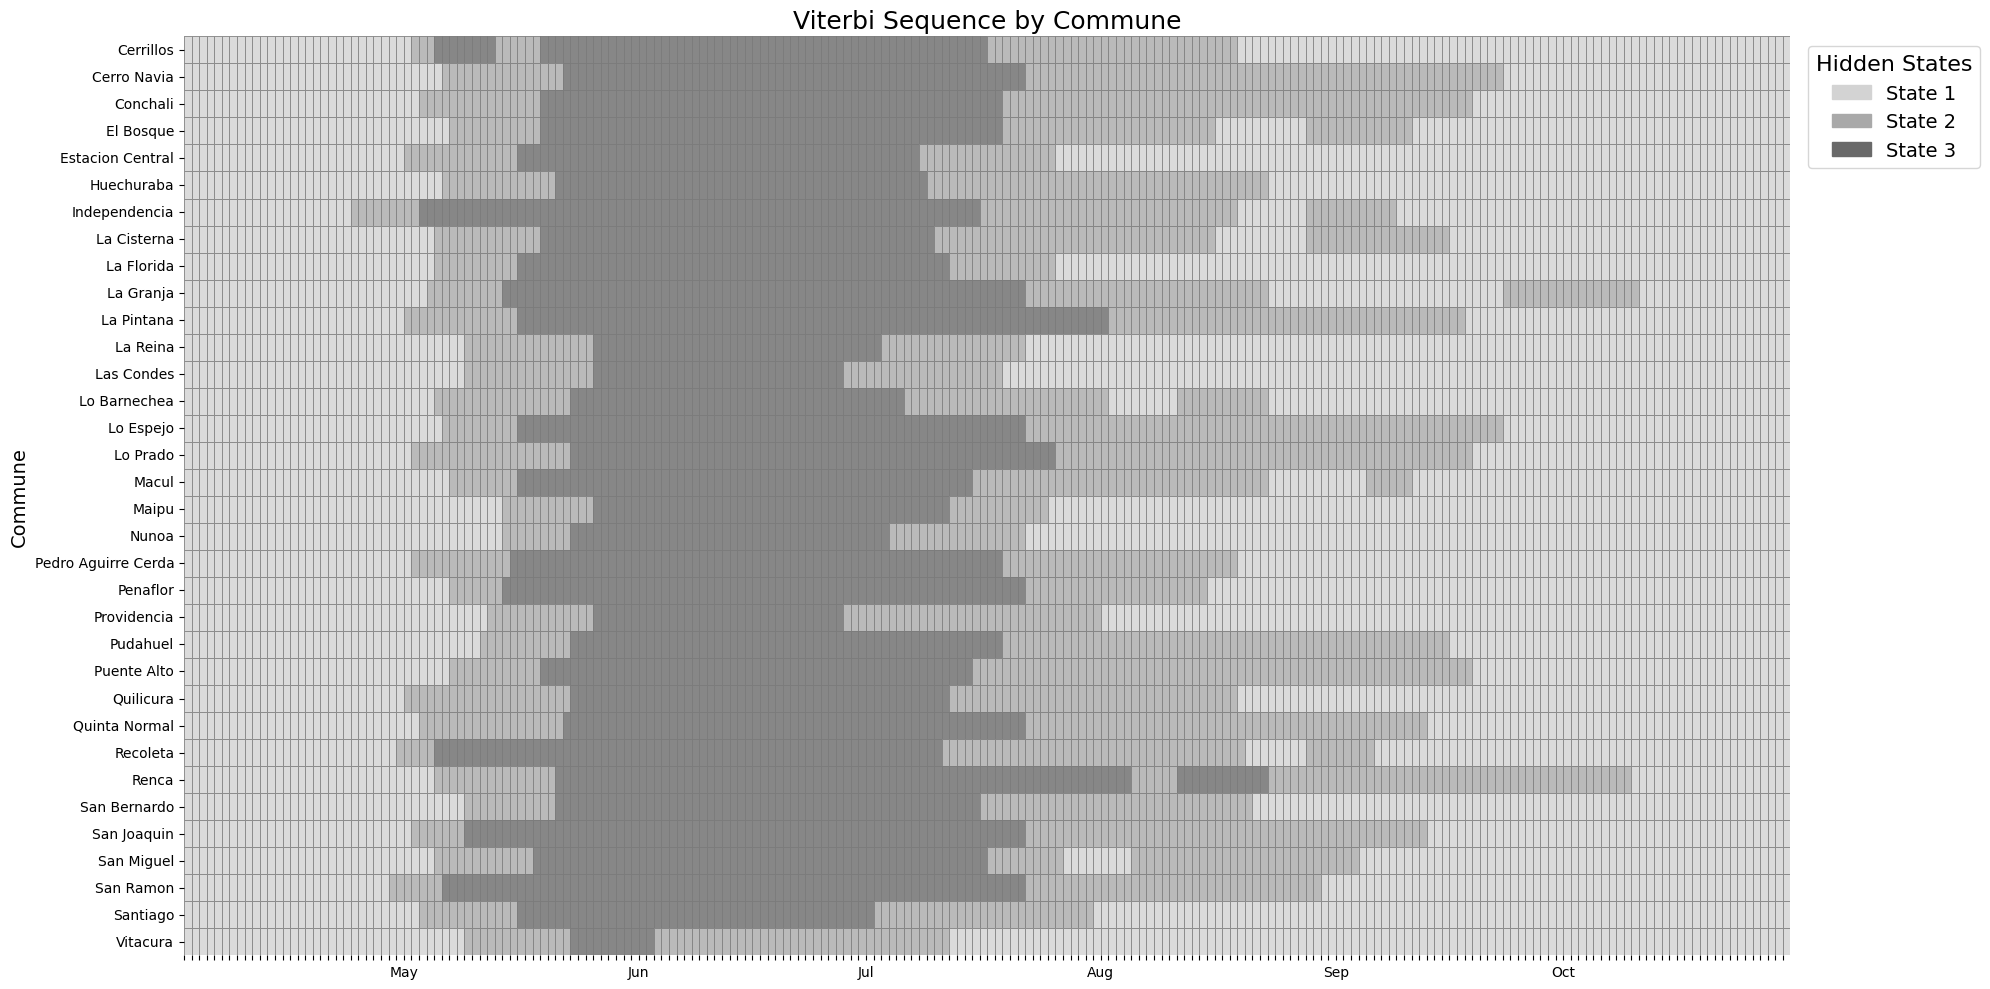

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Definir el rango de fechas a considerar
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in viterbi_pivot.columns if min_date <= col <= max_date]
viterbi_pivot = viterbi_pivot[filtered_columns]

# Colores personalizados (en escala de grises, puedes cambiar por otros si prefieres)
custom_colors = ['#D3D3D3', '#A9A9A9', '#696969']  # Light gray, Medium gray, Dark gray

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.8,
    cbar=False,
    ax=ax
)

# Etiquetas del eje Y
ax.set_ylabel("Commune", fontsize=14)
ax.set_xlabel(None)

# Etiquetas del eje X: mostrar solo nombre del mes si es el primer día del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_labels = ['State 1', 'State 2', 'State 3']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

plt.legend(
    handles=legend_handles,
    title="Hidden States",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Viterbi Sequence by Commune', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


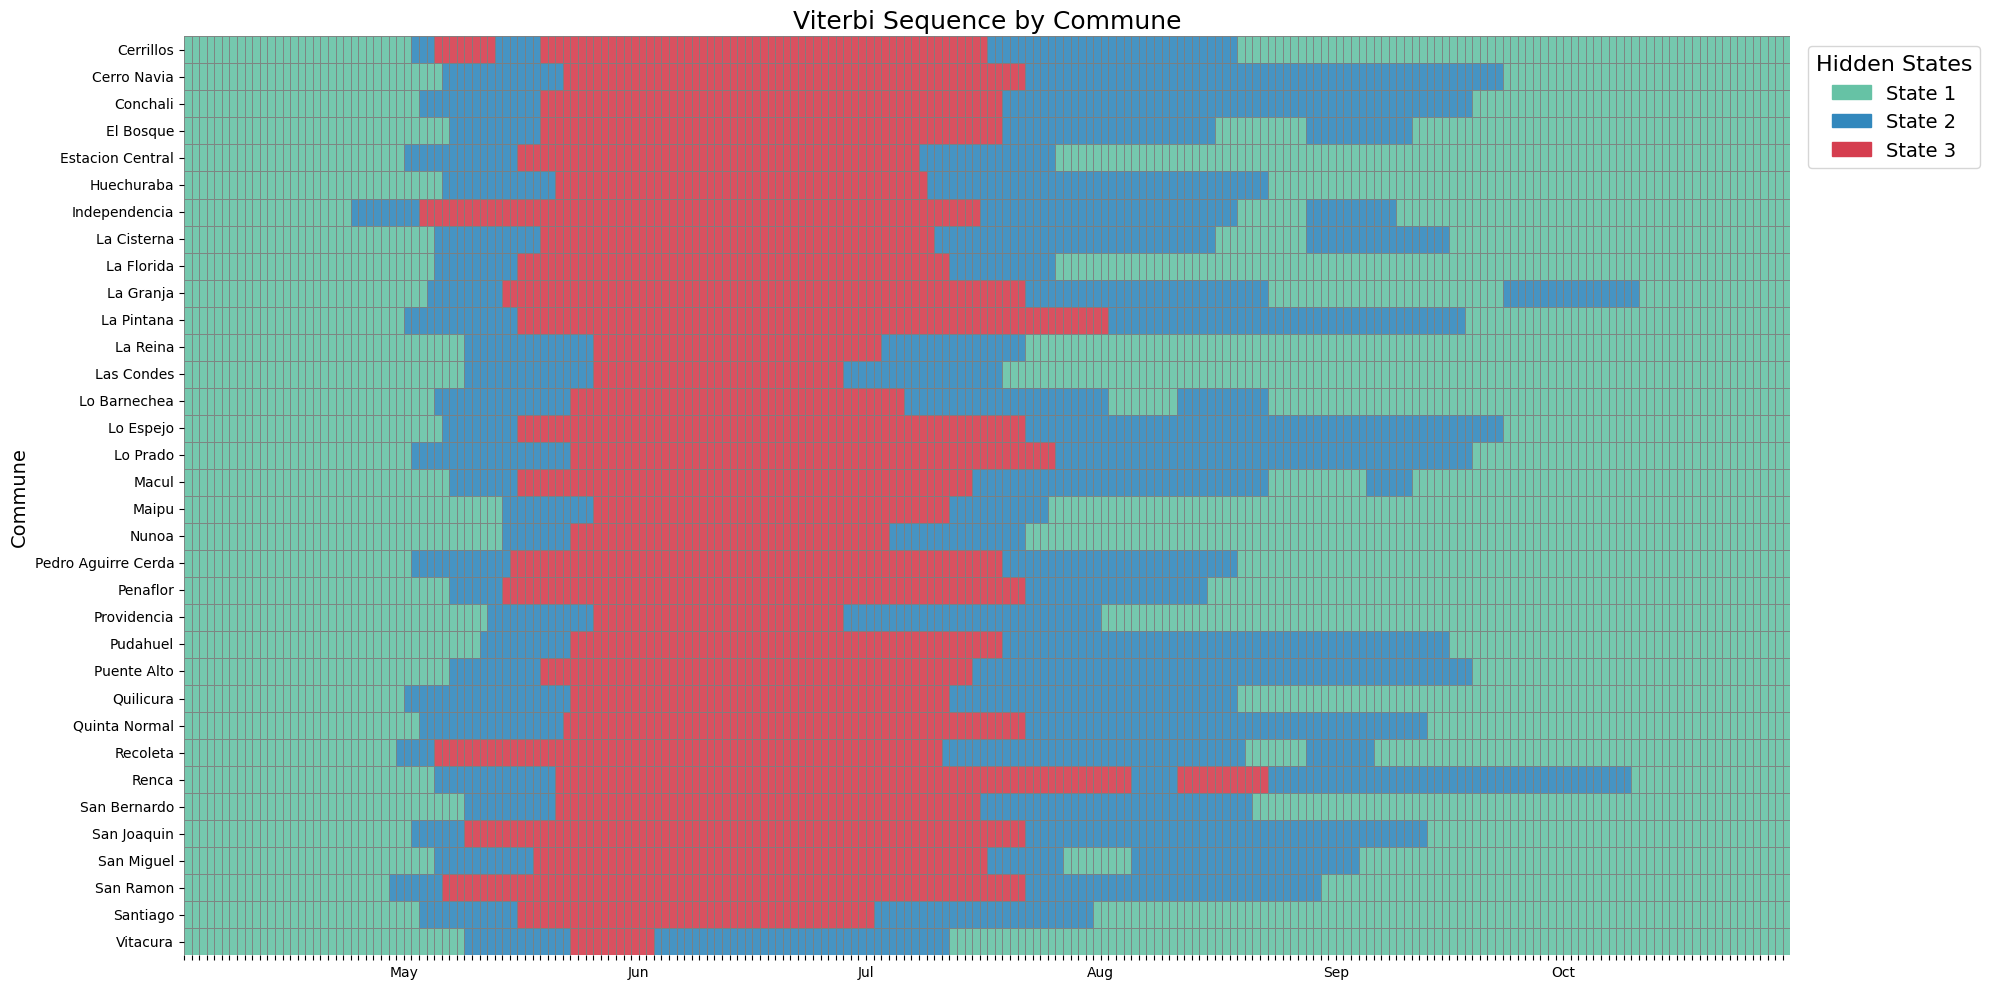

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Crear la tabla pivotada
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Definir el rango de fechas a considerar
min_date = pd.Timestamp('2020-03-31')
max_date = pd.Timestamp('2020-10-30')

# Filtrar columnas dentro del rango de fechas
filtered_columns = [col for col in viterbi_pivot.columns if min_date <= col <= max_date]
viterbi_pivot = viterbi_pivot[filtered_columns]

# Colores estilo "Nature" / ColorBrewer
custom_colors = ['#66c2a5', '#3288bd', '#d53e4f']  # Estado 1, 2, 3

# Crear el heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    cmap=sns.color_palette(custom_colors, as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9,
    cbar=False,
    ax=ax
)

# Etiquetas del eje Y
ax.set_ylabel("Commune", fontsize=14)
ax.set_xlabel(None)

# Etiquetas del eje X: mostrar solo nombre del mes si es el primer día del mes
tick_positions = list(range(len(filtered_columns)))
tick_labels = [
    date.strftime('%b') if date.day == 1 else ''
    for date in filtered_columns
]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, fontsize=10)

# Crear leyenda personalizada
legend_labels = ['State 1', 'State 2', 'State 3']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

plt.legend(
    handles=legend_handles,
    title="Hidden States",
    bbox_to_anchor=(1.005, 1),
    loc='upper left',
    fontsize=14,
    title_fontsize=16
)

# Título del gráfico
plt.title('Viterbi Sequence by Commune', fontsize=18)

# Ajustar diseño
plt.tight_layout()
plt.show()


# Characterization of Hidden States:

In [41]:
eda_data = viterbi_merged[['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']]


In [42]:
# Variables que queremos graficar
variables = ['Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

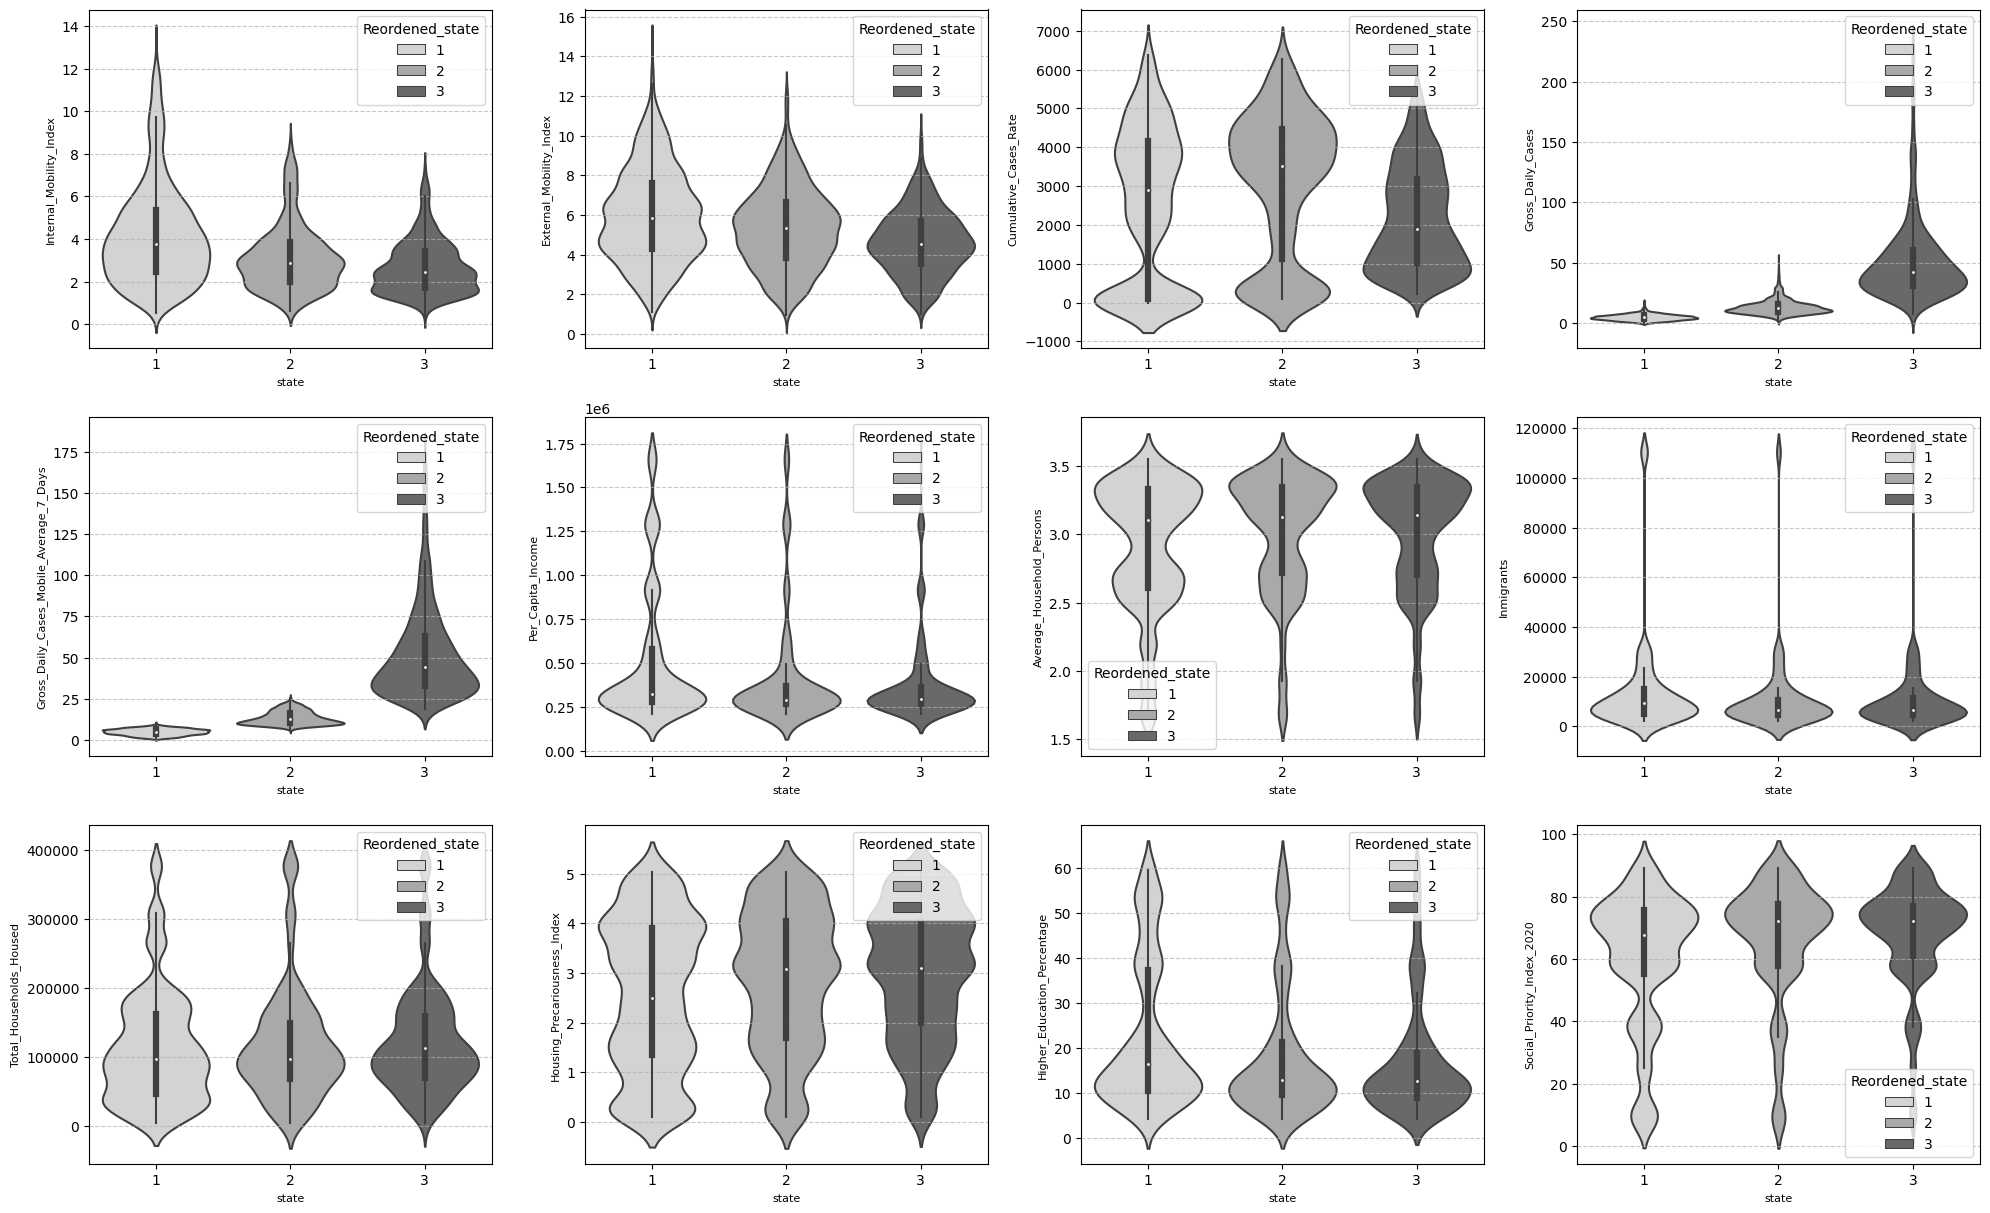

In [43]:
# Convertir la columna 'state' a cadenas con formato flotante
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Violinplots:
custom_palette = {
    '1': '#D3D3D3',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Ajusta el tamaño total

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los violintplots para cada variable sin leyendas individuales:
for i, var in enumerate(variables):
    sns.violinplot(data=eda_data, x='Reordened_state', y=var, hue='Reordened_state', palette=custom_palette, ax=axes[i], dodge=False)
    #axes[i].legend_.remove()  # Eliminar leyenda individual
    #axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)


# Eliminar cualquier subplot sobrante si hay más ejes que gráficos
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

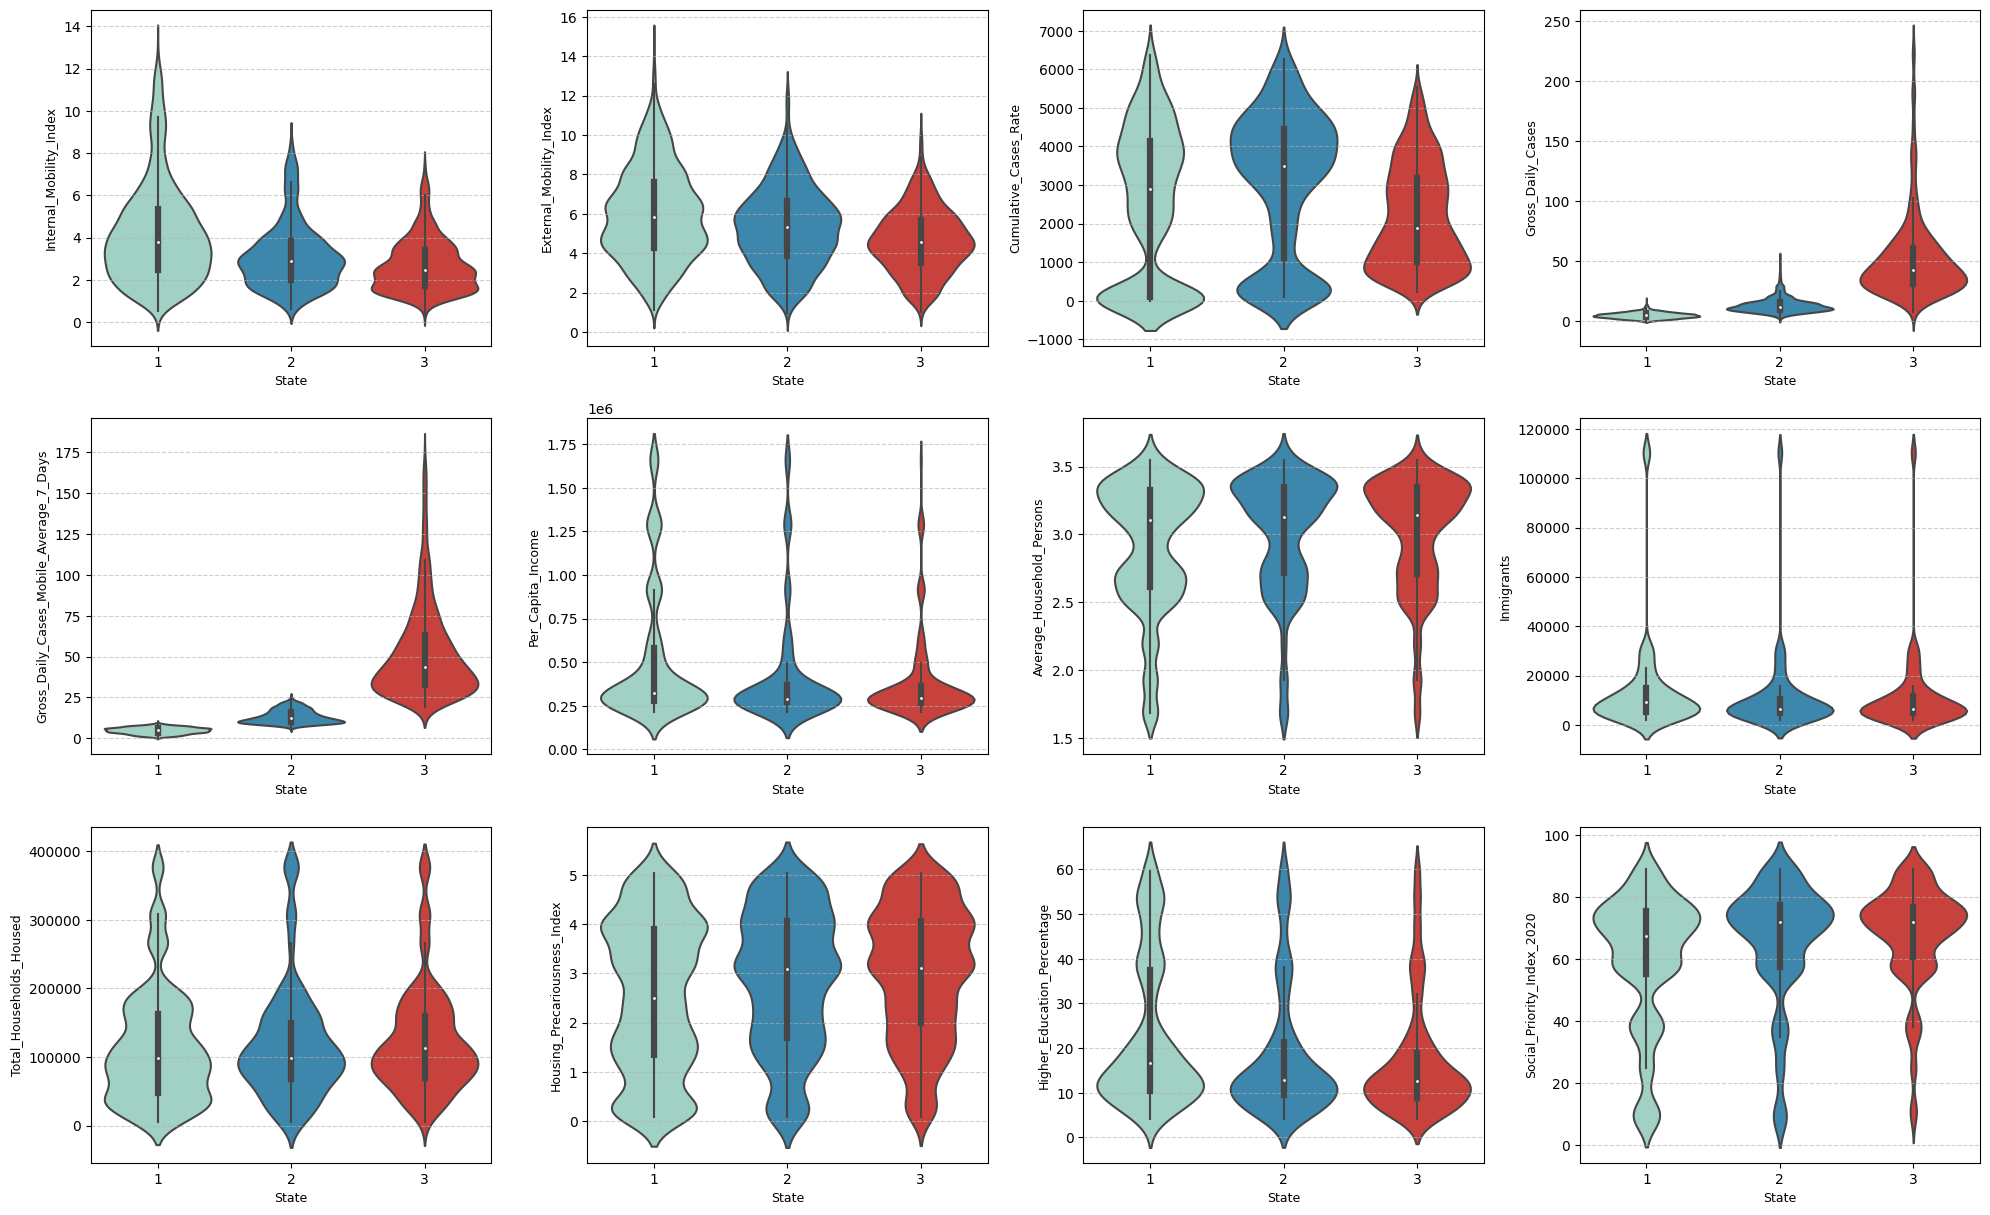

In [44]:
# Convertir la columna 'state' a cadenas con formato flotante
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Nueva paleta de colores basada en el heatmap de Viterbi
custom_palette = {
    '1': '#99d8c9',  # Estado 1 - leve (verde agua)
    '2': '#2b8cbe',  # Estado 2 - moderado (azul)
    '3': '#de2d26'   # Estado 3 - severo (rojo)
}

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Tamaño ajustado

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los violinplots para cada variable
for i, var in enumerate(variables):
    sns.violinplot(
        data=eda_data, 
        x='Reordened_state', 
        y=var, 
        hue='Reordened_state', 
        palette=custom_palette, 
        ax=axes[i], 
        dodge=False
    )
    axes[i].legend_.remove()  # Eliminar leyenda individual
    axes[i].set_xlabel('State', fontsize=9)
    axes[i].set_ylabel(var, fontsize=9)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# Eliminar subplots vacíos si hay más ejes que variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio general del layout
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd

# Lista de variables corregidas según tus columnas reales
variables_violines = [
    'Gross_Daily_Cases_Mobile_Average_7_Days',
    'Gross_Daily_Cases',
    'Internal_Mobility_Index',
    'External_Mobility_Index',
    'Per_Capita_Income',
    'Average_Household_Persons',
    'Inmigrants',
    'Total_Households_Housed',
    'Housing_Precariousness_Index',
    'Higher_Education_Percentage',
    'Social_Priority_Index_2020'
]

# Calcular los estadígrafos por estado oculto
summary_stats = []

for var in variables_violines:
    stats = eda_data.groupby('Reordened_state')[var].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
        lambda x: x.quantile(0.75) - x.quantile(0.25)
    ])
    stats.columns = ['n', 'media', 'mediana', 'DE', 'mínimo', 'máximo', 'Q1', 'Q3', 'RIC']
    stats['variable'] = var
    summary_stats.append(stats)

# Unir resultados
summary_df = pd.concat(summary_stats).reset_index()

# Reordenar columnas para claridad
summary_df = summary_df[['variable', 'Reordened_state', 'n', 'media', 'mediana', 'DE', 'mínimo', 'Q1', 'Q3', 'RIC', 'máximo']]

# Mostrar tabla final
summary_df


variable Reordened_state     n  \
0   Gross_Daily_Cases_Mobile_Average_7_Days               1  3493   
1   Gross_Daily_Cases_Mobile_Average_7_Days               2  1834   
2   Gross_Daily_Cases_Mobile_Average_7_Days               3  1949   
3                         Gross_Daily_Cases               1  3493   
4                         Gross_Daily_Cases               2  1834   
5                         Gross_Daily_Cases               3  1949   
6                   Internal_Mobility_Index               1  3493   
7                   Internal_Mobility_Index               2  1834   
8                   Internal_Mobility_Index               3  1949   
9                   External_Mobility_Index               1  3493   
10                  External_Mobility_Index               2  1834   
11                  External_Mobility_Index               3  1949   
12                        Per_Capita_Income               1  3493   
13                        Per_Capita_Income               2  1834   
14                        Per_Capita_Income               3  1949   
15                Average_Household_Persons               1  3493   
16                Average_Household_Persons               2  1834   
17                Average_Household_Persons               3  1949   
18                               Inmigrants               1  3493   
19                               Inmigrants               2  1834   
20                               Inmigrants               3  1949   
21                  Total_Households_Housed               1  3493   
22                  Total_Households_Housed               2  1834   
23                  Total_Households_Housed               3  1949   
24             Housing_Precariousness_Index               1  3493   
25             Housing_Precariousness_Index               2  1834   
26             Housing_Precariousness_Index               3  1949   
27              Higher_Education_Percentage               1  3493   
28              Higher_Education_Percentage               2  1834   
29              Higher_Education_Percentage               3  1949   
30               Social_Priority_Index_2020               1  3493   
31               Social_Priority_Index_2020               2  1834   
32               Social_Priority_Index_2020               3  1949   

            media        mediana             DE         mínimo             Q1  \
0        4.911165       4.973671       1.933434       0.399693       3.533974   
1       13.431337      12.429146       4.026658       5.976945      10.119971   
2       52.339664      43.936877      27.913031      18.949978      32.543545   
3        5.056503       4.837359       2.444613       0.000000       3.285190   
4       13.544502      12.239203       6.047238       1.994973       9.533028   
5       52.115166      42.740034      34.521586       7.496308      30.776364   
6        4.236591       3.780322       2.390730       0.544551       2.459249   
7        3.150077       2.895794       1.557867       0.635662       2.002545   
8        2.698699       2.455210       1.254624       0.403075       1.706218   
9        6.011209       5.856697       2.353286       1.123766       4.269280   
10       5.347341       5.343473       2.003800       0.965216       3.856956   
11       4.629883       4.552232       1.612772       1.027685       3.509626   
12  518166.721291  324016.690000  388124.426318  211826.830000  280363.720000   
13  424786.698833  290623.380000  325011.639762  211826.830000  270071.810000   
14  385986.679277  297526.340000  245913.772952  211826.830000  267197.560000   
15       2.911493       3.104406       0.475882       1.684778       2.609088   
16       3.009746       3.125893       0.433202       1.684778       2.715172   
17       3.015614       3.145581       0.414388       1.684778       2.704998   
18   13893.097624    9219.000000   19988.703057    2127.000000    5047.000000   
19   11284.911123    6520.000000   16639.706538    2127.000000    47

#### Number of days per state for each commune

In [46]:
state_count = viterbi_merged.groupby(['Commune', 'Reordened_state']).size().reset_index(name='Days')

In [47]:
state_count[state_count['Commune']=='Vitacura'].sort_values(by='Days', ascending=False)

Commune  Reordened_state  Days
99   Vitacura                1   150
100  Vitacura                2    53
101  Vitacura                3    11

In [48]:
state_count[state_count['Commune']=='La Pintana'].sort_values(by='Days', ascending=False)

Commune  Reordened_state  Days
32  La Pintana                3    78
30  La Pintana                1    74
31  La Pintana                2    62

In [49]:
state_count.head()

Commune  Reordened_state  Days
0    Cerrillos                1   105
1    Cerrillos                2    42
2    Cerrillos                3    67
3  Cerro Navia                1    74
4  Cerro Navia                2    79

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.fram

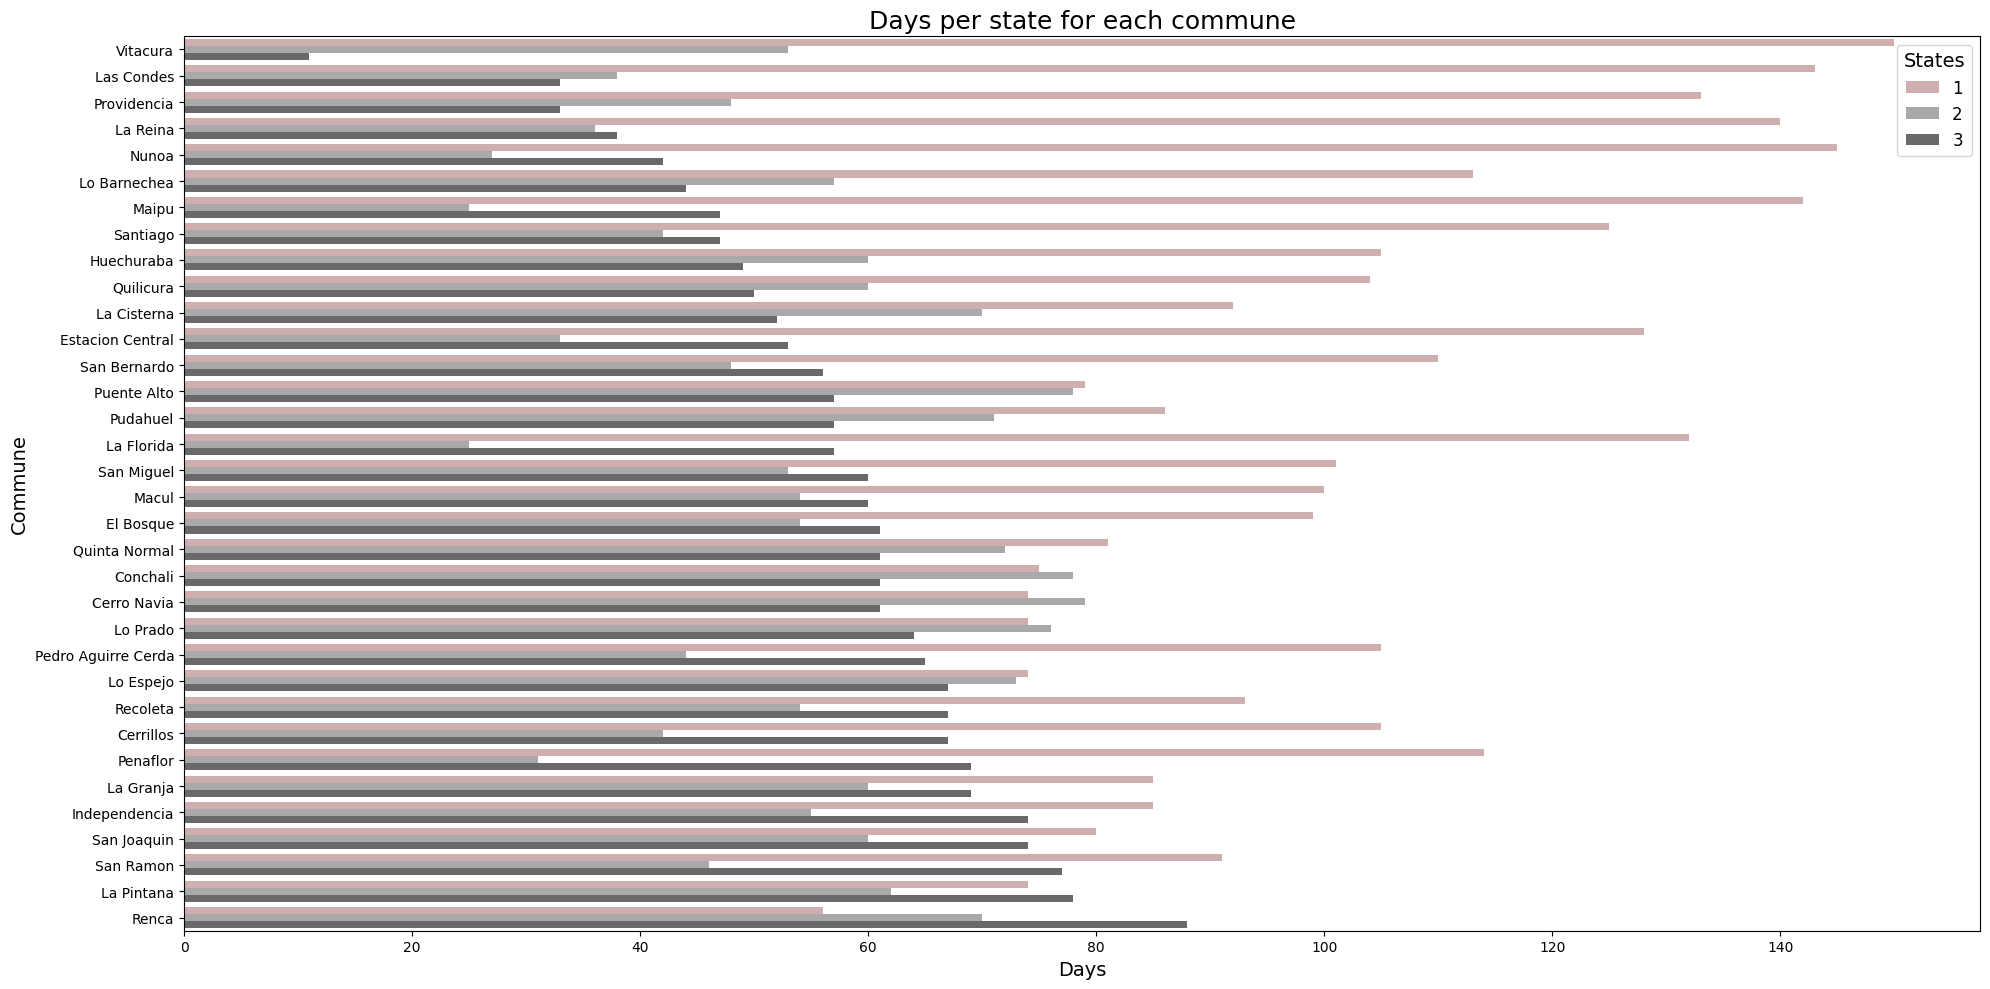

In [50]:
# Aggregate the data to count the total "Days" for state 3 (Reordened_state == 3) per commune
state_3_counts = state_count[state_count['Reordened_state'] == 3].groupby('Commune')['Days'].sum().sort_values()

# Use the sorted order of communes in the state_count DataFrame
sorted_communes = state_3_counts.index

# Sort the original data frame by this order
state_count_sorted = state_count.copy()
state_count_sorted['Commune'] = pd.Categorical(state_count_sorted['Commune'], categories=sorted_communes, ordered=True)
state_count_sorted = state_count_sorted.sort_values('Commune')

# Create the barplot:
plt.figure(figsize=(20, 10))
custom_palette = {
    '1': '#D3A9A9',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}
custom_colors = ['#D3A9A9', '#A9A9A9', '#696969']  # Light gray, medium gray, and dark gray

sns.barplot(
    data=state_count_sorted, 
    x='Days', 
    y='Commune', 
    orient='h', 
    hue='Reordened_state', 
    palette=custom_colors, 
    dodge=True
)

# Add title, labels, and legend
plt.title('Days per state for each commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)
plt.xticks()
plt.legend(title='States', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Library/Frameworks/Python.fram

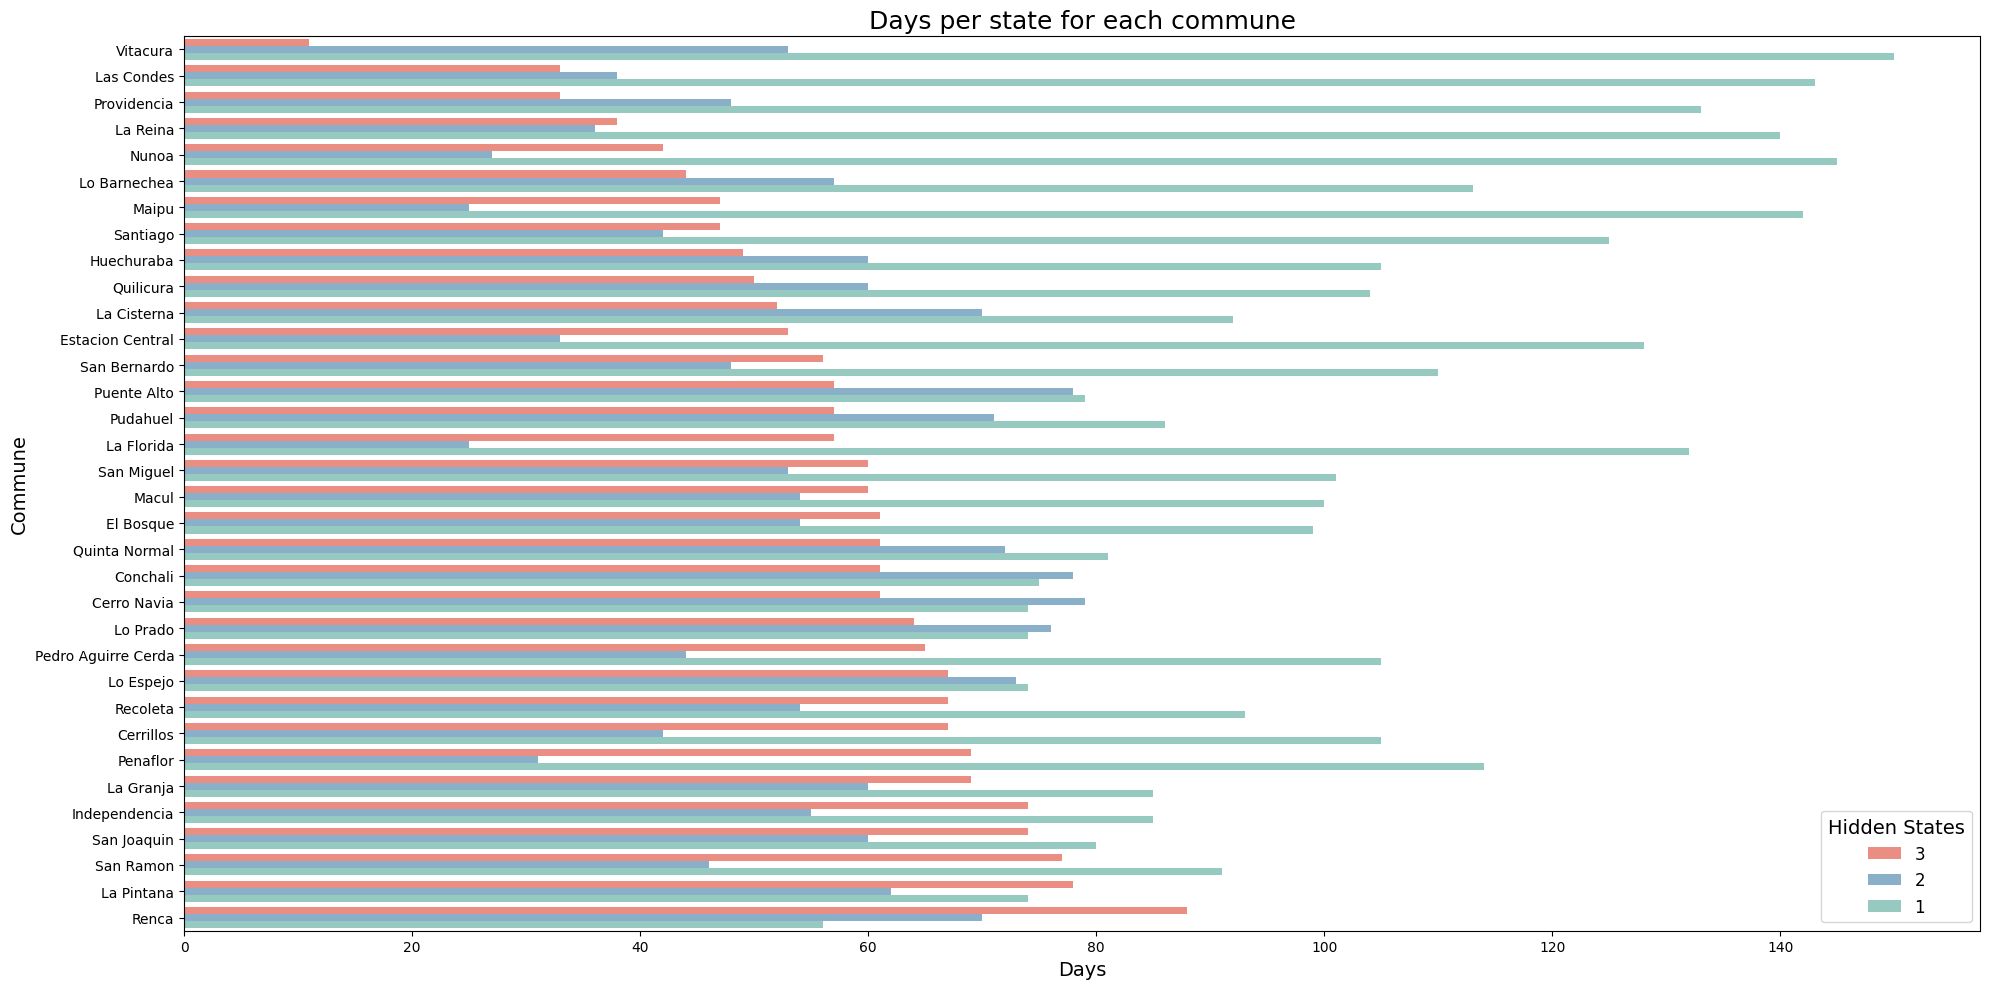

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar y ordenar las comunas según la cantidad de días en estado 3 (severo)
state_3_counts = state_count[state_count['Reordened_state'] == 3].groupby('Commune')['Days'].sum().sort_values()
sorted_communes = state_3_counts.index

# Reordenar la columna 'Commune' con las comunas ordenadas
state_count_sorted = state_count.copy()
state_count_sorted['Commune'] = pd.Categorical(state_count_sorted['Commune'], categories=sorted_communes, ordered=True)
state_count_sorted = state_count_sorted.sort_values('Commune')

# Convertir estado a string si no lo está
state_count_sorted['Reordened_state'] = state_count_sorted['Reordened_state'].astype(str)

# Definir la paleta de colores personalizada (como en el heatmap)
custom_palette = {
    '1': '#8dd3c7',  # State 1 (leve) – verde agua
    '2': '#80b1d3',  # State 2 (moderado) – azul
    '3': '#fb8072'   # State 3 (severo) – rojo salmón
}

# Crear el gráfico de barras
plt.figure(figsize=(20, 10))
sns.barplot(
    data=state_count_sorted,
    x='Days',
    y='Commune',
    orient='h',
    hue='Reordened_state',
    palette=custom_palette,
    dodge=True
)

# Ajustar títulos y etiquetas
plt.title('Days per state for each commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)
plt.legend(title='Hidden States', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


In [52]:
print(covid_data.columns)  # asegúrate que esté 'Commune' aquí


Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'row_id'],
      dtype='object')


In [53]:
covid_data['Step_Label'].unique()

array(['Unrestricted', 'Quarantine', 'Transition', 'Preparation',
       'Opening'], dtype=object)

In [54]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create contingency table for Step Label and Hidden State
contingency_table = pd.crosstab(viterbi_merged['Step_Label'], viterbi_merged['Reordened_state'])

# Perform Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)


Chi-Square Test Statistic: 4020.8954782946525
P-value: 0.0
Degrees of Freedom: 8
Expected Frequencies:
[[2.40035734e+00 1.26030786e+00 1.33933480e+00]
 [3.19727598e+02 1.67873007e+02 1.78399395e+02]
 [2.00957916e+03 1.05512974e+03 1.12129109e+03]
 [5.89527763e+02 3.09531611e+02 3.28940627e+02]
 [5.71765118e+02 3.00205333e+02 3.19029549e+02]]


- Statistical Significance: The extremely high test statistic and p-value of 0.0 indicate a strong relationship between the "Step by Step Plan" and "Hidden States".

- Practical Insight: This result suggests that the "Step by Step Plan" phases influence the likelihood of being in particular "Hidden States." For instance, stricter or prolonged steps may correlate with being in "moderate" or "severe" states for longer durations.

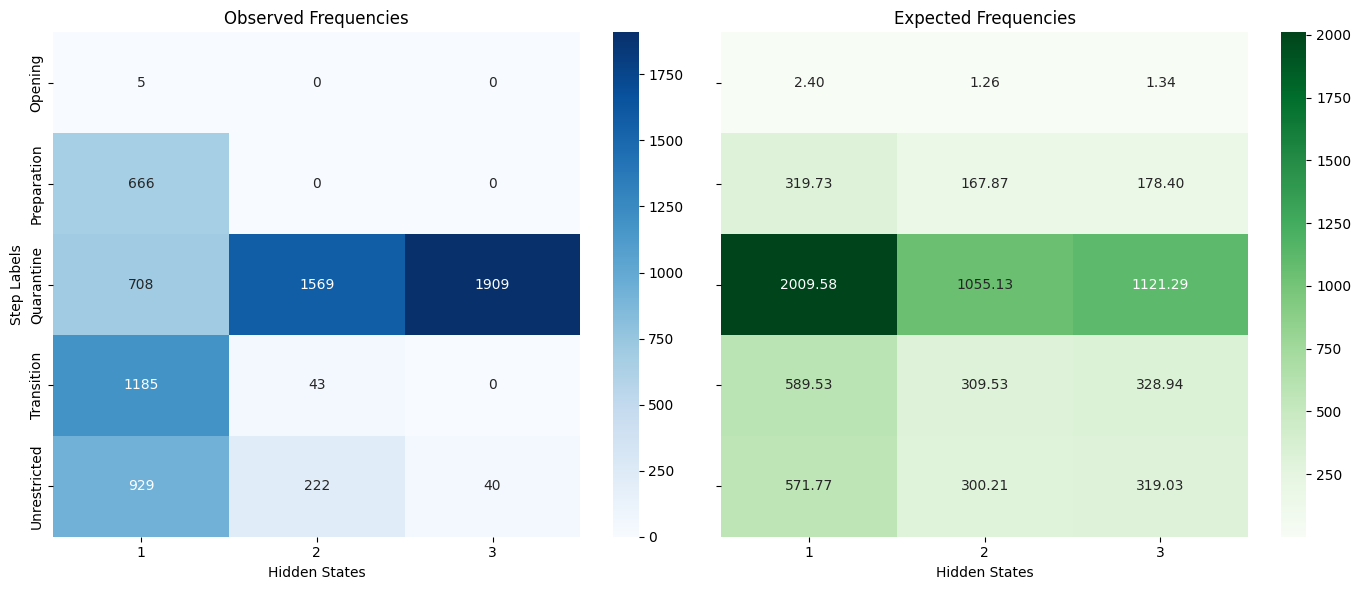

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example observed and expected frequencies
observed_frequencies = pd.crosstab(viterbi_merged['Step_Label'], viterbi_merged['Reordened_state'])
expected_frequencies = pd.DataFrame(expected, index=observed_frequencies.index, columns=observed_frequencies.columns)

# Create a figure with two heatmaps: observed and expected frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Heatmap for observed frequencies
sns.heatmap(observed_frequencies, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title('Observed Frequencies')
axes[0].set_xlabel('Hidden States')
axes[0].set_ylabel('Step Labels')

# Heatmap for expected frequencies
sns.heatmap(expected_frequencies, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title('Expected Frequencies')
axes[1].set_xlabel('Hidden States')
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


## Transition probabilites between states:

In [56]:
# Extract the adjusted transition matrix
transition_matrix = r['slot'](hmm_fitted, "trDens")
print("\nAdjusted transition matrix:")
print(transition_matrix)


Adjusted transition matrix:
[[[9.88006681e-01 1.91888104e-03 7.73190168e-03]
  [1.05865720e-02 9.98081119e-01 1.69924872e-09]
  [1.40674676e-03 3.67625281e-16 9.92268097e-01]]

 [[9.81706807e-01 8.73606558e-04 8.87355680e-03]
  [1.75687684e-02 9.99126393e-01 2.41835635e-09]
  [7.24424308e-04 3.99844051e-17 9.91126441e-01]]

 [[9.62216407e-01 2.39731211e-04 1.01469551e-02]
  [3.75528066e-02 9.99760269e-01 3.91683548e-09]
  [2.30786421e-04 1.16159821e-18 9.89853041e-01]]

 ...

 [[2.16388781e-04 2.64861830e-11 4.27939964e-07]
  [2.62212713e-14 9.60740009e-20 2.18025301e-15]
  [9.99783611e-01 1.00000000e+00 9.99999572e-01]]

 [[1.98407498e-04 2.49488909e-11 4.48450044e-07]
  [2.39088527e-14 8.43894591e-20 2.24904662e-15]
  [9.99801593e-01 1.00000000e+00 9.99999552e-01]]

 [[9.83970739e-05 1.49492927e-11 6.45279780e-07]
  [1.11792612e-14 2.85247690e-20 2.84130677e-15]
  [9.99901603e-01 1.00000000e+00 9.99999355e-01]]]


In [57]:
# Restructure transition_matrix to obtain transition probabilities per sample
n_samples, n_states, _ = transition_matrix.shape

# Remapping state indexes
transitions_list = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix[t, i, j]  
            })

transitions_df = pd.DataFrame(transitions_list).groupby("sample").mean().reset_index(drop=True)

# Reordering State Transitions:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

# Apply transitions name mapping
transitions_df = transitions_df.rename(columns=remap_transition_states)



print("Structured transitions:")
print(transitions_df.head())


Structured transitions:
   Trans_2->2  Trans_2->3  Trans_2->1  Trans_3->2  Trans_3->3    Trans_3->1  \
0    0.988007    0.001919    0.007732    0.010587    0.998081  1.699249e-09   
1    0.981707    0.000874    0.008874    0.017569    0.999126  2.418356e-09   
2    0.962216    0.000240    0.010147    0.037553    0.999760  3.916835e-09   
3    0.984126    0.003281    0.015371    0.012664    0.996719  3.049639e-09   
4    0.890539    0.000056    0.017375    0.109388    0.999944  1.016508e-08   

   Trans_1->2    Trans_1->3  Trans_1->1  
0    0.001407  3.676253e-16    0.992268  
1    0.000724  3.998441e-17    0.991126  
2    0.000231  1.161598e-18    0.989853  
3    0.003209  6.806549e-16    0.984629  
4    0.000072  1.358643e-20    0.982625  


In [58]:
# Selecting relevant covariates
covariates_df = viterbi_merged[[
    'Internal_Mobility_Index', 'External_Mobility_Index', 
    'Per_Capita_Income', 'Average_Household_Persons', 'Inmigrants', 
    'Total_Households_Housed', 'Housing_Precariousness_Index', 
    'Higher_Education_Percentage', 'Social_Priority_Index_2020'
]].reset_index(drop=True)

# Combine with transitions
analysis_df = pd.concat([covariates_df, transitions_df], axis=1)
print("Combined data for analysis:")
print(analysis_df.head())

Combined data for analysis:
   Internal_Mobility_Index  External_Mobility_Index  Per_Capita_Income  \
0                 1.970381                 7.804008          267197.56   
1                 1.845790                 7.471452          267197.56   
2                 1.678598                 6.891732          267197.56   
3                 1.736766                 8.317872          267197.56   
4                 1.331296                 6.378498          267197.56   

   Average_Household_Persons  Inmigrants  Total_Households_Housed  \
0                   3.145581        3606                    68120   
1                   3.145581        3606                    68120   
2                   3.145581        3606                    68120   
3                   3.145581        3606                    68120   
4                   3.145581        3606                    68120   

   Housing_Precariousness_Index  Higher_Education_Percentage  \
0                      3.395792                 

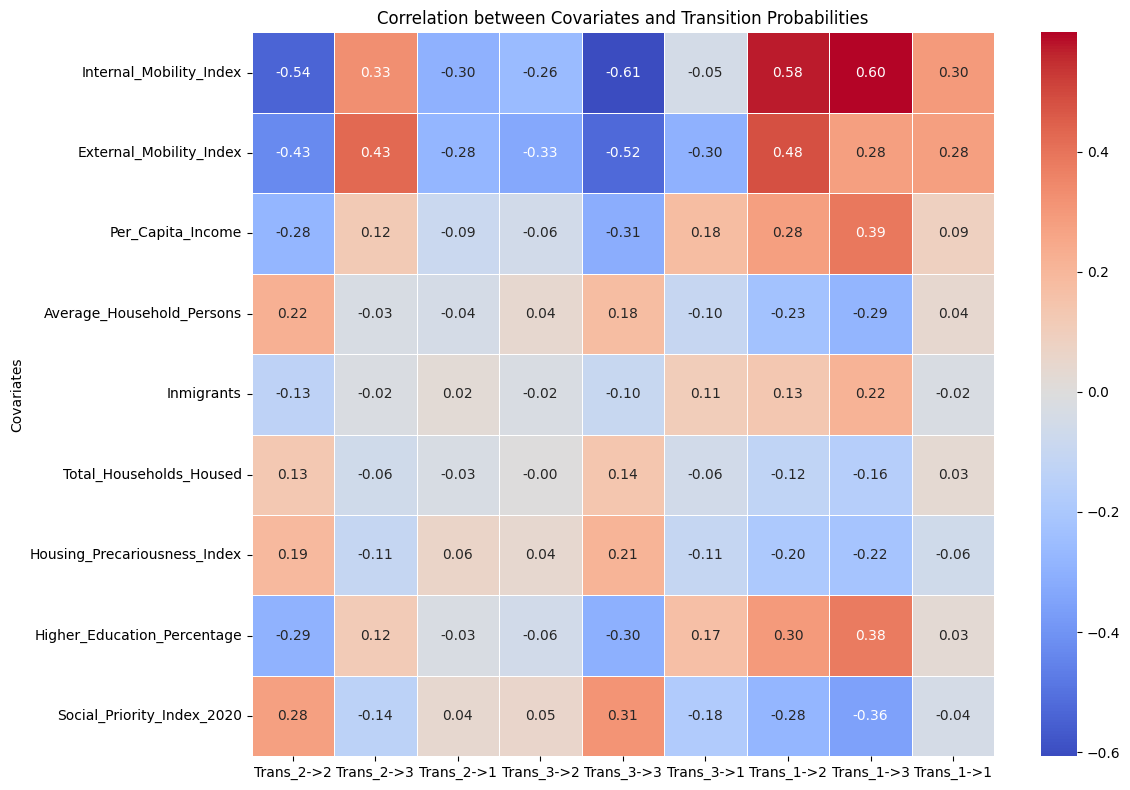

In [ ]:
# Calculate the correlation matrix
correlations = analysis_df.corr().loc[
    covariates_df.columns, 
    transitions_df.columns
]

# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation between Covariates and Transition Probabilities")
plt.xlabel(None)
plt.ylabel("Covariates")
plt.tight_layout()
plt.show()


In [59]:
viterbi_merged.columns

Index(['state', 'S1', 'S2', 'S3', 'row_id', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days',
       'Reordened_state'],
      dtype='object')

In [60]:

transitions = []


for idx, matriz in enumerate(transition_matrix):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transitions.append({
                'Original_Day':  viterbi_merged.iloc[idx]['Days'],  # Original day on final basis
                'Correlative_Day': idx,  # Index or correlative day generated
                'Commune': viterbi_merged.iloc[idx]['Commune'],  # Commune associated to the day
                'from_state': from_state + 1,  
                'to_state': to_state + 1,     
                'probability': matriz[from_state][to_state]
            })

transitions_df = pd.DataFrame(transitions)

transitions_df['Transition'] = (
    "Trans_" + transitions_df['from_state'].astype(str) + "->" + transitions_df['to_state'].astype(str)
)




In [61]:
transitions_df.head()

Original_Day  Correlative_Day    Commune  from_state  to_state  probability  \
0   2020-04-02                0  Cerrillos           1         1     0.988007   
1   2020-04-02                0  Cerrillos           1         2     0.001919   
2   2020-04-02                0  Cerrillos           1         3     0.007732   
3   2020-04-02                0  Cerrillos           2         1     0.010587   
4   2020-04-02                0  Cerrillos           2         2     0.998081   

   Transition  
0  Trans_1->1  
1  Trans_1->2  
2  Trans_1->3  
3  Trans_2->1  
4  Trans_2->2

In [62]:
# Rearrange the states to match the desired interpretation:
remap_transition_states = {'Trans_1->1':'Trans_2->2','Trans_1->2':'Trans_2->3','Trans_1->3':'Trans_2->1','Trans_2->2':'Trans_3->3','Trans_2->3':'Trans_3->1',
                           'Trans_3->1':'Trans_1->2','Trans_3->2':'Trans_1->3','Trans_3->3':'Trans_1->1','Trans_2->1':'Trans_3->2'}

transitions_df['Reordened_Transition'] = transitions_df['Transition'].map(remap_transition_states)

In [63]:
# Pivot to have the transitions as columns
transitions_df = transitions_df.pivot(
    index=['Commune', 'Original_Day', 'Correlative_Day'],  # Add both day references
    columns='Reordened_Transition',
    values='probability'
).reset_index()


print("DataFrame of transitions updated:")
print(transitions_df.head())


DataFrame of transitions updated:
Reordened_Transition    Commune Original_Day  Correlative_Day  Trans_1->1  \
0                     Cerrillos   2020-04-02                0    0.992268   
1                     Cerrillos   2020-04-03                1    0.991126   
2                     Cerrillos   2020-04-04                2    0.989853   
3                     Cerrillos   2020-04-05                3    0.984629   
4                     Cerrillos   2020-04-06                4    0.982625   

Reordened_Transition  Trans_1->2    Trans_1->3  Trans_2->1  Trans_2->2  \
0                       0.001407  3.676253e-16    0.007732    0.988007   
1                       0.000724  3.998441e-17    0.008874    0.981707   
2                       0.000231  1.161598e-18    0.010147    0.962216   
3                       0.003209  6.806549e-16    0.015371    0.984126   
4                       0.000072  1.358643e-20    0.017375    0.890539   

Reordened_Transition  Trans_2->3    Trans_3->1  Trans_3->2

In [64]:
transitions_df.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Trans_1->1',
       'Trans_1->2', 'Trans_1->3', 'Trans_2->1', 'Trans_2->2', 'Trans_2->3',
       'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
      dtype='object', name='Reordened_Transition')

In [65]:
# Convert transitions to “long” format
transitions_long = pd.melt(
    transitions_df,
    id_vars=['Commune', 'Original_Day', 'Correlative_Day'],  # Include both columns of days
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
    var_name='Transition',
    value_name='Probability_Transition'
)

# Perform the merge to add the covariables from base_final
lmm_data = transitions_long.merge(
    viterbi_merged[['Commune', 'Days', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
                'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed', 
                'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']],
    left_on=['Commune', 'Original_Day'],  # Use Original_day to match base_final
    right_on=['Commune', 'Days'],         # The column in base_final is ‘days’.
    how='left'
)


print("Data prepared for LMM (in long format with additional covariates):")
print(lmm_data.head())


Data prepared for LMM (in long format with additional covariates):
     Commune Original_Day  Correlative_Day  Transition  \
0  Cerrillos   2020-04-02                0  Trans_1->1   
1  Cerrillos   2020-04-03                1  Trans_1->1   
2  Cerrillos   2020-04-04                2  Trans_1->1   
3  Cerrillos   2020-04-05                3  Trans_1->1   
4  Cerrillos   2020-04-06                4  Trans_1->1   

   Probability_Transition       Days  Internal_Mobility_Index  \
0                0.992268 2020-04-02                 1.970381   
1                0.991126 2020-04-03                 1.845790   
2                0.989853 2020-04-04                 1.678598   
3                0.984629 2020-04-05                 1.736766   
4                0.982625 2020-04-06                 1.331296   

   External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  \
0                 7.804008               2.248303           2.248303   
1                 7.471452               4.496605

In [66]:
lmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Commune                                  65484 non-null  object        
 1   Original_Day                             65484 non-null  datetime64[ns]
 2   Correlative_Day                          65484 non-null  int64         
 3   Transition                               65484 non-null  object        
 4   Probability_Transition                   65484 non-null  float64       
 5   Days                                     65484 non-null  datetime64[ns]
 6   Internal_Mobility_Index                  65484 non-null  float64       
 7   External_Mobility_Index                  65484 non-null  float64       
 8   Cumulative_Cases_Rate                    65484 non-null  float64       
 9   Gross_Daily_Cases                      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

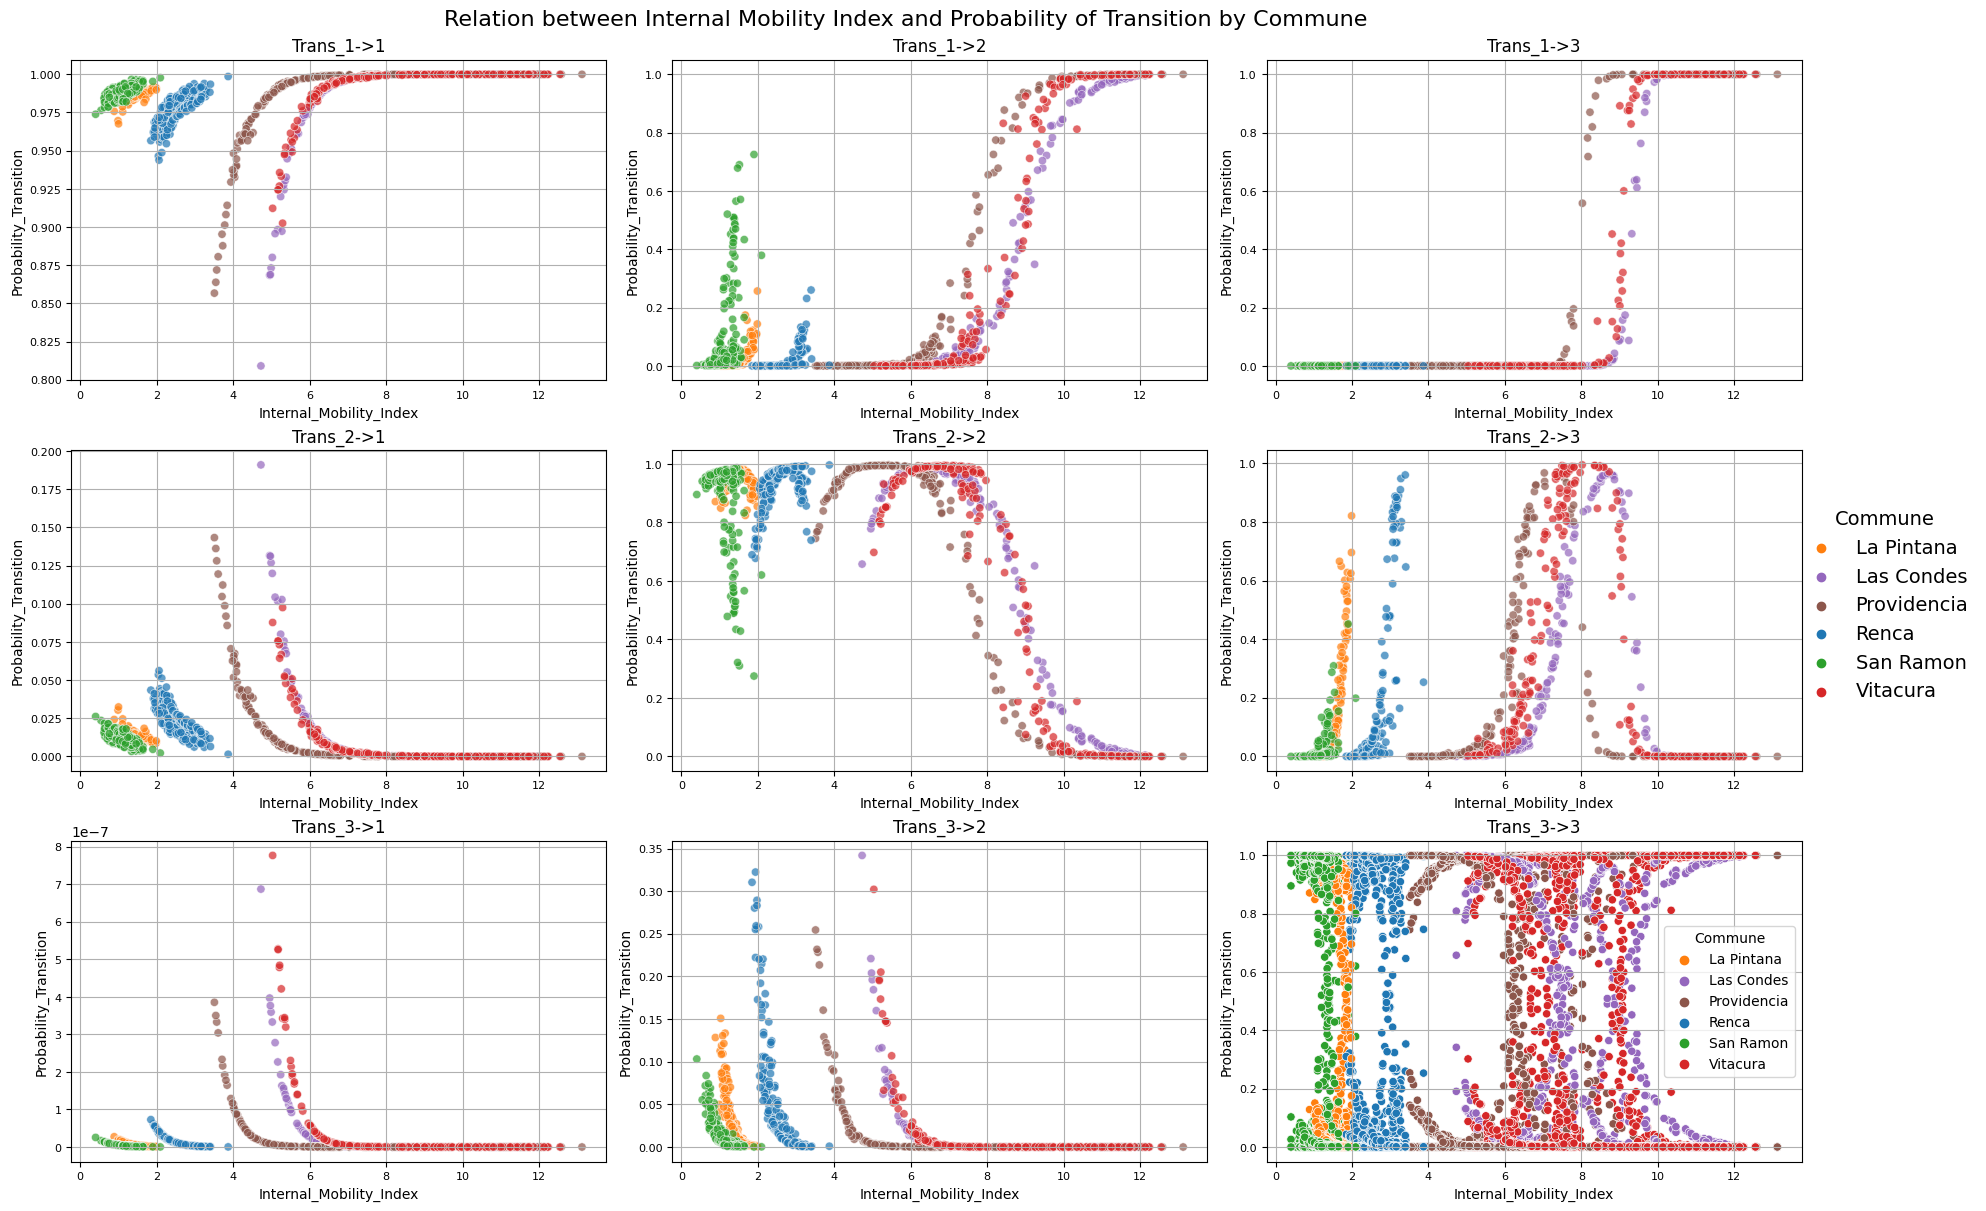

In [67]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Renca') | (lmm_data['Commune'] == 'La Pintana') | (lmm_data['Commune'] == 'San Ramon') | (lmm_data['Commune'] == 'Vitacura') | (lmm_data['Commune'] == 'Las Condes')| (lmm_data['Commune'] == 'Providencia')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()
# Define a custom palette with one specific color correction
custom_palette = {
    'Renca': '#1f77b4',          # Blue
    'La Pintana': '#ff7f0e',     # Orange
    'San Ramon': '#2ca02c',      # Green
    'Vitacura': '#d62728',       # Bright Red
    'Las Condes': '#9467bd',     # Purple
    'Providencia': '#8c564b'     # Dark Brown
}
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[lmm_data['Commune'].isin(custom_palette.keys())]



# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='Internal_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=custom_palette,  # Use the custom color palette
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('Internal_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='Internal_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=custom_palette,  # Use the custom color palette
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.1, 0.5),
    frameon=False  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between Internal Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

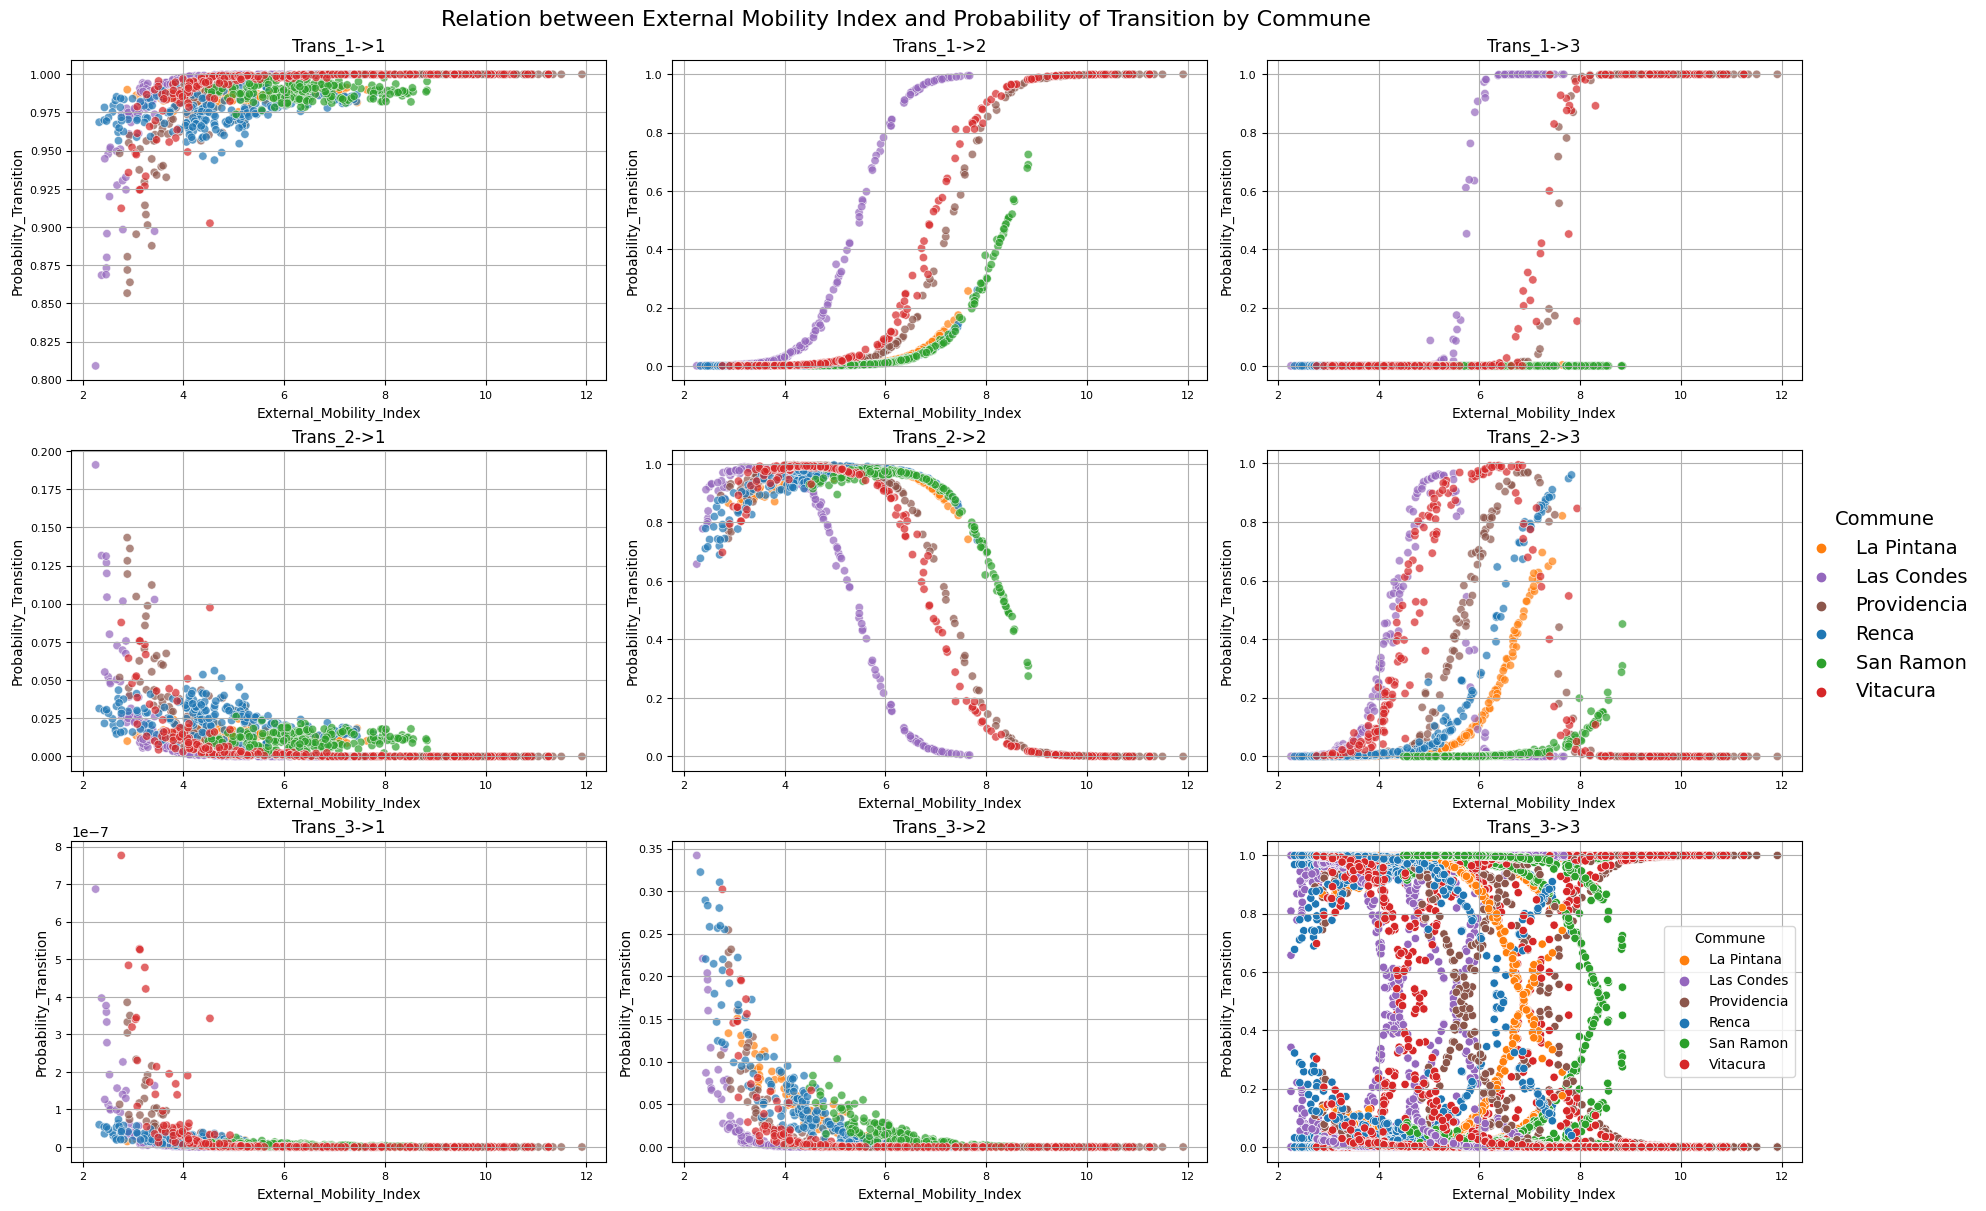

In [68]:
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[(lmm_data['Commune'] == 'Renca') | (lmm_data['Commune'] == 'La Pintana') | (lmm_data['Commune'] == 'San Ramon') | (lmm_data['Commune'] == 'Vitacura') | (lmm_data['Commune'] == 'Las Condes')| (lmm_data['Commune'] == 'Providencia')]

# Lista de transiciones únicas
transiciones_unicas = filtered_communes['Transition'].unique()
# Define a custom palette with one specific color correction
custom_palette = {
    'Renca': '#1f77b4',          # Blue
    'La Pintana': '#ff7f0e',     # Orange
    'San Ramon': '#2ca02c',      # Green
    'Vitacura': '#d62728',       # Bright Red
    'Las Condes': '#9467bd',     # Purple
    'Providencia': '#8c564b'     # Dark Brown
}
# Filtrar los datos para las comunas específicas
filtered_communes = lmm_data[lmm_data['Commune'].isin(custom_palette.keys())]



# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18, 12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=filtered_communes[filtered_communes['Transition'] == transicion],
        x='External_Mobility_Index',
        y='Probability_Transition',
        hue='Commune',  # Color basado en la comuna
        palette=custom_palette,  # Use the custom color palette
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('External_Mobility_Index', fontsize=10)
    axes[i].set_ylabel('Probability_Transition', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
handles, labels = sns.scatterplot(
    data=filtered_communes,
    x='External_Mobility_Index',
    y='Probability_Transition',
    hue='Commune',
    palette=custom_palette,  # Use the custom color palette
    legend=True
).get_legend_handles_labels()

fig.legend(
    handles, labels, loc='center right', title='Commune',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.1, 0.5),
    frameon=False  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relation between External Mobility Index and Probability of Transition by Commune', fontsize=16)
plt.show()

_______________

In [70]:
# Cargar librerías necesarias
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Asegurarnos de que los datos estén correctamente formateados
lmm_data['Commune'] = lmm_data['Commune'].astype('category')  # Comuna como categoría

# Inspeccionar la estructura de los datos
print(lmm_data.info())
print(lmm_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Commune                                  65484 non-null  category      
 1   Original_Day                             65484 non-null  datetime64[ns]
 2   Correlative_Day                          65484 non-null  int64         
 3   Transition                               65484 non-null  object        
 4   Probability_Transition                   65484 non-null  float64       
 5   Days                                     65484 non-null  datetime64[ns]
 6   Internal_Mobility_Index                  65484 non-null  float64       
 7   External_Mobility_Index                  65484 non-null  float64       
 8   Cumulative_Cases_Rate                    65484 non-null  float64       
 9   Gross_Daily_Cases                      

In [72]:
lmm_data.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Transition',
       'Probability_Transition', 'Days', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Cumulative_Cases_Rate', 'Gross_Daily_Cases',
       'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Higher_Education_Percentage',
       'Social_Priority_Index_2020'],
      dtype='object')

Elastic Net RMSE: 24.013234896265164

Coeficientes:
                       Variable  Elastic Net Coef
0             Per_Capita_Income         -0.000000
1     Average_Household_Persons          0.007976
2                    Inmigrants         -0.139307
3       Total_Households_Housed         -0.857459
4  Housing_Precariousness_Index          0.761006
5   Higher_Education_Percentage         -2.324664
6    Social_Priority_Index_2020          2.047841


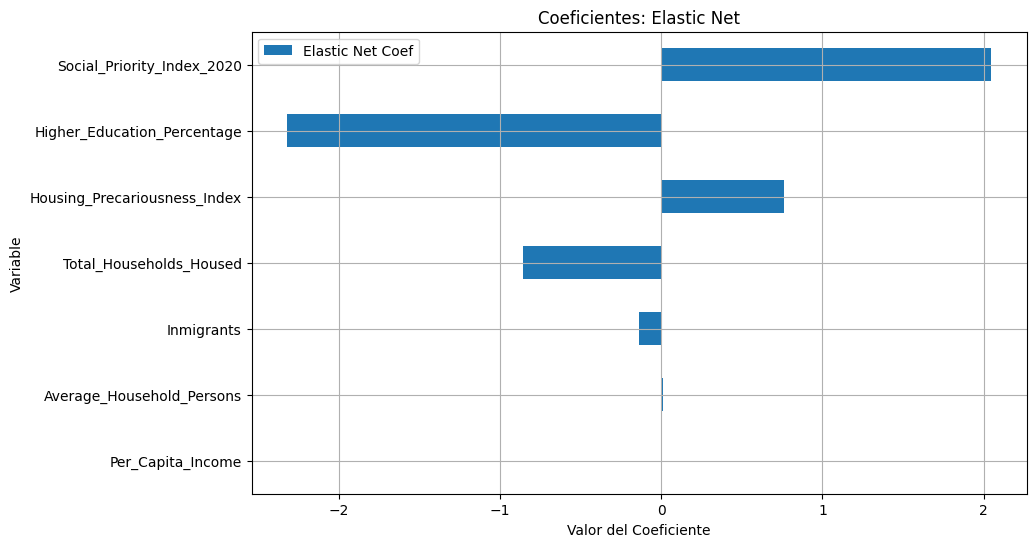

In [73]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define las columnas de covariables y la variable objetivo
covariables = ['Per_Capita_Income', 'Average_Household_Persons',
               'Inmigrants', 'Total_Households_Housed', 'Housing_Precariousness_Index',
               'Higher_Education_Percentage', 'Social_Priority_Index_2020']
target = 'Gross_Daily_Cases_Mobile_Average_7_Days'  # Sustituye por tu variable objetivo

# Dividir los datos en características (X) y objetivo (y)
X = lmm_data[covariables]
y = lmm_data[target]

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ajustar modelo Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)  # Ajusta alpha y l1_ratio según sea necesario
elastic_net.fit(X_train, y_train)

# Coeficientes obtenidos
elastic_net_coef = elastic_net.coef_

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Variable': covariables,
    'Elastic Net Coef': elastic_net_coef
})

# Evaluar el modelo
elastic_net_pred = elastic_net.predict(X_test)
elastic_net_rmse = np.sqrt(mean_squared_error(y_test, elastic_net_pred))

# Mostrar resultados
print("Elastic Net RMSE:", elastic_net_rmse)
print("\nCoeficientes:")
print(coef_df)

# Visualización opcional
import matplotlib.pyplot as plt

coef_df.set_index('Variable').plot(kind='barh', figsize=(10, 6))
plt.title('Coeficientes: Elastic Net')
plt.xlabel('Valor del Coeficiente')
plt.grid(True)
plt.show()

Elastic Net RMSE: 24.01930668908374

Coeficientes:
                       Variable  Elastic Net Coef
0             Per_Capita_Income         -0.542138
1     Average_Household_Persons         -0.247706
2                    Inmigrants         -0.218160
3       Total_Households_Housed         -0.763682
4  Housing_Precariousness_Index          1.155550
5   Higher_Education_Percentage         -3.534679


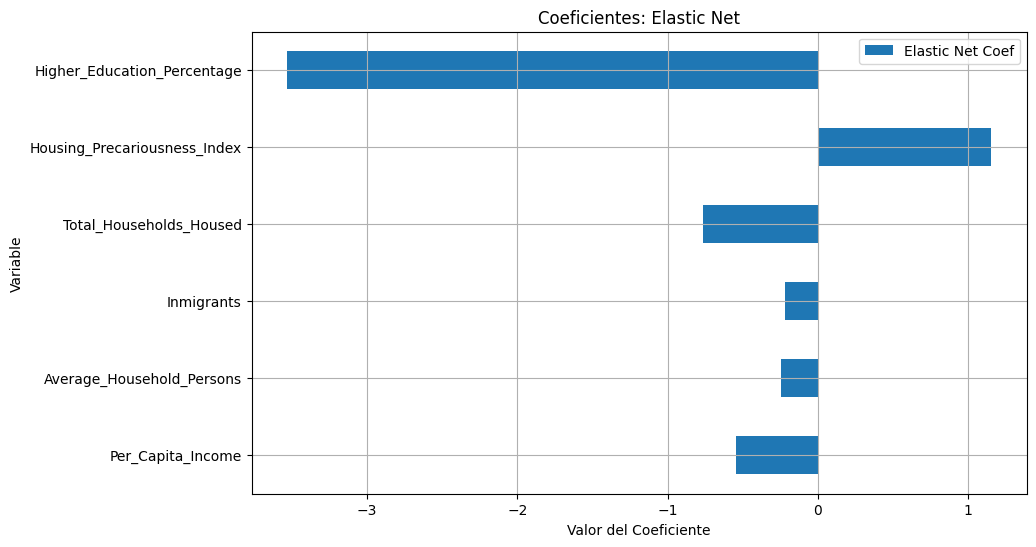

In [74]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define las columnas de covariables y la variable objetivo
covariables = ['Per_Capita_Income', 'Average_Household_Persons',
               'Inmigrants', 'Total_Households_Housed', 'Housing_Precariousness_Index',
               'Higher_Education_Percentage']
target = 'Gross_Daily_Cases_Mobile_Average_7_Days'  # Sustituye por tu variable objetivo

# Dividir los datos en características (X) y objetivo (y)
X = lmm_data[covariables]
y = lmm_data[target]

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ajustar modelo Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)  # Ajusta alpha y l1_ratio según sea necesario
elastic_net.fit(X_train, y_train)

# Coeficientes obtenidos
elastic_net_coef = elastic_net.coef_

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Variable': covariables,
    'Elastic Net Coef': elastic_net_coef
})

# Evaluar el modelo
elastic_net_pred = elastic_net.predict(X_test)
elastic_net_rmse = np.sqrt(mean_squared_error(y_test, elastic_net_pred))

# Mostrar resultados
print("Elastic Net RMSE:", elastic_net_rmse)
print("\nCoeficientes:")
print(coef_df)

# Visualización opcional
import matplotlib.pyplot as plt

coef_df.set_index('Variable').plot(kind='barh', figsize=(10, 6))
plt.title('Coeficientes: Elastic Net')
plt.xlabel('Valor del Coeficiente')
plt.grid(True)
plt.show()

In [ ]:
# pip install pymer4 rpy2

In [75]:
from pymer4.models import Lmer
import pandas as pd

In [76]:
lmm_data.columns

Index(['Commune', 'Original_Day', 'Correlative_Day', 'Transition',
       'Probability_Transition', 'Days', 'Internal_Mobility_Index',
       'External_Mobility_Index', 'Cumulative_Cases_Rate', 'Gross_Daily_Cases',
       'Gross_Daily_Cases_Mobile_Average_7_Days', 'Per_Capita_Income',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Higher_Education_Percentage',
       'Social_Priority_Index_2020'],
      dtype='object')

### Transición Estado 1 a Estado 2

In [77]:
from pymer4.models import Lmer

# Filtrar los datos para la transición 'Trans_2->1'
transicion_especifica_1_2 = 'Trans_1->2'
datos_transicion_1_2 = lmm_data[lmm_data['Transition'] == transicion_especifica_1_2]

# Asegurarse de que la columna 'Comuna' sea categórica
datos_transicion_1_2['Commune'] = datos_transicion_1_2['Commune'].astype('category')

# Inspeccionar los datos
print(f"Número de observaciones para {transicion_especifica_1_2}: {len(datos_transicion_1_2)}")
print(datos_transicion_1_2.head())

Número de observaciones para Trans_1->2: 7276
        Commune Original_Day  Correlative_Day  Transition  \
7276  Cerrillos   2020-04-02                0  Trans_1->2   
7277  Cerrillos   2020-04-03                1  Trans_1->2   
7278  Cerrillos   2020-04-04                2  Trans_1->2   
7279  Cerrillos   2020-04-05                3  Trans_1->2   
7280  Cerrillos   2020-04-06                4  Trans_1->2   

      Probability_Transition       Days  Internal_Mobility_Index  \
7276                0.001407 2020-04-02                 1.970381   
7277                0.000724 2020-04-03                 1.845790   
7278                0.000231 2020-04-04                 1.678598   
7279                0.003209 2020-04-05                 1.736766   
7280                0.000072 2020-04-06                 1.331296   

      External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  \
7276                 7.804008               2.248303           2.248303   
7277                 7.47145

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_66502/1041077056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_transicion_1_2['Commune'] = datos_transicion_1_2['Commune'].astype('category')


In [78]:
from pymer4.models import Lmer

modeloC_1_2 = Lmer(
    formula="Probability_Transition ~ Internal_Mobility_Index + External_Mobility_Index + (Original_Day|Commune)",
    data=datos_transicion_1_2
)

resultado_modeloC_1_2 = modeloC_1_2.fit(REML=True)
print(resultado_modeloC_1_2)


RRuntimeError: Error en `*tmp*`@factors: 
  no applicable method for `@` applied to an object of class "matrix"


*Arroja error. ChatGPT sugiere escalar.*

In [79]:
from sklearn.preprocessing import StandardScaler

# Crear una copia para no alterar otros análisis
datos_transicion_1_2_scaled = datos_transicion_1_2.copy()

# Escalar la variable Original_Day
scaler = StandardScaler()
datos_transicion_1_2_scaled['Original_Day_scaled'] = scaler.fit_transform(
    datos_transicion_1_2[['Original_Day']]
)


In [80]:
modeloC_1_2 = Lmer(
    formula="Probability_Transition ~ Internal_Mobility_Index + External_Mobility_Index + (Original_Day_scaled|Commune)",
    data=datos_transicion_1_2_scaled
)

resultado_modeloC_1_2 = modeloC_1_2.fit(REML=True)
print(resultado_modeloC_1_2)


Linear mixed model fit by REML [’lmerMod’]
Formula: Probability_Transition~Internal_Mobility_Index+External_Mobility_Index+(Original_Day_scaled|Commune)

Family: gaussian	 Inference: parametric

Number of observations: 7276	 Groups: {'Commune': 34.0}

Log-likelihood: 5283.293 	 AIC: -10552.585

Random effects:

                         Name    Var    Std
Commune           (Intercept)  0.015  0.123
Commune   Original_Day_scaled  0.004  0.063
Residual                       0.013  0.114

                 IV1                  IV2   Corr
Commune  (Intercept)  Original_Day_scaled  0.115

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                -0.614  -0.658   -0.570  0.022    40.609 -27.532   
Internal_Mobility_Index     0.099   0.093    0.105  0.003  2460.319  33.672   
External_Mobility_Index     0.070   0.067    0.074  0.002  3555.037  38.305   

                         P-val  Sig  
(Intercept)                0.0  ***  
In

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


1. Efectos fijos (efecto promedio en todas las comunas)

Variable: (Intercept)
Estimate:	-0.614	(p-value < 0.001)	
Interpretación: Cuando la movilidad interna y externa son 0, y el tiempo está centrado (día promedio), la probabilidad base de transición es -0.614. Como esta es una variable transformada o centrada, no tiene una interpretación directa práctica, pero es útil para el modelo.

Variable: Internal_Mobility_Index
Estimate: 0.099 (p-value < 0.001)
Interpretación: Por cada unidad adicional en el índice de movilidad interna, la probabilidad de transición del estado 1 al 2 aumenta en 0.099 (en promedio), manteniendo constante la movilidad externa y el día.

Variable: External_Mobility_Index
Estimate: 0.070 (p-value < 0.001)
Interpretación: Por cada unidad adicional en el índice de movilidad externa, la probabilidad de transición del estado 1 al 2 aumenta en 0.070, controlando por movilidad interna y día.

Ambos efectos son estadísticamente significativos (*), y positivos**: más movilidad (interna o externa) se asocia con mayor probabilidad de pasar del estado 1 (más leve) al estado 2 (más moderado).


Componente: Intercepto aleatorio (Commune)
- Varianza: 0.015
- Desviación estándar: 0.123

Componente: Pendiente para tiempo (Original_Day_scaled) por comuna
-  Varianza: 0.004
- Desviación estándar: 0.063

Componente: Correlación entre intercepto y pendiente
- Varianza: 0.115 


Esto significa que:

Las comunas tienen diferencias moderadas en su probabilidad base de transición (intercepto).

También tienen pequeñas diferencias en cómo cambia la probabilidad en el tiempo (pendientes por día).

La correlación positiva entre intercepto y pendiente sugiere que las comunas con mayor probabilidad base tienden a tener aumentos mayores con el tiempo.

Resumen interpretativo:

Se ajustó un modelo de efectos mixtos para explicar la probabilidad de transición del estado 1 al estado 2 en función de la movilidad interna, movilidad externa y el tiempo (estandarizado), considerando intercepto y pendiente aleatoria por comuna. Los resultados muestran que tanto la movilidad interna (β = 0.099, p < 0.001) como la movilidad externa (β = 0.070, p < 0.001) se asocian positivamente con una mayor probabilidad de transición. Además, se observó variabilidad entre comunas tanto en la probabilidad base de transición como en su evolución temporal, con una correlación positiva entre ambos componentes (r = 0.115).

In [81]:
from pymer4.models import Lmer

# Definir la fórmula del modelo con todas las covariables
formula_modeloD_1_2 = (
    "Probability_Transition ~ Internal_Mobility_Index + External_Mobility_Index + "
    "Per_Capita_Income + Average_Household_Persons + Inmigrants + "
    "Total_Households_Housed + Housing_Precariousness_Index + Higher_Education_Percentage + "
    "(Original_Day_scaled|Commune)"
)

# Crear el modelo
modeloD_1_2 = Lmer(formula=formula_modeloD_1_2, data=datos_transicion_1_2_scaled)

# Ajustar el modelo
resultado_modeloD_1_2 = modeloD_1_2.fit(REML=True)

# Mostrar resultados
print(resultado_modeloD_1_2)


Linear mixed model fit by REML [’lmerMod’]
Formula: Probability_Transition~Internal_Mobility_Index+External_Mobility_Index+Per_Capita_Income+Average_Household_Persons+Inmigrants+Total_Households_Housed+Housing_Precariousness_Index+Higher_Education_Percentage+(Original_Day_scaled|Commune)

Family: gaussian	 Inference: parametric

Number of observations: 7276	 Groups: {'Commune': 34.0}

Log-likelihood: 5249.784 	 AIC: -10473.568

Random effects:

                         Name    Var    Std
Commune           (Intercept)  0.008  0.088
Commune   Original_Day_scaled  0.004  0.063
Residual                       0.013  0.114

                 IV1                  IV2   Corr
Commune  (Intercept)  Original_Day_scaled  0.611

Fixed effects:

                              Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                     -0.257  -0.586    0.072  0.168    29.233   
Internal_Mobility_Index          0.101   0.095    0.107  0.003  5872.134   
External_Mobility_Index        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


Modelo C:
- R2 marginal: 0.315
- R2 condicional: 0.722


Modelo D:
- R2 marginal: 0.375
- R2 condicional: 0.675

El modelo D, que incluye variables sociodemográficas, aumenta la varianza explicada por los efectos fijos (R² marginal), lo que indica que estos factores mejoran la capacidad explicativa del modelo. Sin embargo, el R² condicional disminuye ligeramente, lo que sugiere que el modelo con menos efectos aleatorios (modelo C) capta mejor la varianza total cuando se consideran estos efectos conjuntamente.

### Transición Estado 2 a Estado 3

In [82]:
from pymer4.models import Lmer

# Filtrar los datos para la transición 'Trans_2->1'
transicion_especifica_2_3 = 'Trans_2->3'
datos_transicion_2_3 = lmm_data[lmm_data['Transition'] == transicion_especifica_2_3]

# Asegurarse de que la columna 'Comuna' sea categórica
datos_transicion_2_3['Commune'] = datos_transicion_2_3['Commune'].astype('category')

# Inspeccionar los datos
print(f"Número de observaciones para {transicion_especifica_2_3}: {len(datos_transicion_2_3)}")
print(datos_transicion_2_3.head())

Número de observaciones para Trans_2->3: 7276
         Commune Original_Day  Correlative_Day  Transition  \
36380  Cerrillos   2020-04-02                0  Trans_2->3   
36381  Cerrillos   2020-04-03                1  Trans_2->3   
36382  Cerrillos   2020-04-04                2  Trans_2->3   
36383  Cerrillos   2020-04-05                3  Trans_2->3   
36384  Cerrillos   2020-04-06                4  Trans_2->3   

       Probability_Transition       Days  Internal_Mobility_Index  \
36380                0.001919 2020-04-02                 1.970381   
36381                0.000874 2020-04-03                 1.845790   
36382                0.000240 2020-04-04                 1.678598   
36383                0.003281 2020-04-05                 1.736766   
36384                0.000056 2020-04-06                 1.331296   

       External_Mobility_Index  Cumulative_Cases_Rate  Gross_Daily_Cases  \
36380                 7.804008               2.248303           2.248303   
36381         

/var/folders/xh/mq1l0w_56rg4c6mbnqr_wghw0000gn/T/ipykernel_66502/1092706410.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_transicion_2_3['Commune'] = datos_transicion_2_3['Commune'].astype('category')


In [83]:
from sklearn.preprocessing import StandardScaler

# Crear una copia para no alterar otros análisis
datos_transicion_2_3_scaled = datos_transicion_2_3.copy()

# Escalar la variable Original_Day
scaler = StandardScaler()
datos_transicion_2_3_scaled['Original_Day_scaled'] = scaler.fit_transform(
    datos_transicion_2_3[['Original_Day']]
)

In [84]:
modeloC_2_3 = Lmer(
    formula="Probability_Transition ~ Internal_Mobility_Index + External_Mobility_Index + (Original_Day_scaled|Commune)",
    data=datos_transicion_2_3_scaled
)

resultado_modeloC_2_3 = modeloC_2_3.fit(REML=True)
print(resultado_modeloC_2_3)

Linear mixed model fit by REML [’lmerMod’]
Formula: Probability_Transition~Internal_Mobility_Index+External_Mobility_Index+(Original_Day_scaled|Commune)

Family: gaussian	 Inference: parametric

Number of observations: 7276	 Groups: {'Commune': 34.0}

Log-likelihood: 1306.331 	 AIC: -2598.662

Random effects:

                         Name    Var    Std
Commune           (Intercept)  0.073  0.270
Commune   Original_Day_scaled  0.013  0.114
Residual                       0.039  0.197

                 IV1                  IV2   Corr
Commune  (Intercept)  Original_Day_scaled  0.321

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                -0.452  -0.541   -0.362  0.046    34.206  -9.907   
Internal_Mobility_Index    -0.034  -0.044   -0.024  0.005  3964.459  -6.585   
External_Mobility_Index     0.132   0.126    0.139  0.003  5011.363  41.271   

                         P-val  Sig  
(Intercept)                0.0  ***  
Int

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


In [85]:
from pymer4.models import Lmer

# Definir la fórmula del modelo con todas las covariables
formula_modeloD_2_3 = (
    "Probability_Transition ~ Internal_Mobility_Index + External_Mobility_Index + "
    "Per_Capita_Income + Average_Household_Persons + Inmigrants + "
    "Total_Households_Housed + Housing_Precariousness_Index + Higher_Education_Percentage + "
    "(Original_Day_scaled|Commune)"
)

# Crear el modelo
modeloD_2_3 = Lmer(formula=formula_modeloD_2_3, data=datos_transicion_2_3_scaled)

# Ajustar el modelo
resultado_modeloD_2_3 = modeloD_2_3.fit(REML=True)

# Mostrar resultados
print(resultado_modeloD_2_3)

Linear mixed model fit by REML [’lmerMod’]
Formula: Probability_Transition~Internal_Mobility_Index+External_Mobility_Index+Per_Capita_Income+Average_Household_Persons+Inmigrants+Total_Households_Housed+Housing_Precariousness_Index+Higher_Education_Percentage+(Original_Day_scaled|Commune)

Family: gaussian	 Inference: parametric

Number of observations: 7276	 Groups: {'Commune': 34.0}

Log-likelihood: 1281.882 	 AIC: -2537.765

Random effects:

                         Name    Var    Std
Commune           (Intercept)  0.036  0.189
Commune   Original_Day_scaled  0.013  0.114
Residual                       0.039  0.197

                 IV1                  IV2   Corr
Commune  (Intercept)  Original_Day_scaled  0.753

Fixed effects:

                              Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                     -1.743  -2.329   -1.156  0.299    27.767   
Internal_Mobility_Index         -0.037  -0.048   -0.027  0.005  6101.714   
External_Mobility_Index         

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(
